# Test place for everything

# import functions

In [1]:
from sqlays import export_sql, import_sql
from matheq import Cel_to_Kel, Kel_to_Cel, to_pot_temp
from mapscre import station_map, bathy_data, contour_ver, TS_diagram
from iscays import sum_up, isc_summary, depth_bin_interval, particle_bin_interval, isc_xlsx 
from ctdays import find_start_row, raw_ctd_to_df
from graphcre import deployment_constancy, vertical_each_org_distribution, stacked_vertical_distribution, comp_vertical_distribution
from matheq import calDist
from matplotlib import pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np
import scipy.stats as stats
import os, glob, datetime, gsw

from tensorflow import keras

ModuleNotFoundError: No module named 'psycopg2'

# extract data and image from LOKI_browser by certain interval (distance)

In [ ]:
'''
proj_dir = ('/isibhv/projects/loki/data for Zoomie/PS107_20-5') # dir of folder extracted from loki_browser
meta_file =  glob.glob(os.path.join(proj_dir,'*.csv')) # glob meta data to get the info
meta_df = pd.read_csv(meta_file[0])
meta_df.columns = meta_df.columns.str.strip() # remove empty space of both side of coumns name
print(list(meta_df))
image_datetime = meta_df['Image'].apply(lambda x: x.split(' ')[0]+' '+x.split(' ')[1]).drop_duplicates() # get unique datetime as list
'''

In [73]:
#zoomie_csv_dir = os.path.expanduser('~/Git/OCEANpy/data/loki/zoomie_csv')
zoomie_csv_dir = os.path.expanduser('/Users/dong/Desktop/Git/OCEANpy/data/loki/zoomie_csv')

zoomie_df = pd.DataFrame()
for csv in glob.glob(os.path.join(zoomie_csv_dir, '*.csv')):
    csv_df = pd.read_csv(csv, sep=';|,', header=None, engine='python')
    zoomie_df=zoomie_df.append(csv_df)

zoomie_cols = ['object_length','object_width','object_area_px','object_form','object_area','object_convexity',
              'object_structure','object_graymean','object_kurtosis','object_skewness','object_Hu_moment_1',
              'object_Hu_moment_2','object_Hu_moment_3','object_Hu_moment_4','object_Hu_moment_5','object_Hu_moment_6',
              'object_Hu_moment_7','object_fourier_descriptor_01','object_fourier_descriptor_02',
              'object_fourier_descriptor_03','object_fourier_descriptor_04','object_fourier_descriptor_05',
              'object_fourier_descriptor_06','object_fourier_descriptor_07','object_fourier_descriptor_08',
              'object_fourier_descriptor_09','object_fourier_descriptor_10','img_file_name','object_index',
              'object_cruise','object_station','object_haul','object_date','object_time','object_pressure',
              'object_depth_min','object_salinity','object_conductivity','object_oxygen_concentration',
              'object_temperature_oxsens','object_oxygen_saturation','object_Dr._Haardt_fluorescence_channel_A',
              'object_manual_classification','object_manual_length','object_manual_width','object_posx','object_posy','object_milliseconds',
              'object_timestamp','object_zoomie_state','object_zoomie_deleted','object_zoomie_id','object_zoomie_proc','object_zoomie_group_id']

zoomie_df.columns = zoomie_cols # set column name
zoomie_df = zoomie_df[['object_station','object_depth_min', 'object_zoomie_state', 'object_zoomie_deleted','object_zoomie_group_id', 'img_file_name', 'object_area_px']]
station = zoomie_df['object_station'].drop_duplicates().to_list()
print(list(zoomie_df))

['object_station', 'object_depth_min', 'object_zoomie_state', 'object_zoomie_deleted', 'object_zoomie_group_id', 'img_file_name', 'object_area_px']


PS114-04-2


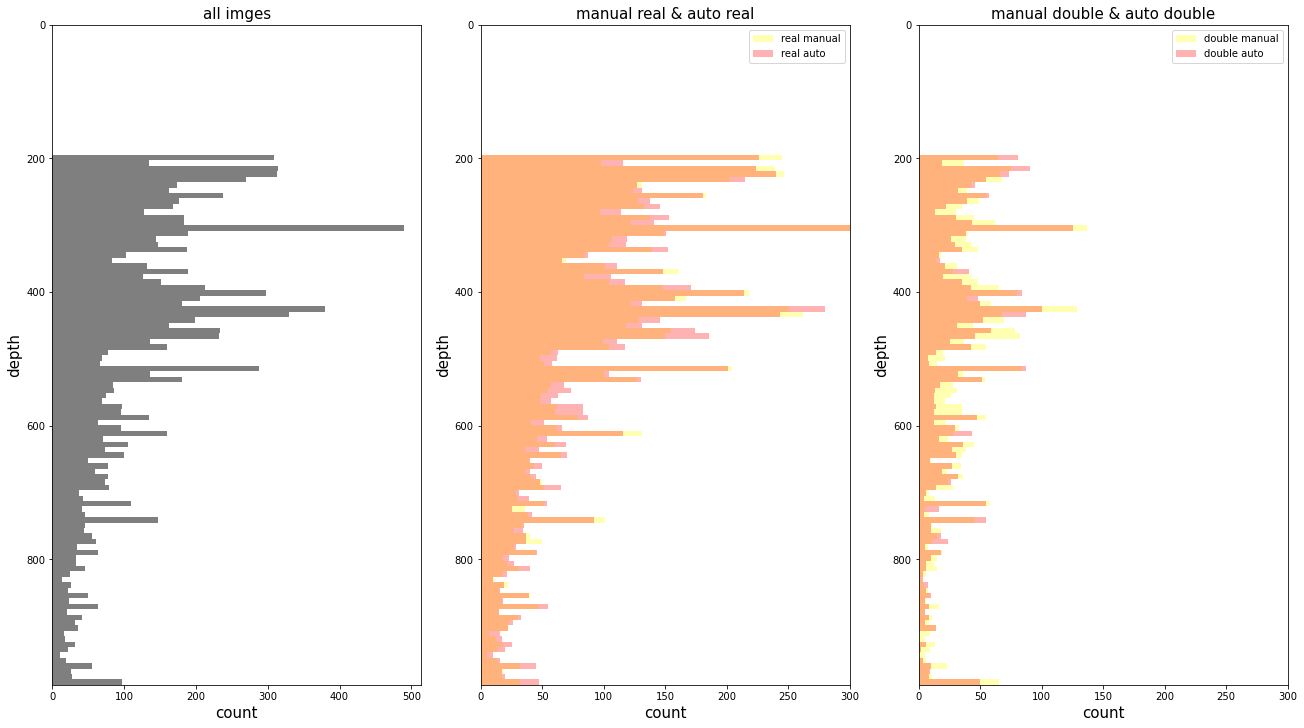

PS94-91-4


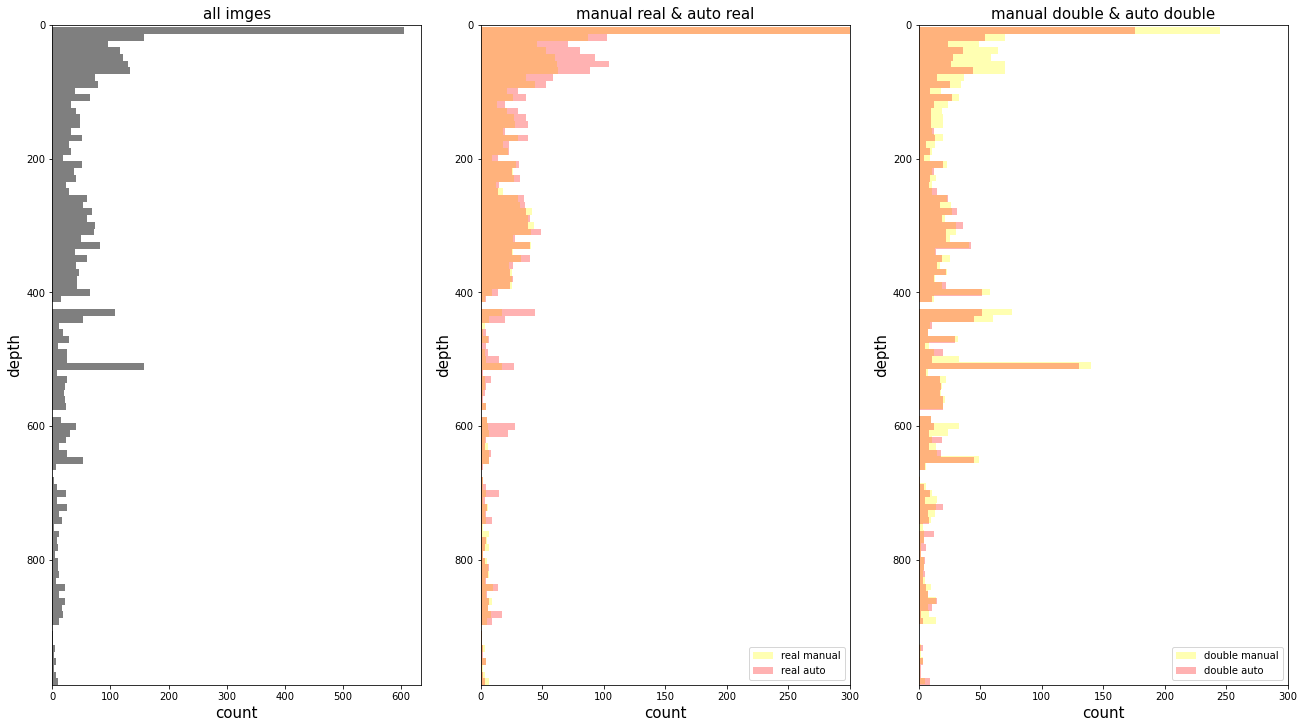

PS122-1_6-86


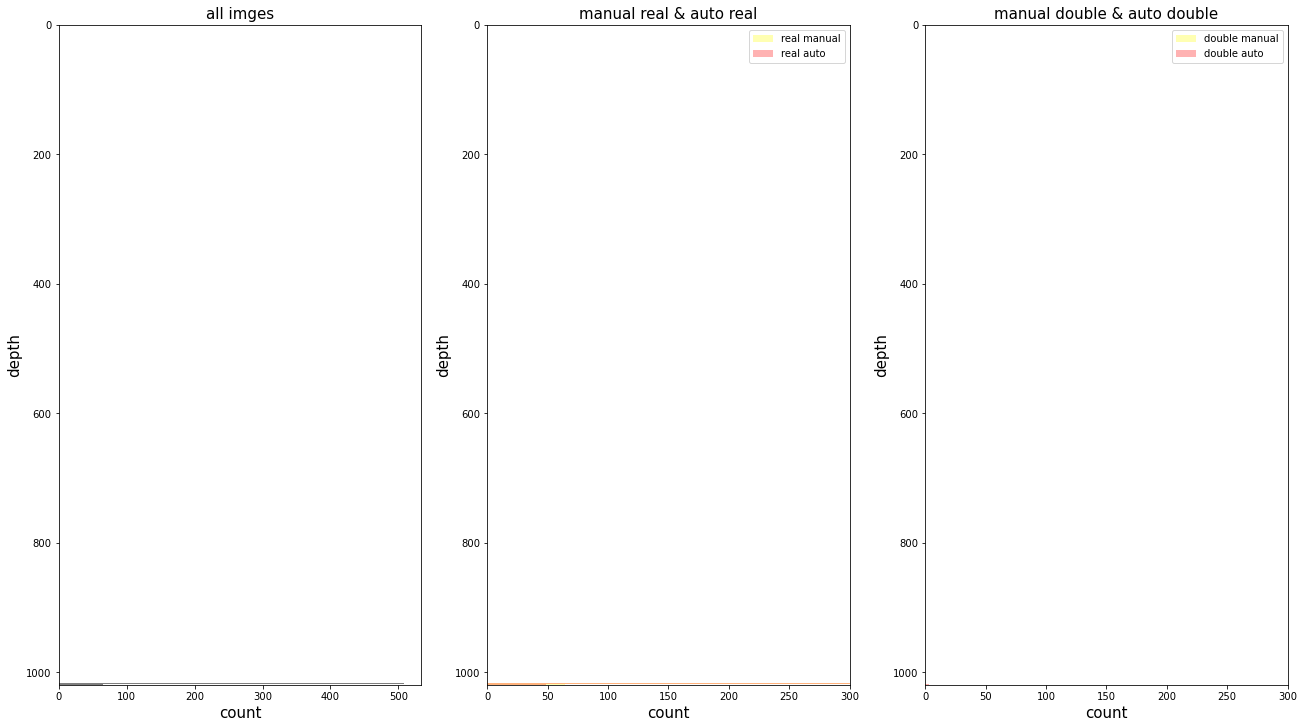

PS106.2-69-6


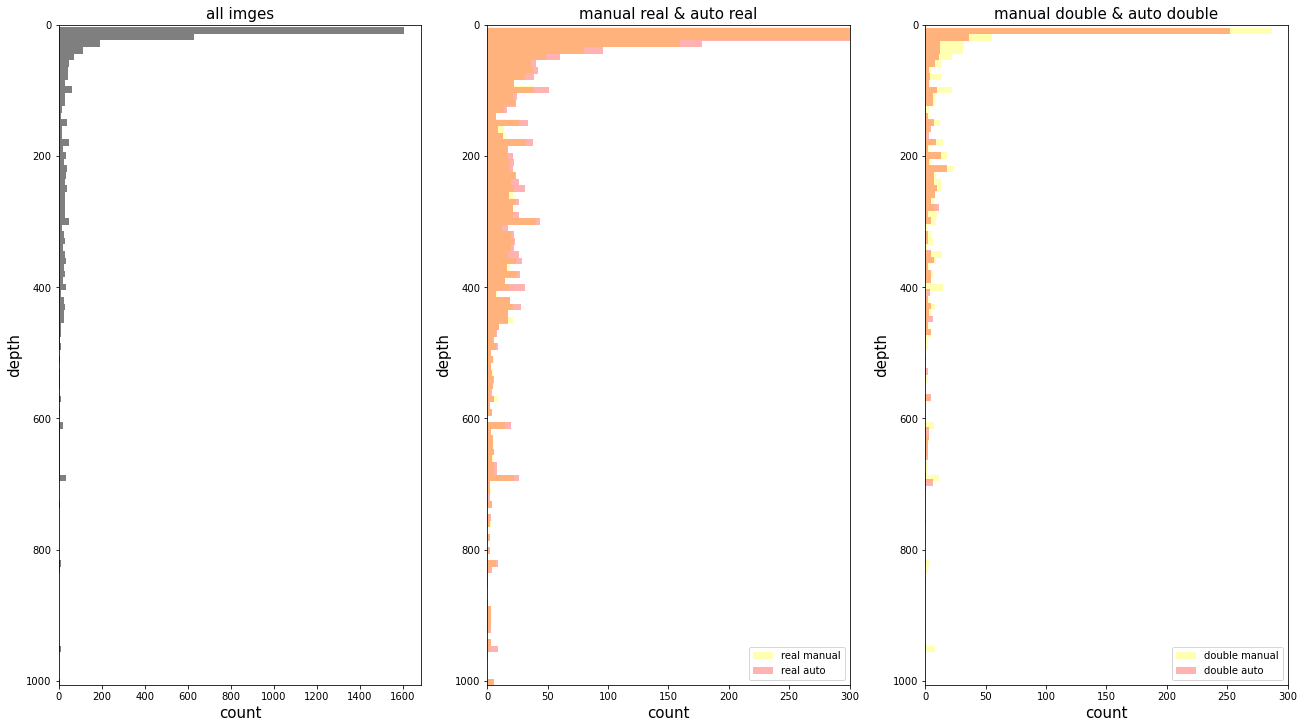

PS107-16


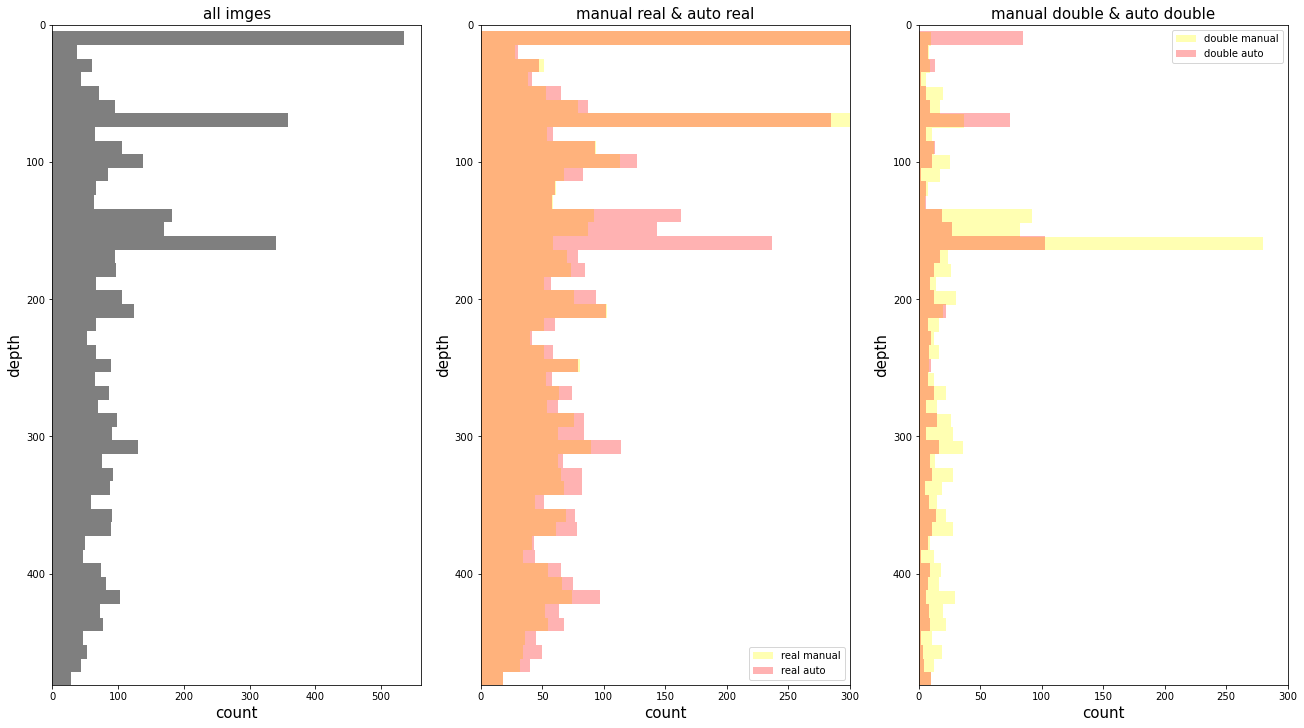

PS94-81-6


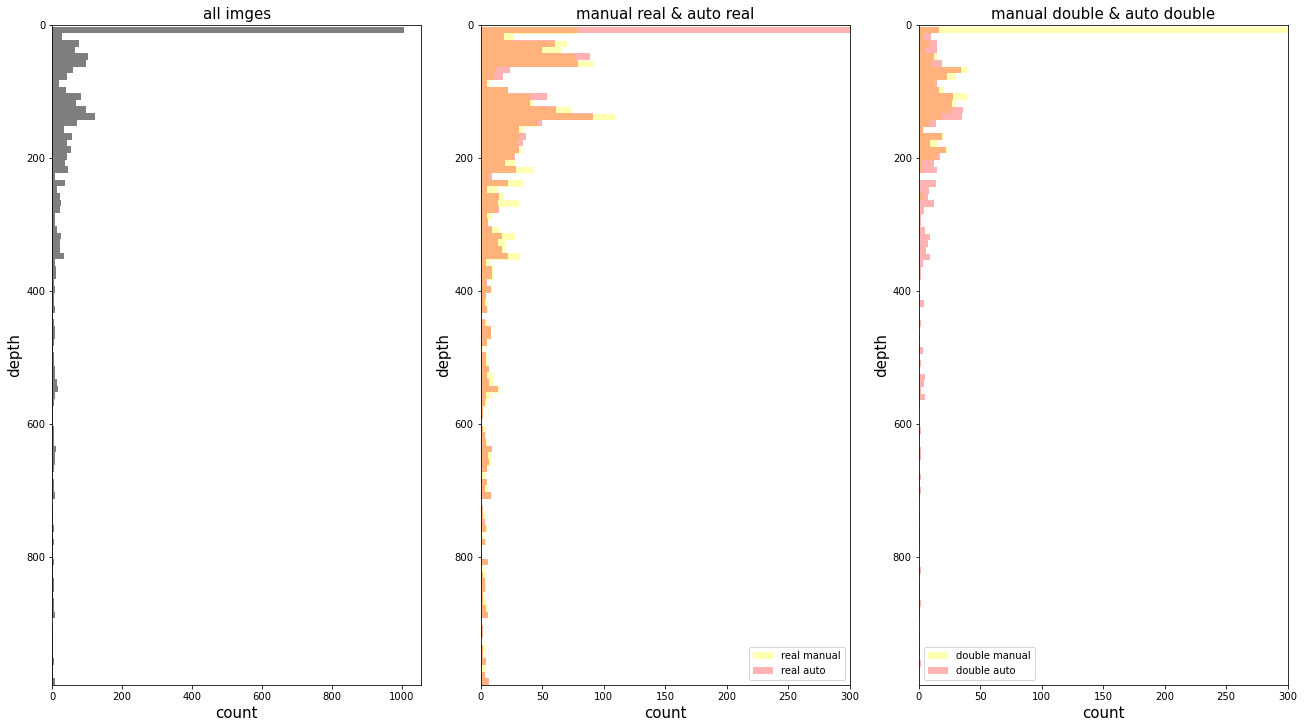

PS106.2-68-4


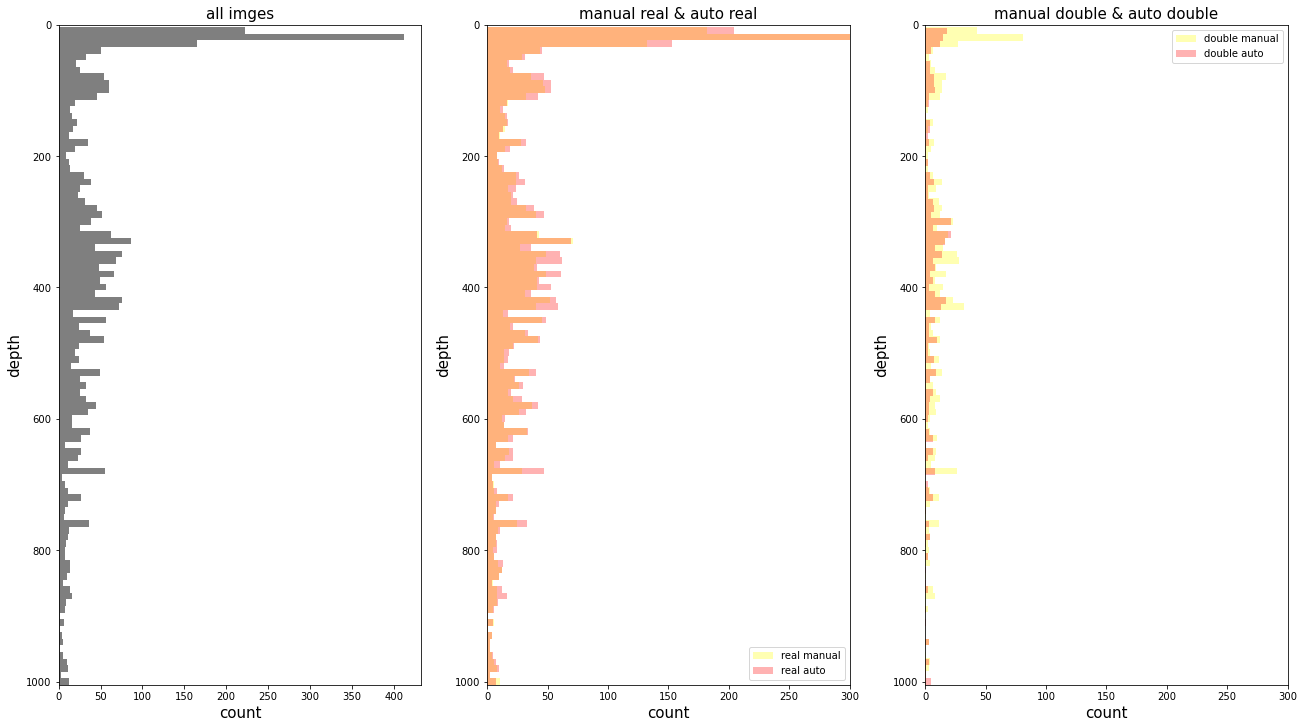

PS122-1-7-57


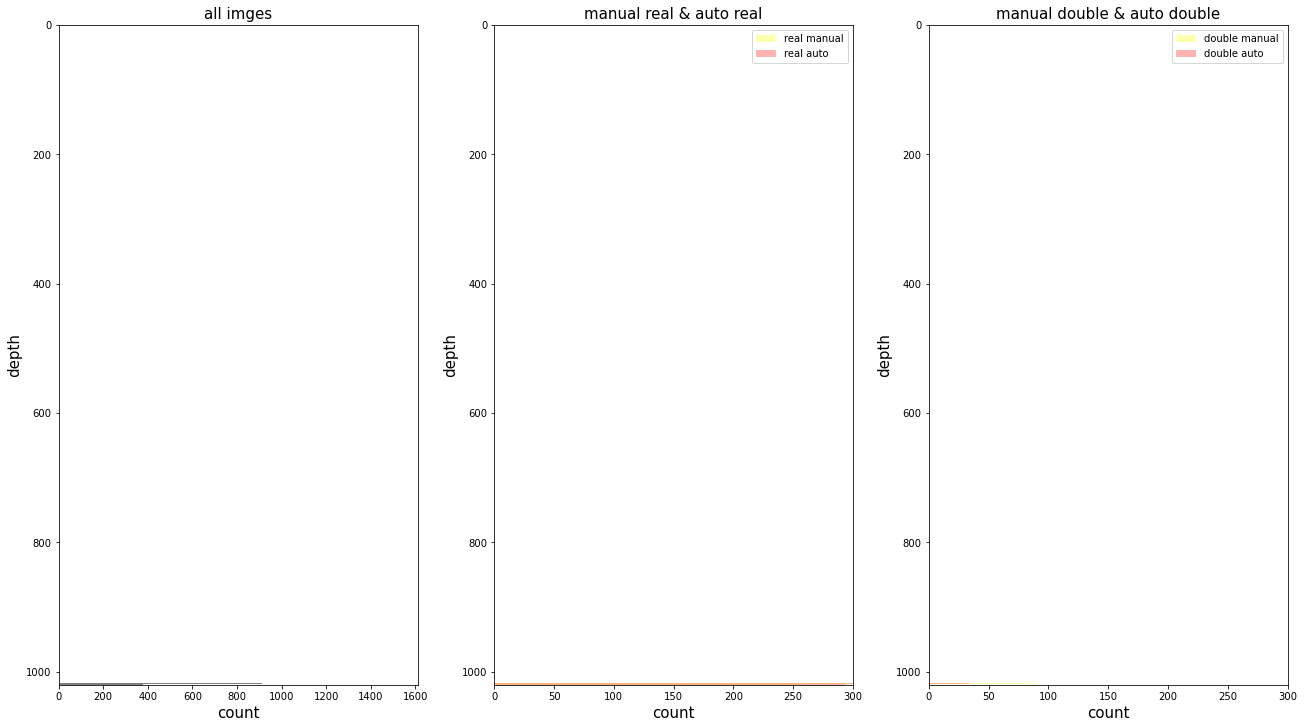

PS107-14


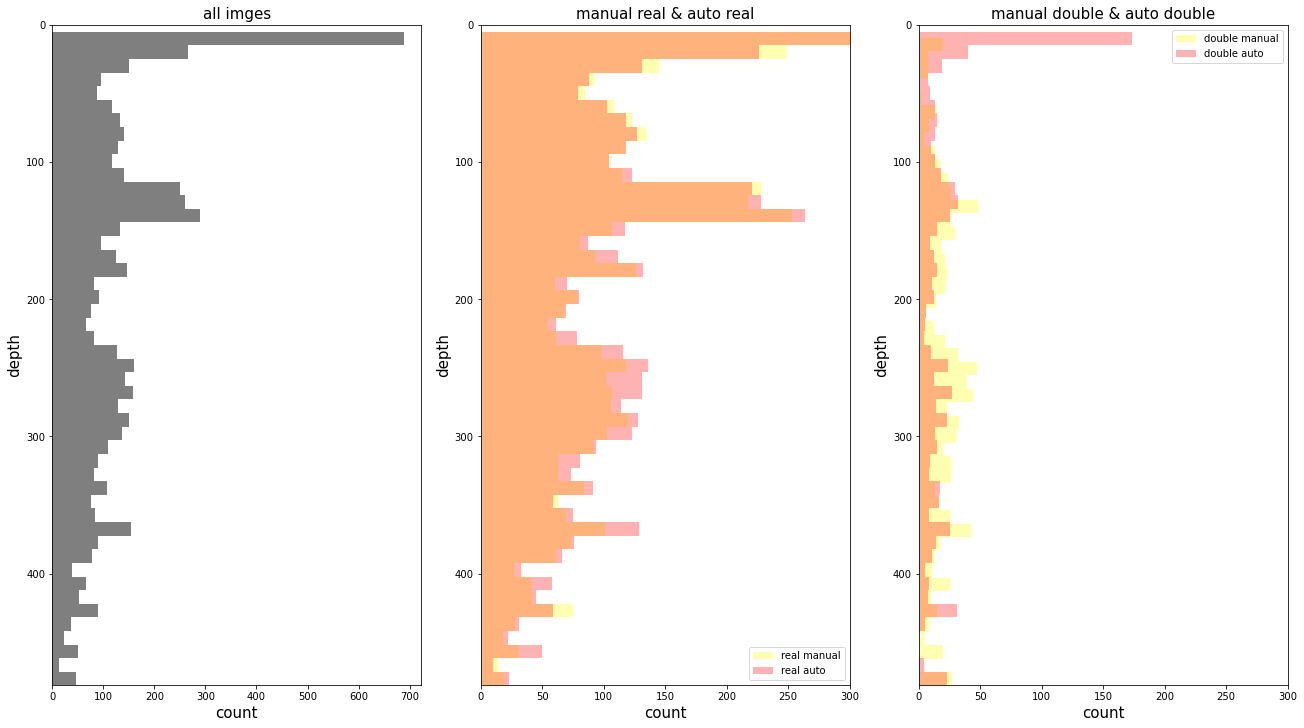

PS94-66-2


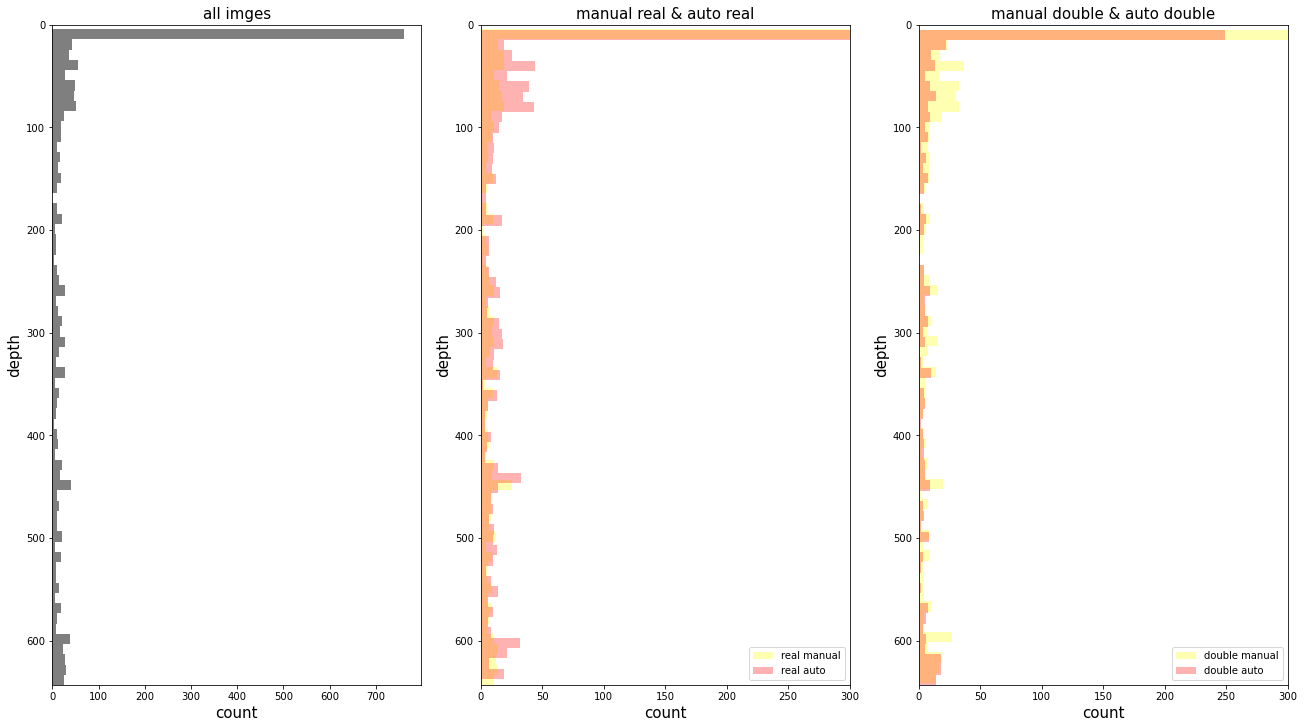

PS122-1-8-73a


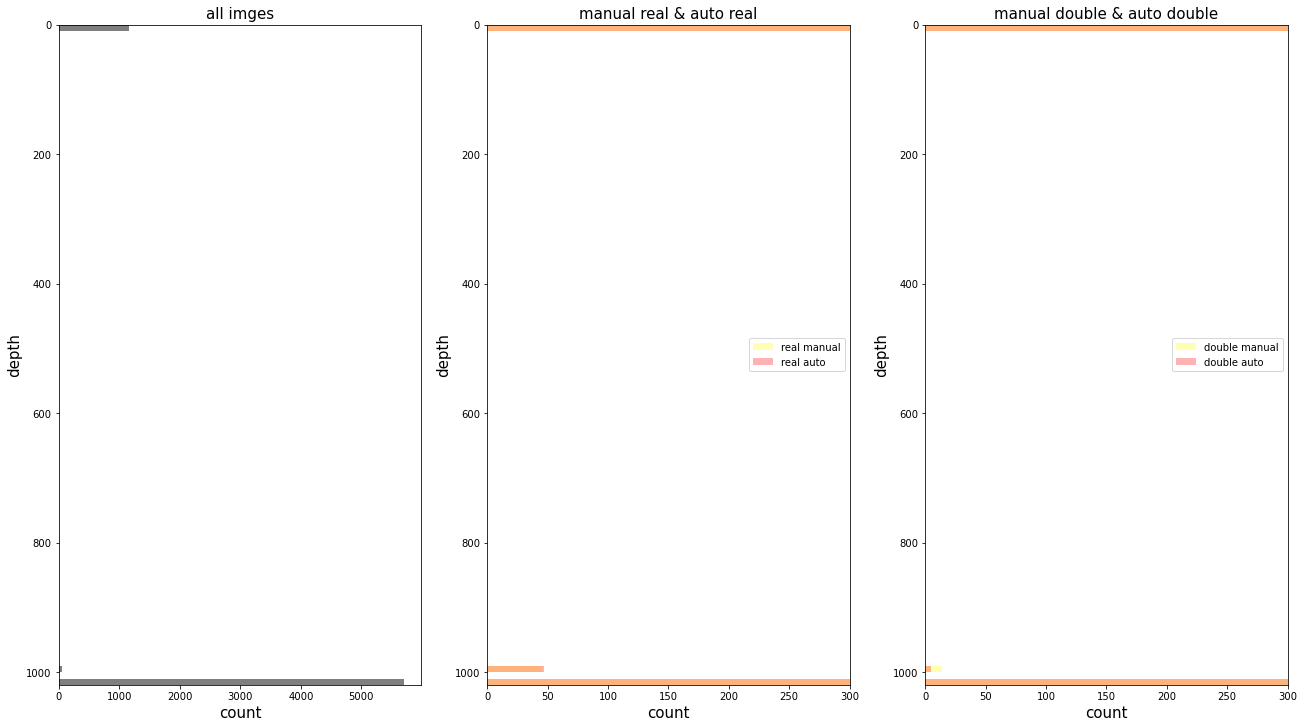

PS106.2-66-1


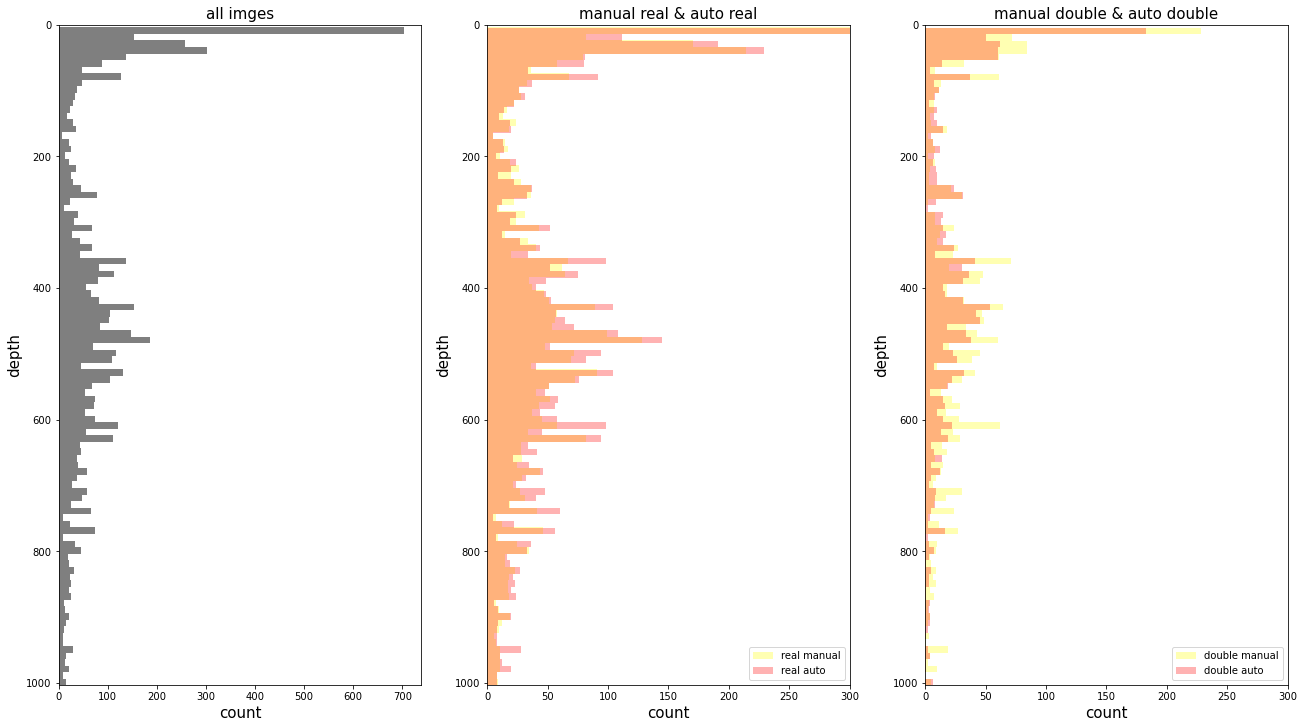

PS93.2-048_9


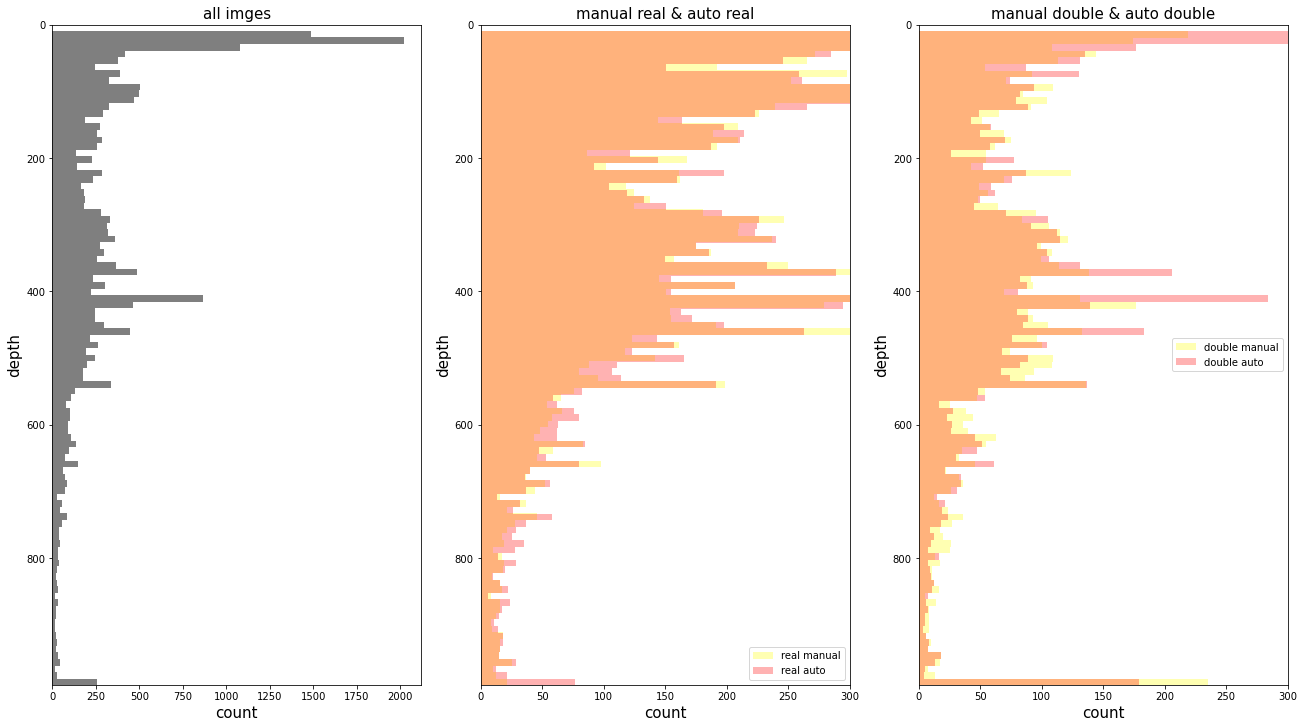

PS99_0053-5


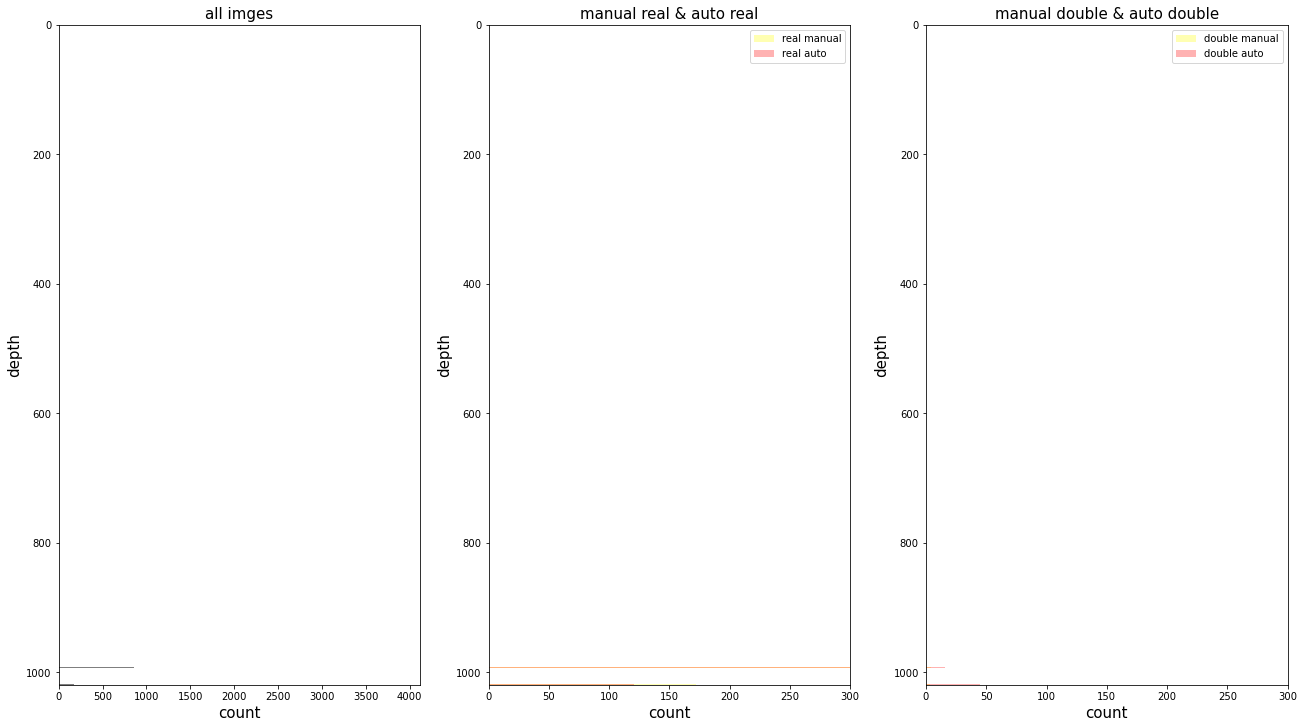

PS106.2-47


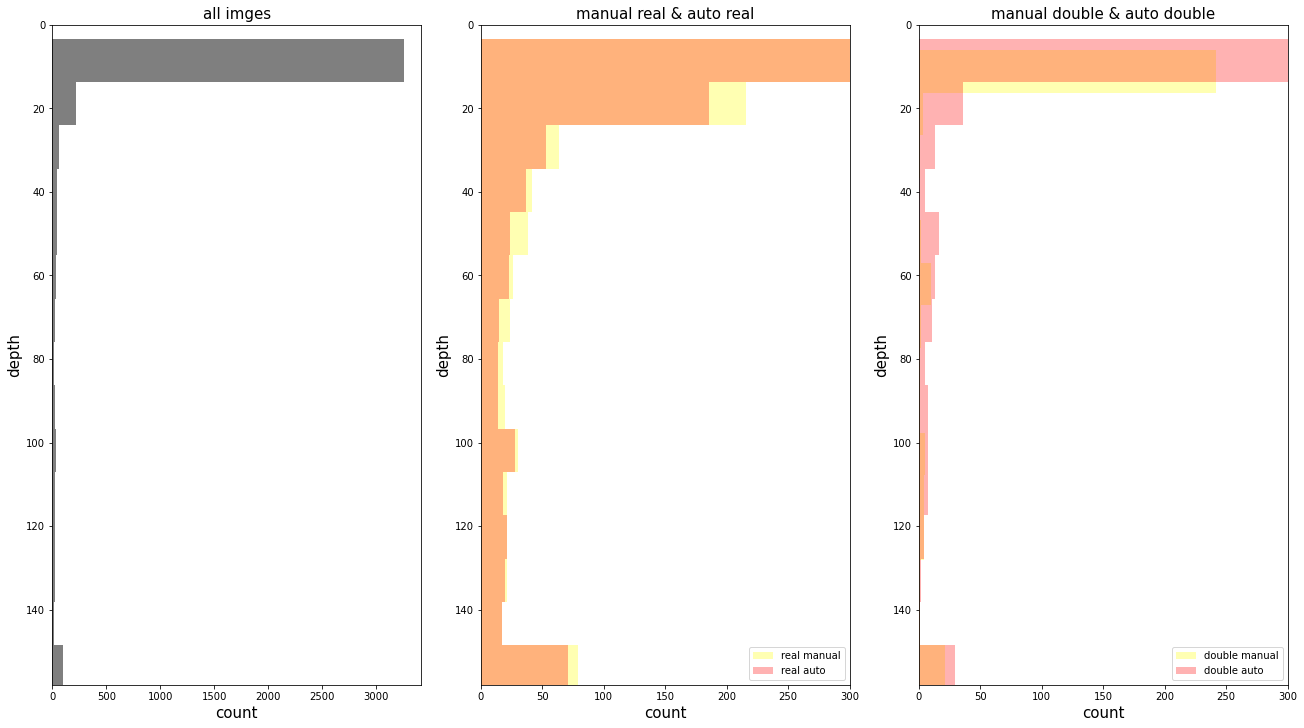

PS106.2-50-3


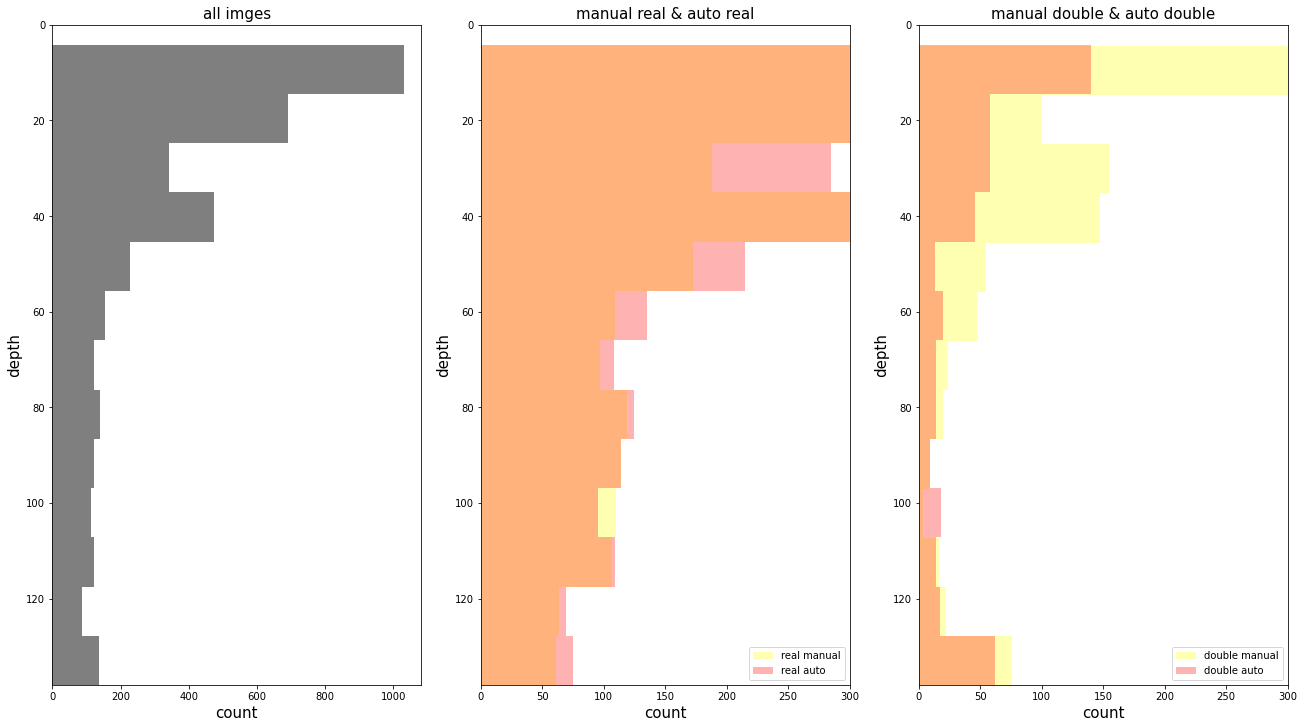

PS107-18


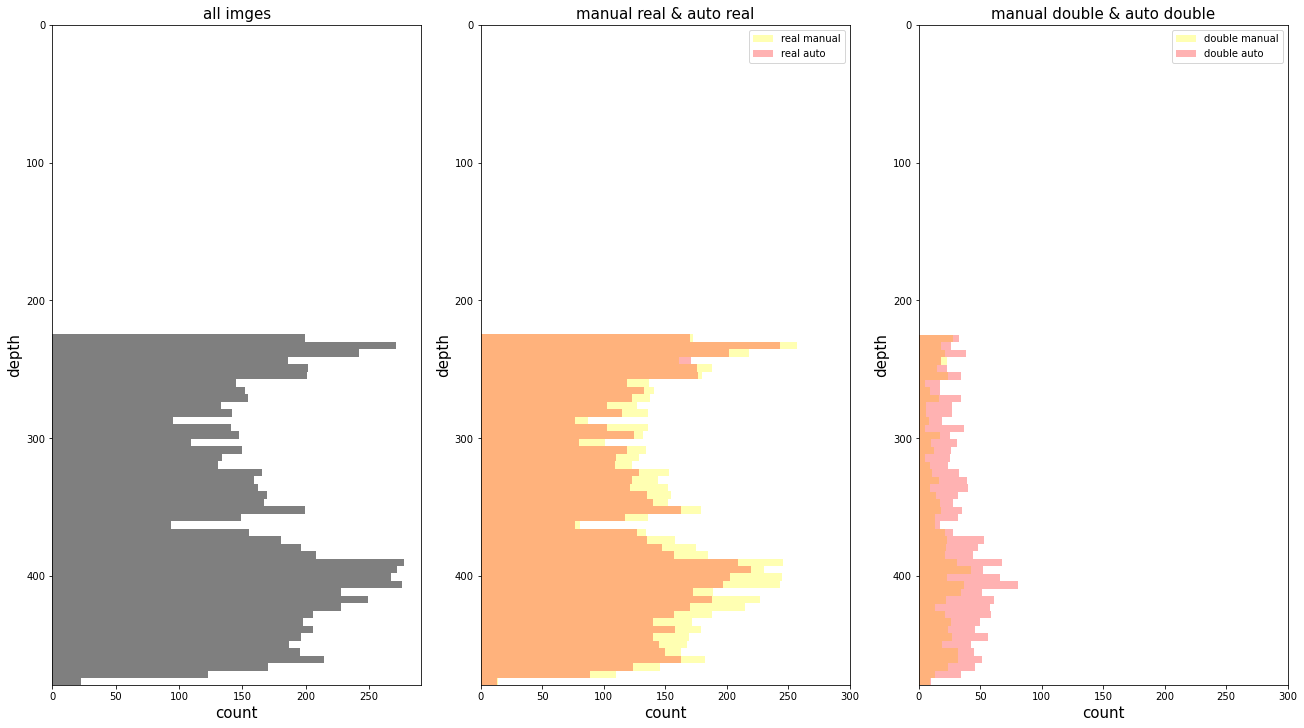

None
PS107-10


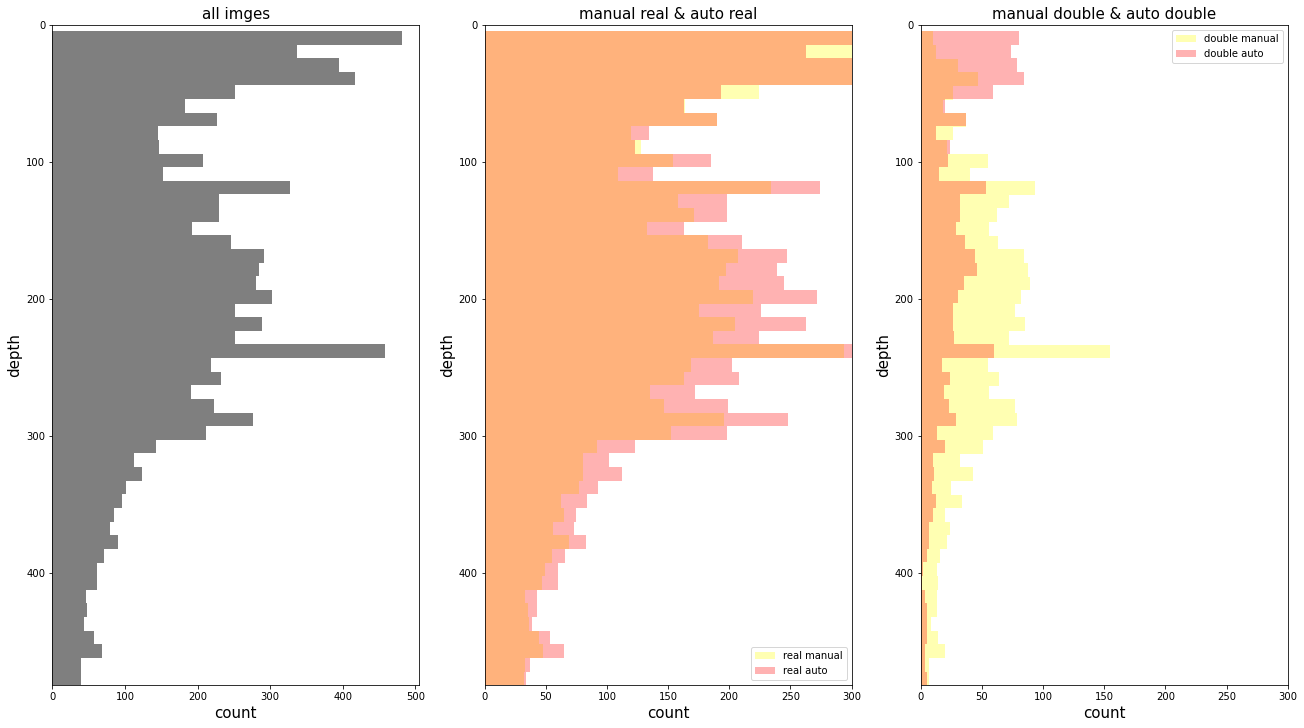

PS94-50-7


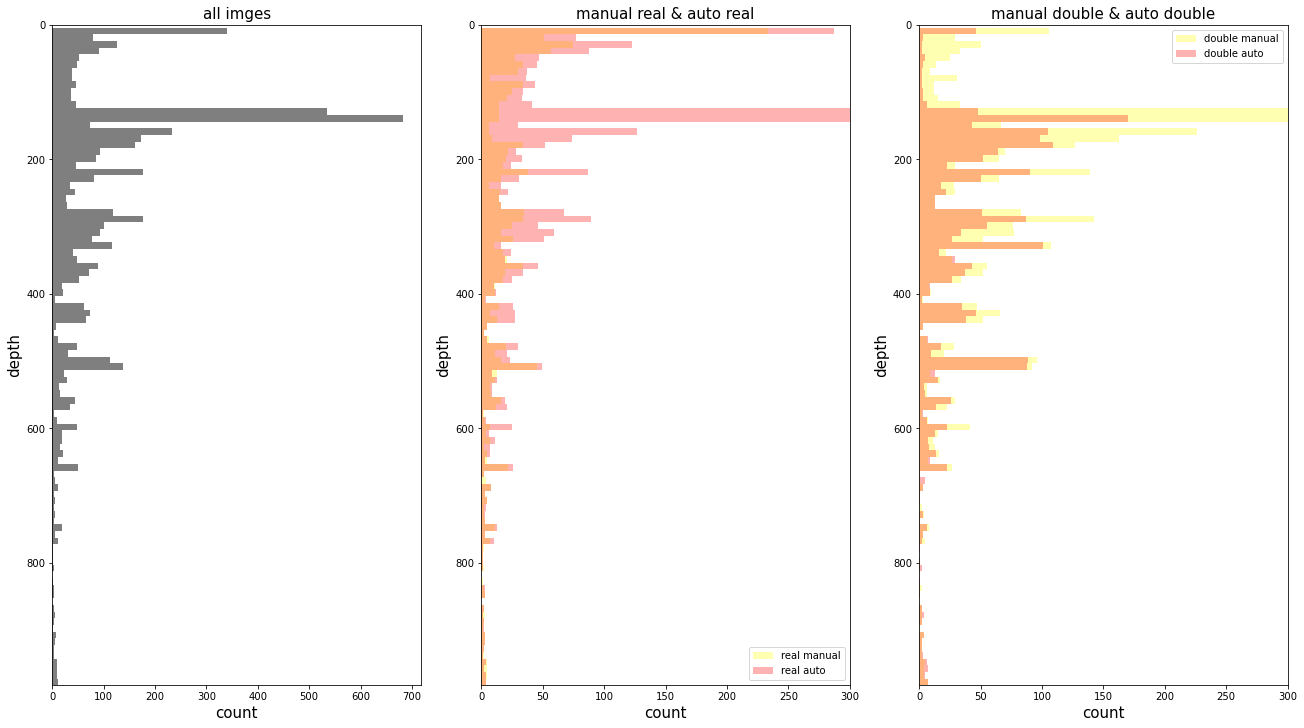

PS122_010


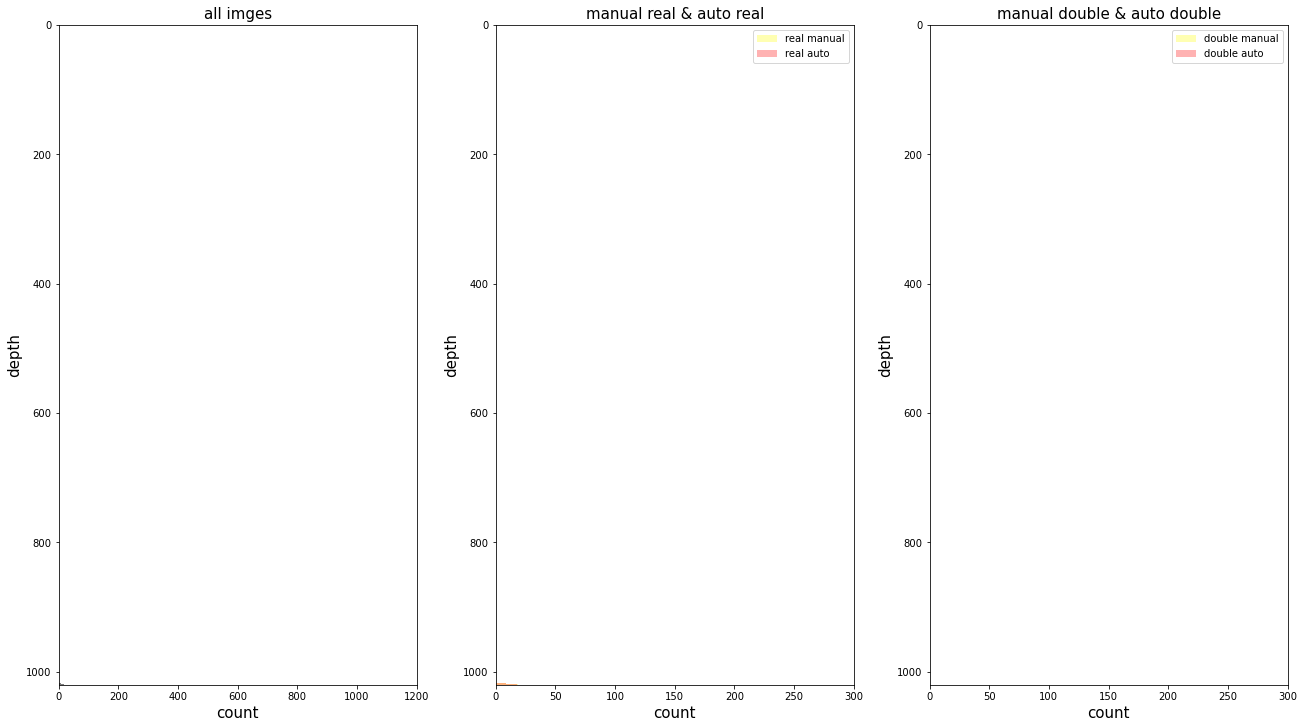

PS122-1-9-62


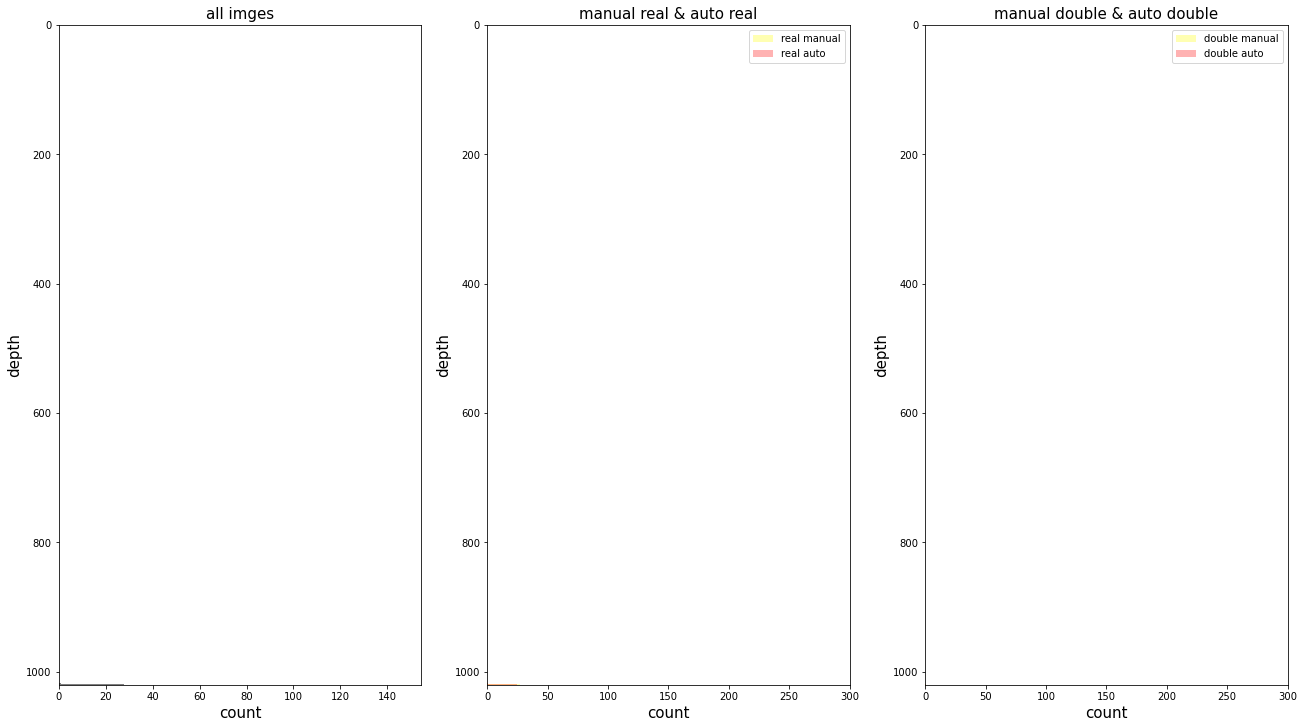

PS107-12


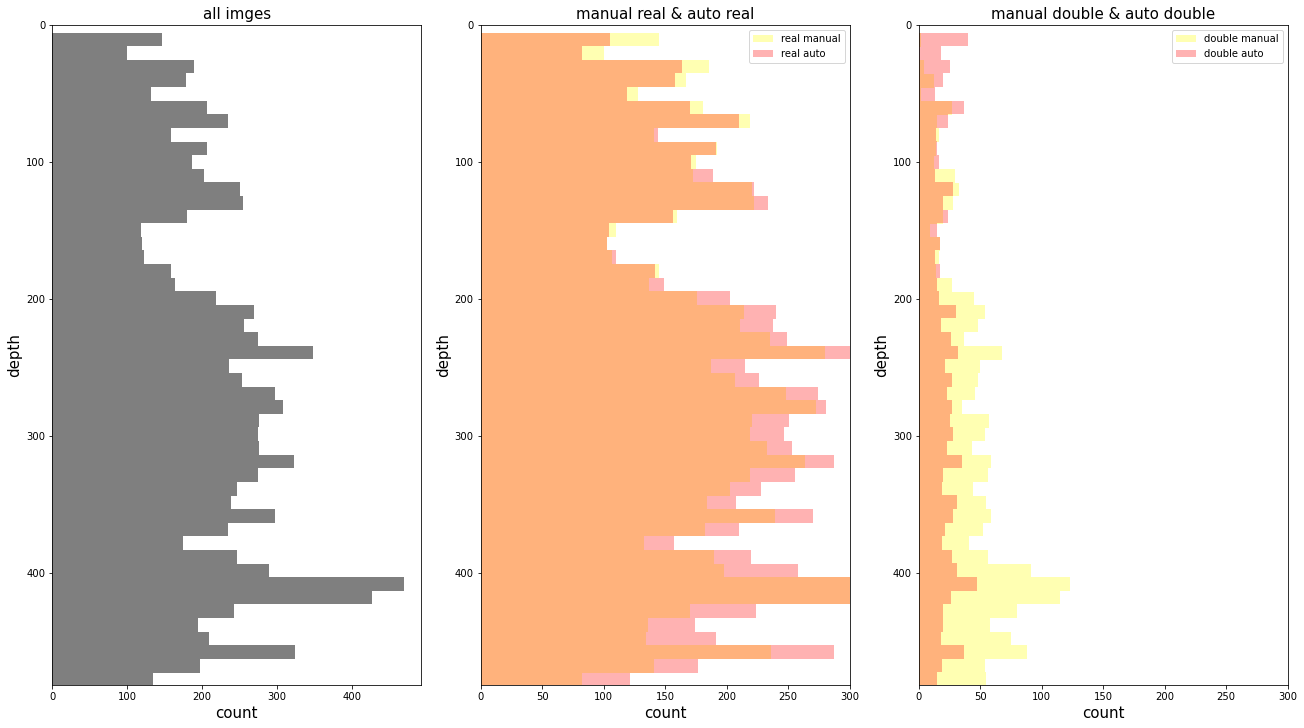

In [87]:
# compare vertical profile of 
for s in station:
    print(s)
    each_zoomie_df = zoomie_df[zoomie_df['object_station']==s]
    if each_zoomie_df.empty == True:
        pass
    else:
        each_zoomie_df = each_zoomie_df.sort_values(by='img_file_name')
        real_mask = ((each_zoomie_df['object_zoomie_state']=='real') & (each_zoomie_df['object_zoomie_deleted']==0))
        time_info = each_zoomie_df['img_file_name'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1] + '  ' + x.split(' ')[3]).to_list()
        time_drop_duplicate = each_zoomie_df['img_file_name'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1] + '  ' + x.split(' ')[3]).drop_duplicates().to_list()
        
        all_obj = each_zoomie_df['object_depth_min']
        man_real = each_zoomie_df['object_depth_min'].loc[(each_zoomie_df['object_zoomie_state']=='real') & (each_zoomie_df['object_zoomie_deleted']==0)]
        man_double = each_zoomie_df['object_depth_min'].loc[(each_zoomie_df['object_zoomie_state']=='double') | (each_zoomie_df['object_zoomie_deleted']==1)]

        ########
        # testing
        each_zoomie_df['x'] = pd.to_numeric(each_zoomie_df['img_file_name'].apply(lambda x: int(x.split(' ')[-2])))
        each_zoomie_df['y'] = pd.to_numeric(each_zoomie_df['img_file_name'].apply(lambda x: int(x.split(' ')[-1].split('.')[0])))
        
        for t in range(0, len(time_drop_duplicate)-1):
            pic_df_before = each_zoomie_df[each_zoomie_df['img_file_name'].str.contains(time_drop_duplicate[t])]
            pic_df_after = each_zoomie_df[each_zoomie_df['img_file_name'].str.contains(time_drop_duplicate[t+1])]
            for b_idx, b_row in pic_df_before.iterrows():

                for a_idx, a_row in pic_df_after.iterrows():
                    dist = calDist(b_row['x'], b_row['y'], a_row['x'], a_row['y'])
                    x_dif = abs(b_row['x']-a_row['x'])
                    y_dif = abs(b_row['y']-a_row['y'])
                    pixel_dif = abs(b_row['object_area_px']-a_row['object_area_px'])
                    
                    
                dist_num = [100, 300, 500, 800, 1000, 1300, 1500, 1800, 2300, 2500, 3000]
                x_dif_num = [800, 900, 1000, 1200, 1400, 1600, 1800, 2000]
                for d in x_dif_num:
                    if (x_dif < d)& (pixel_dif<6000)&(x_dif > y_dif): # condition 1. any(x <= d for x in dist_each) 2. (x_dif > y_dif) 3. & (pixel_dif<6000)
                        each_zoomie_df.loc[b_idx, 'new_estimate_%s' %(d,)] = 'double' # add column 'new double' for suspiscous double image
                    else:
                        each_zoomie_df.loc[b_idx, 'new_estimate_%s' %(d,)] = 'real' # add column 'new real' for suspiscous real image

        
        auto_real = each_zoomie_df['object_depth_min'].loc[each_zoomie_df['new_estimate_1400']=='real']
        auto_double = each_zoomie_df['object_depth_min'].loc[each_zoomie_df['new_estimate_1400']=='double']
        
        ##########
        # plotting
        
        
        fig = plt.figure(constrained_layout=True, figsize =(18, 10))
        gs = fig.add_gridspec(1, 3)
        
        ax1 = fig.add_subplot(gs[0,0])
        ax1.set_title('all imges', fontsize=15)
        ax1.hist(all_obj, bins=int(max(all_obj)/10), alpha=0.5, orientation='horizontal', color='black')
        ax1.set_ylabel('depth', fontsize=15)
        ax1.set_xlabel('count', fontsize=15)
        ax1.set_ylim(0, int(max(all_obj)))
        ax1.invert_yaxis()
        
        
        ax2 = fig.add_subplot(gs[0,1])
        ax2.set_title('manual real & auto real', fontsize=15)
        ax2.hist(man_real, bins=int(max(man_real)/10), alpha=0.3, color='yellow', label='real manual', orientation='horizontal')
        ax2.hist(auto_real, bins=int(max(auto_real)/10), alpha=0.3, color='red', label='real auto', orientation='horizontal')
        ax2.set_ylabel('depth', fontsize=15)
        ax2.set_xlabel('count', fontsize=15)
        ax2.legend()
        ax2.set_xlim(0, 300)
        ax2.set_ylim(0, int(max(all_obj)))
        ax2.invert_yaxis()
        
           
        ax3 = fig.add_subplot(gs[0,2])
        ax3.set_title('manual double & auto double', fontsize=15)
        ax3.hist(man_double, bins=int(max(man_double)/10), alpha=0.3, color='yellow', label='double manual', orientation='horizontal')
        ax3.hist(auto_double, bins=int(max(auto_double)/10), alpha=0.3, color='red', label='double auto', orientation='horizontal')
        ax3.set_ylabel('depth', fontsize=15)
        ax3.set_xlabel('count', fontsize=15)
        ax3.legend()
        ax3.set_xlim(0, 300)
        ax3.set_ylim(0, int(max(all_obj)))
        ax3.invert_yaxis()
        
        
        plt.show()
        plt.close()

PS114-04-2


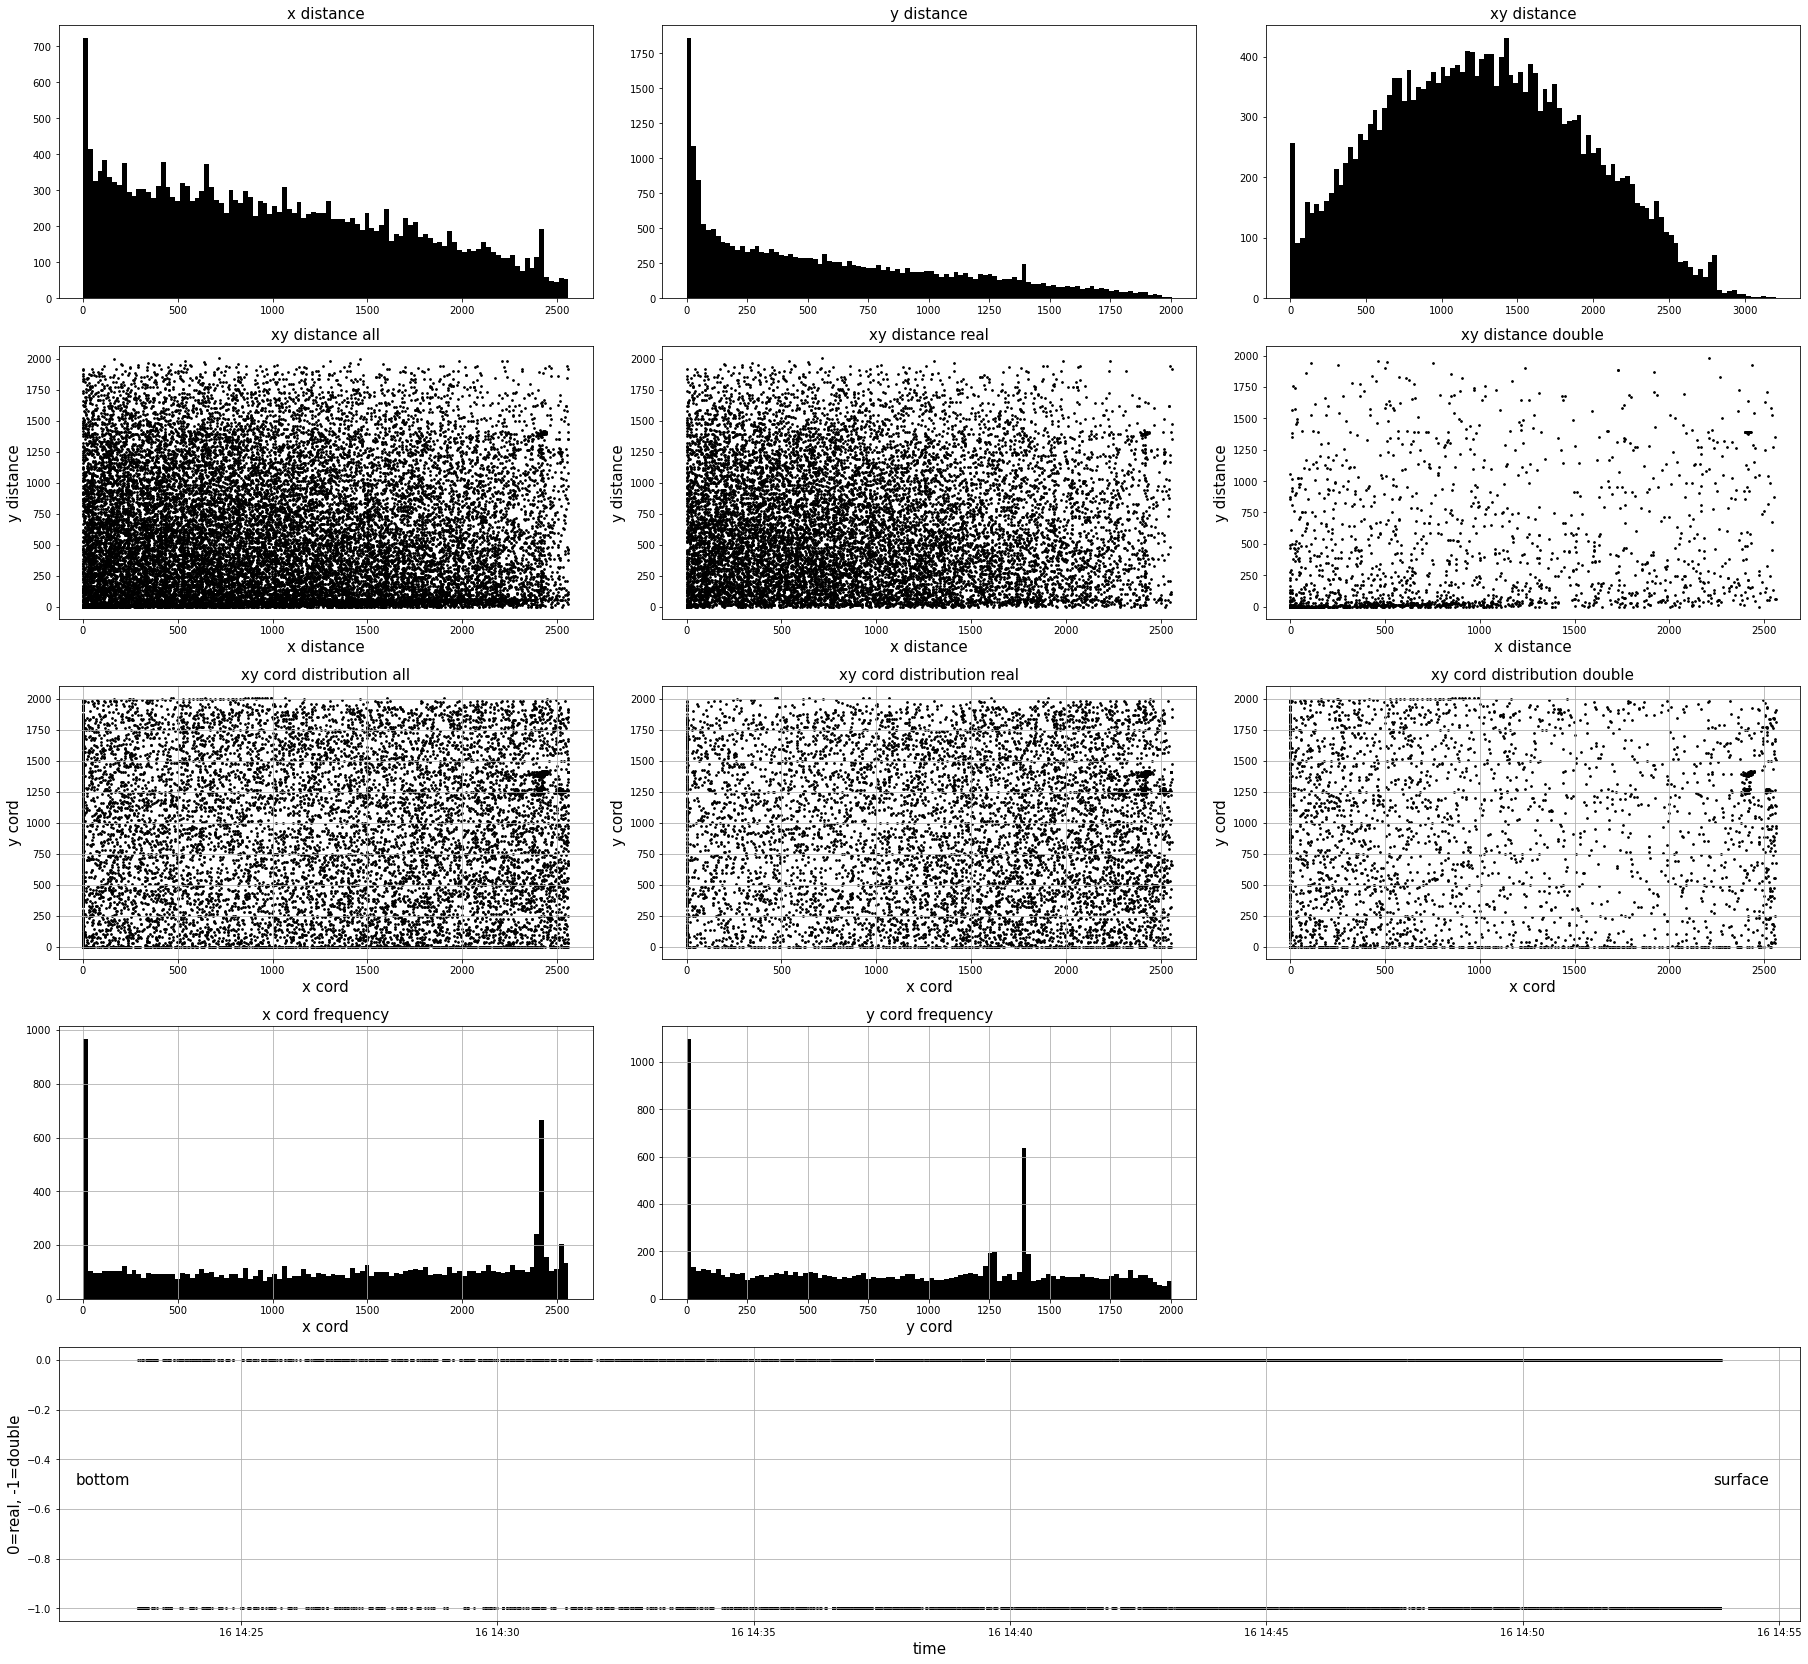

PS94-91-4


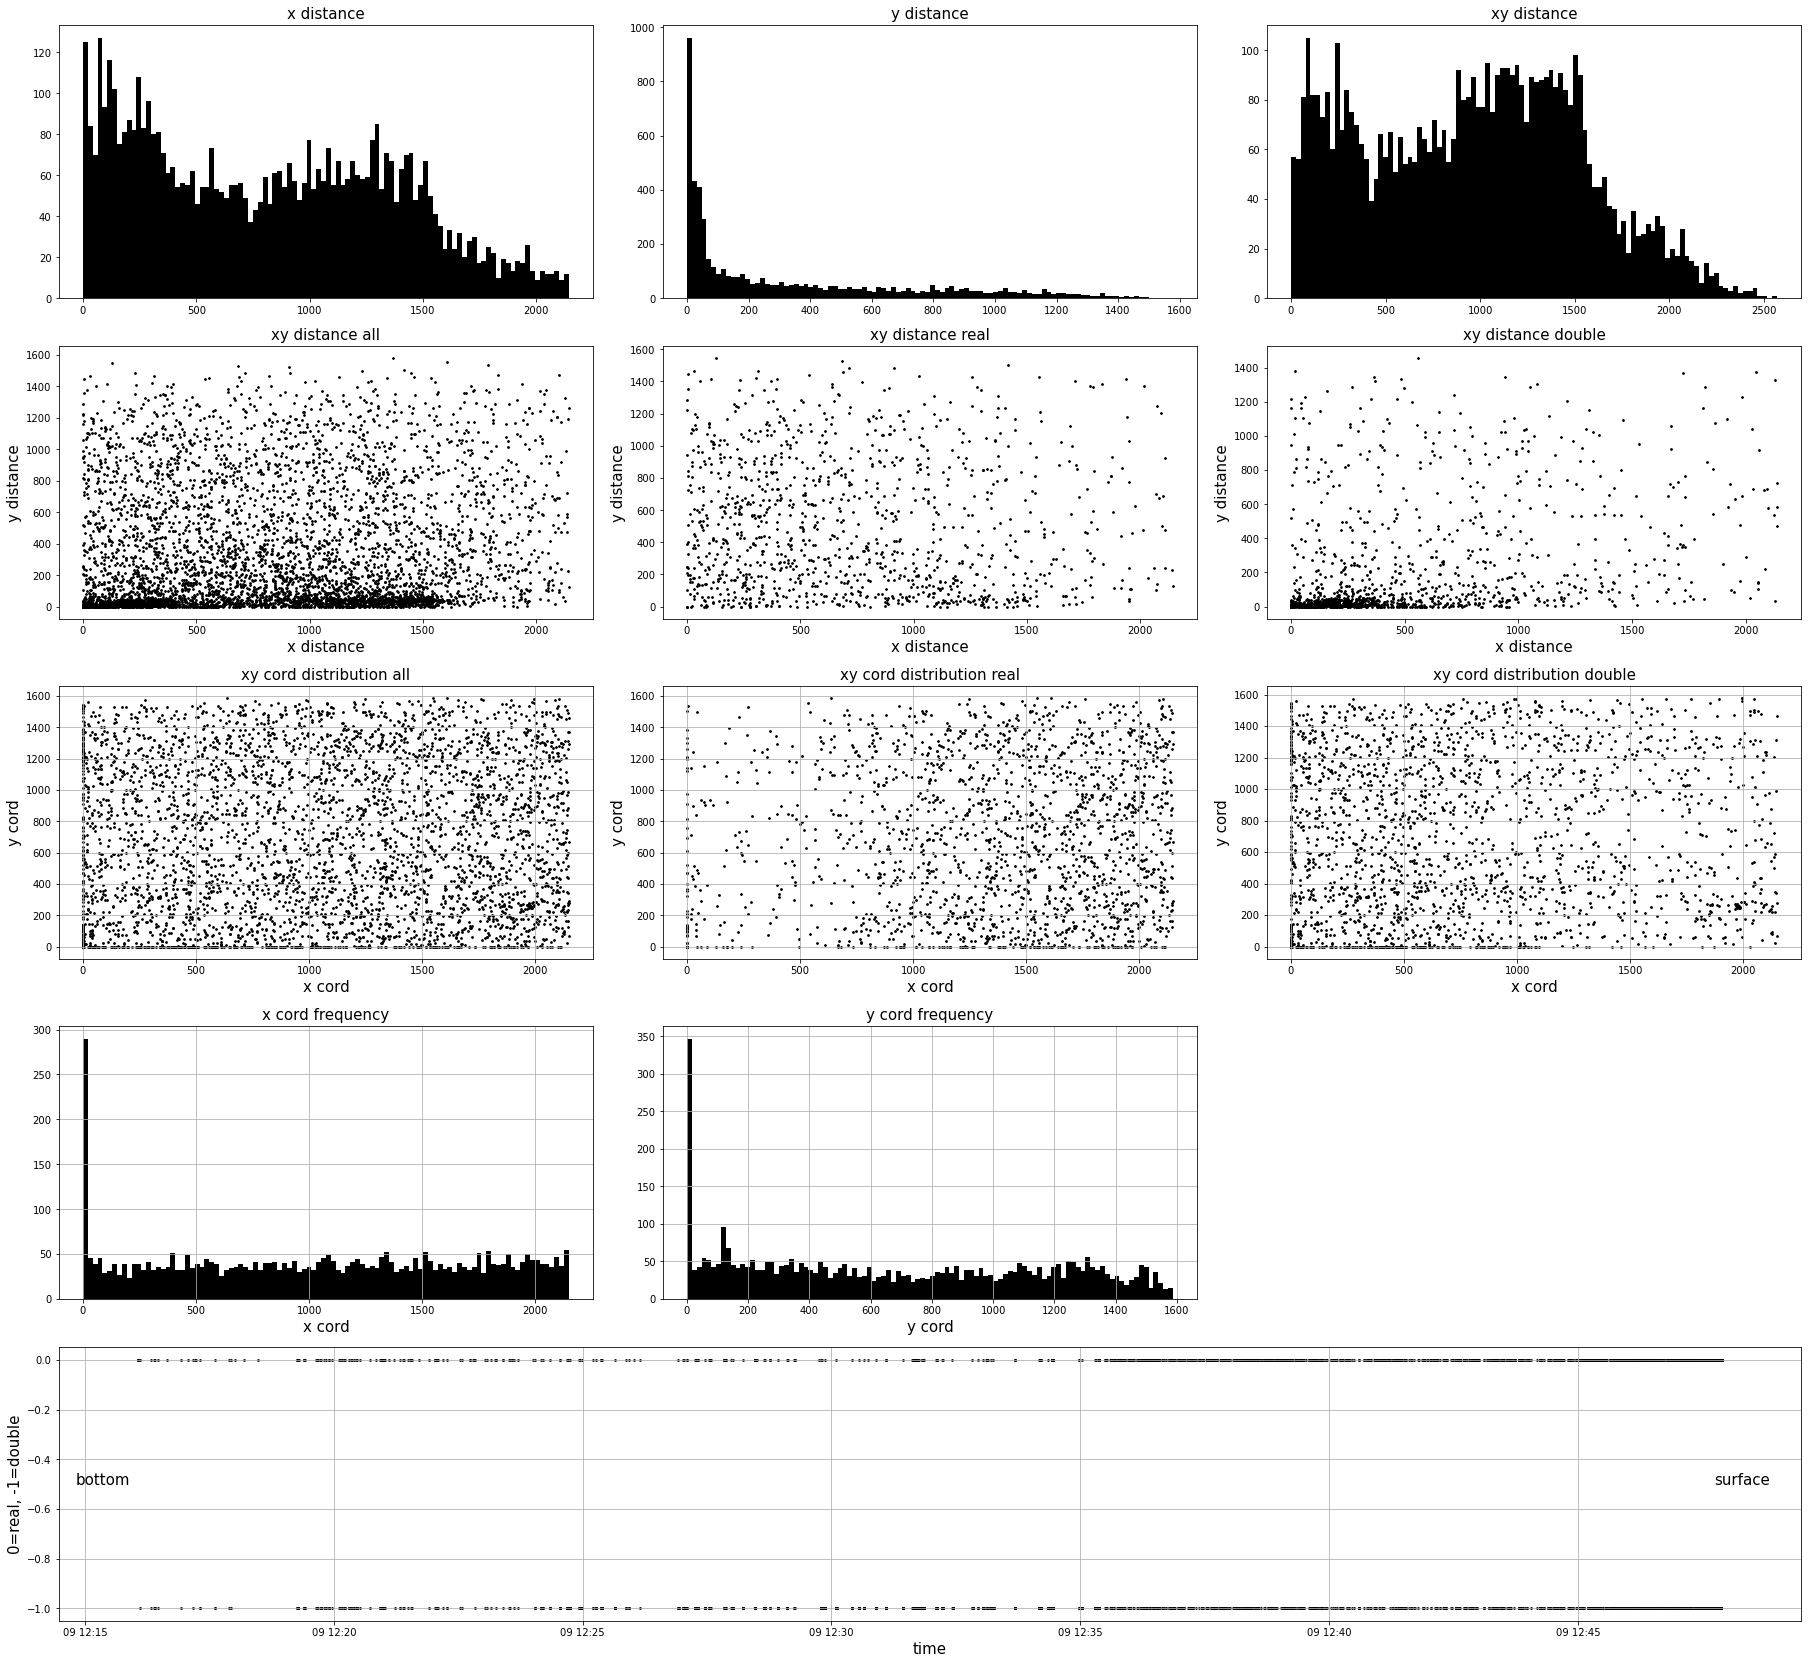

PS122-1_6-86


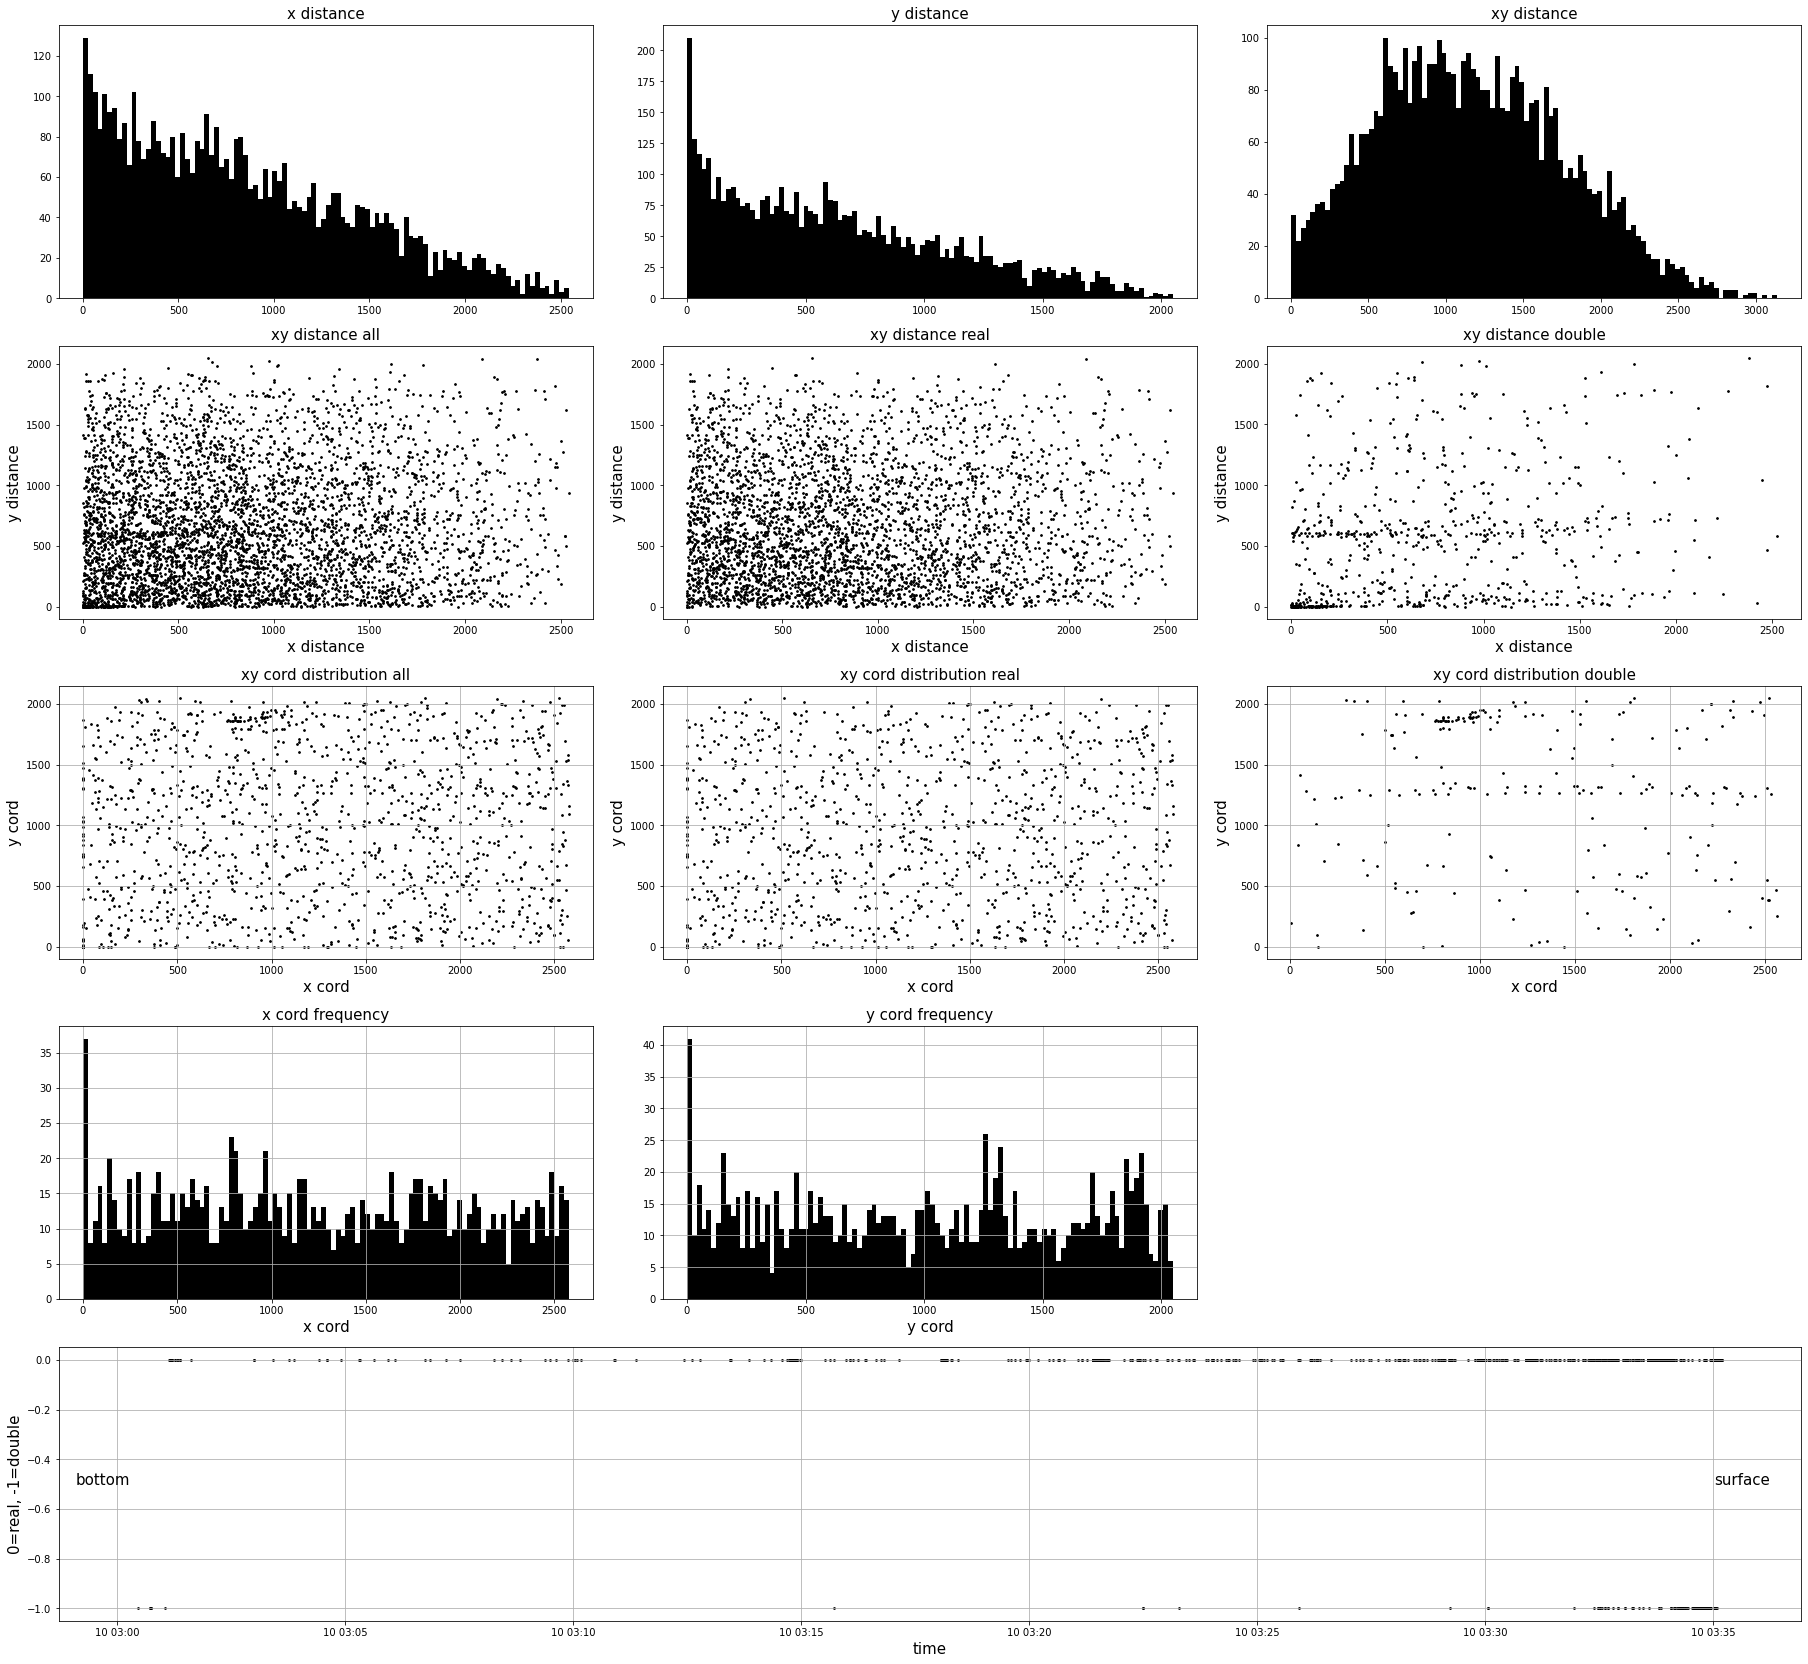

PS106.2-69-6


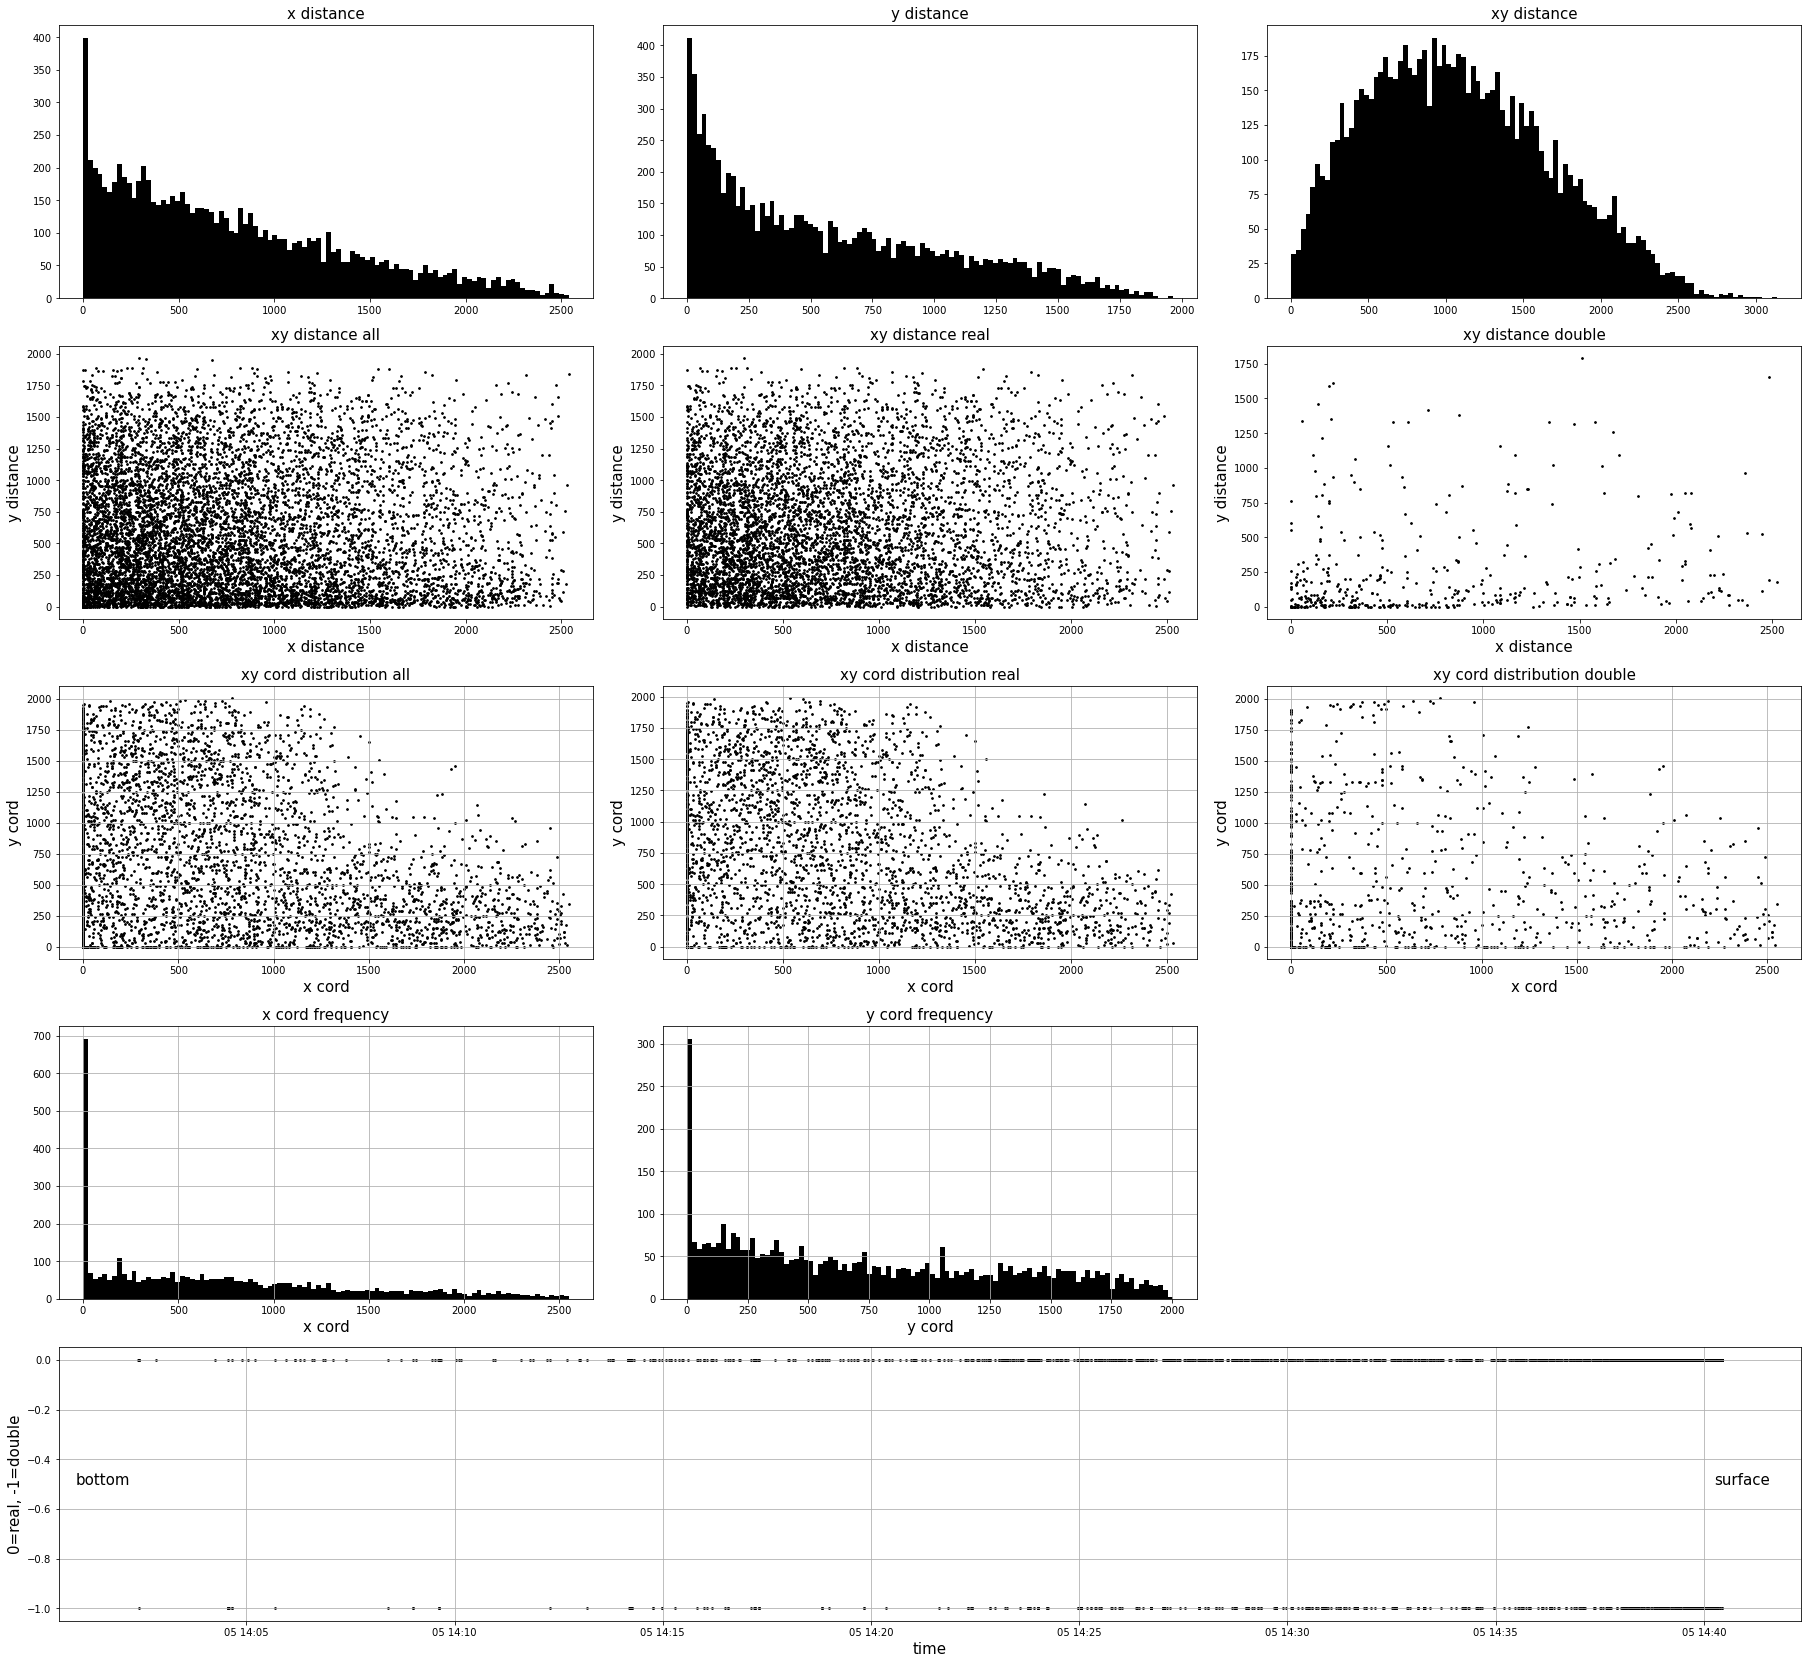

PS107-16


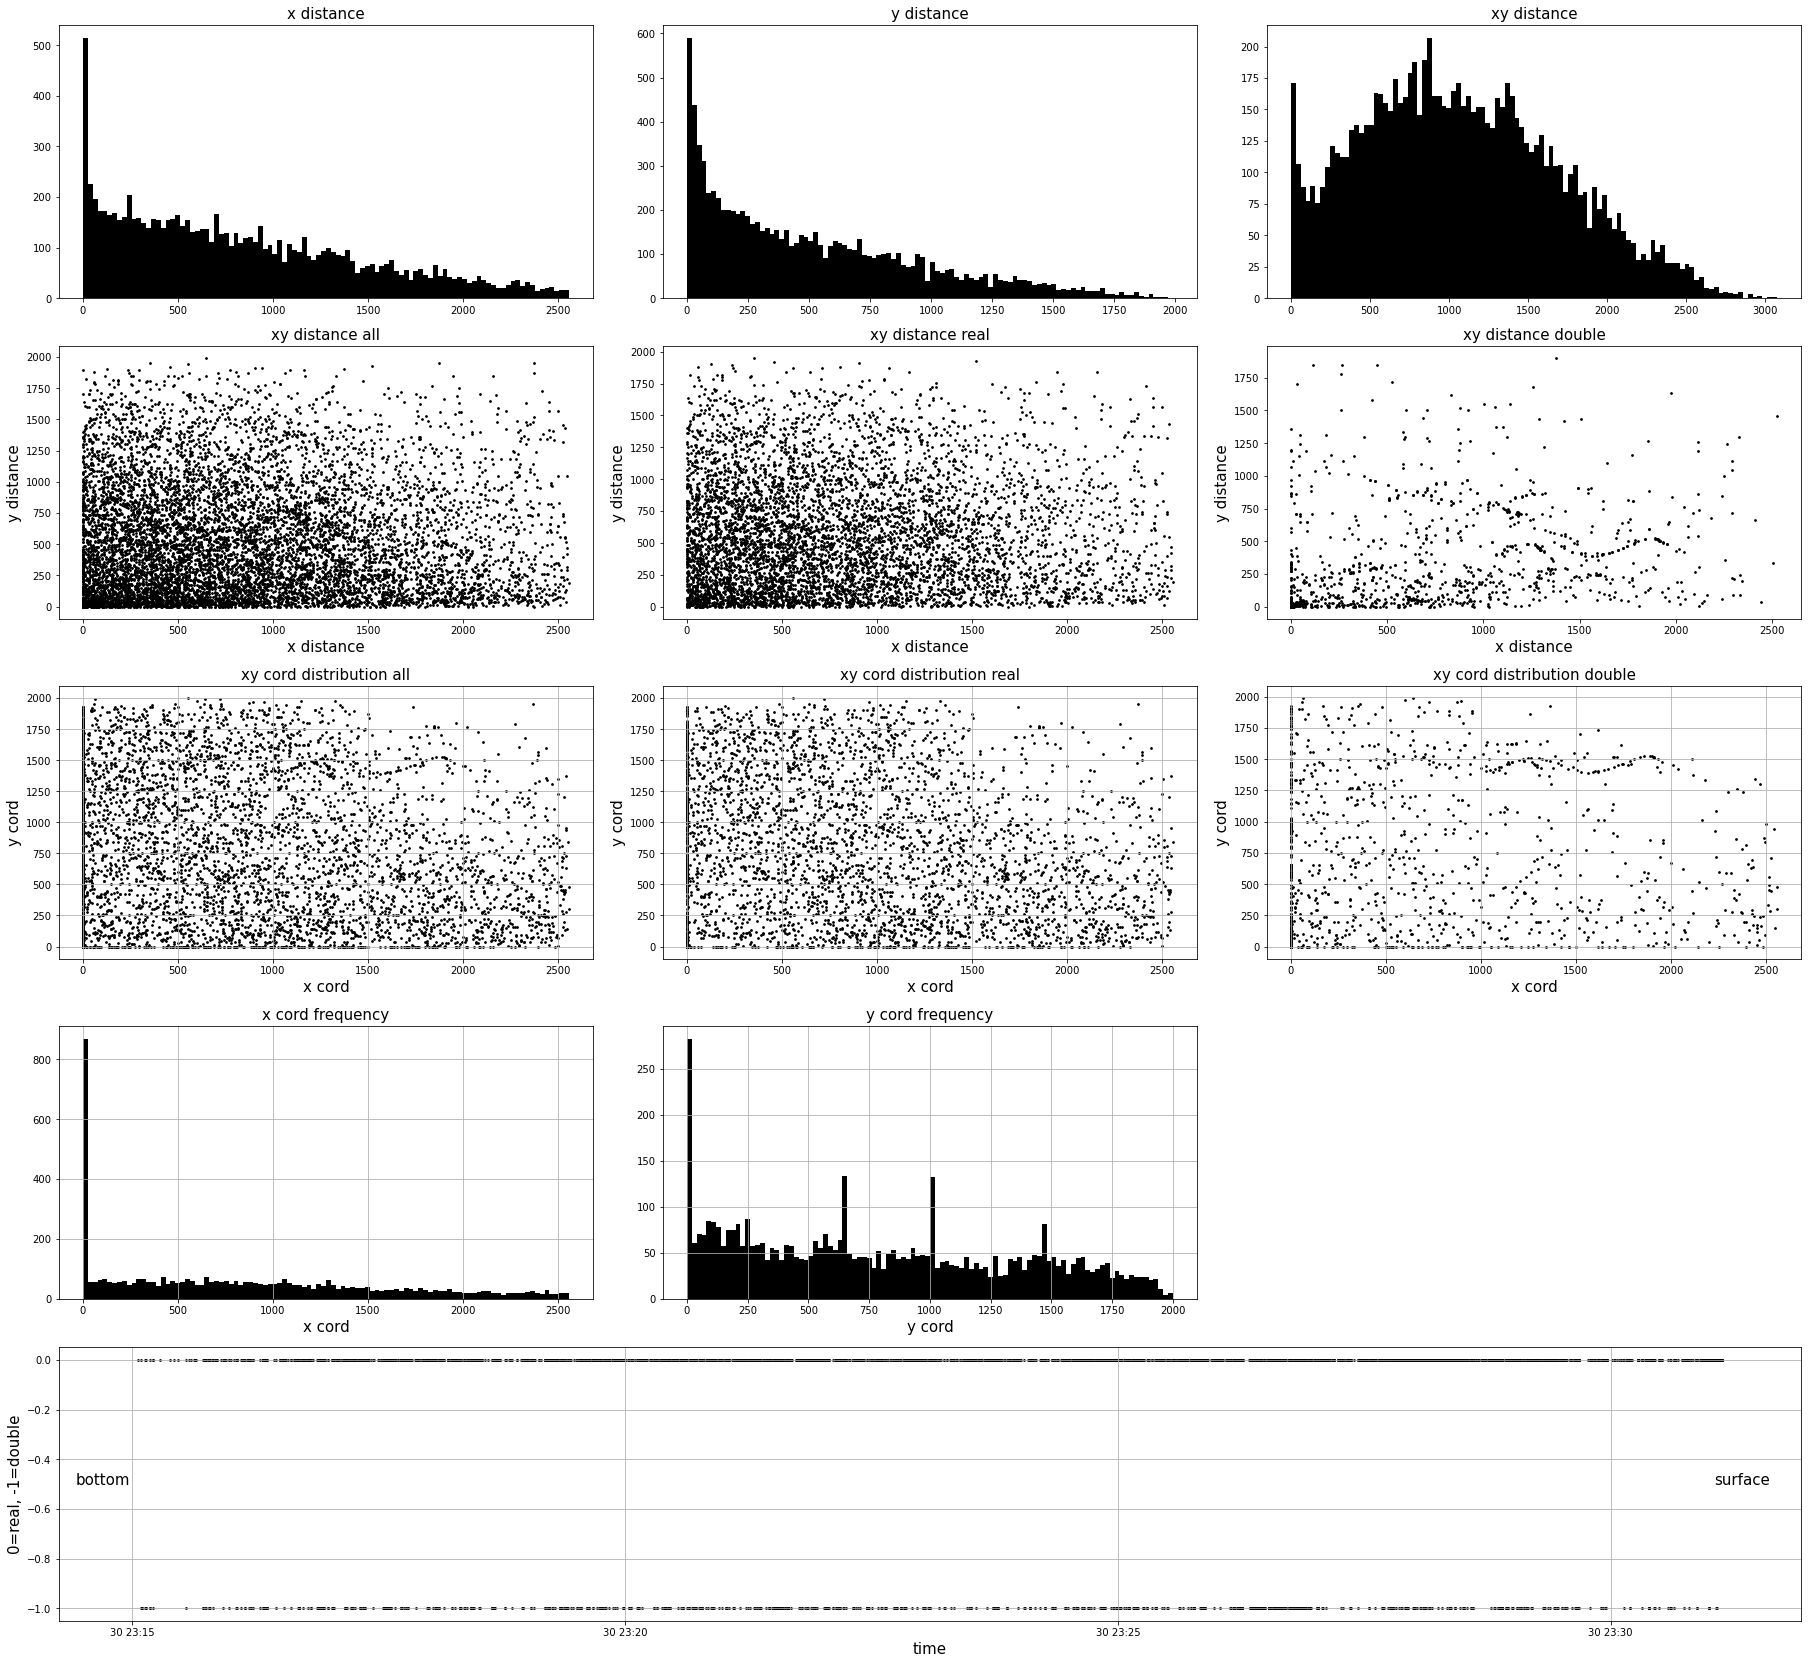

PS94-81-6


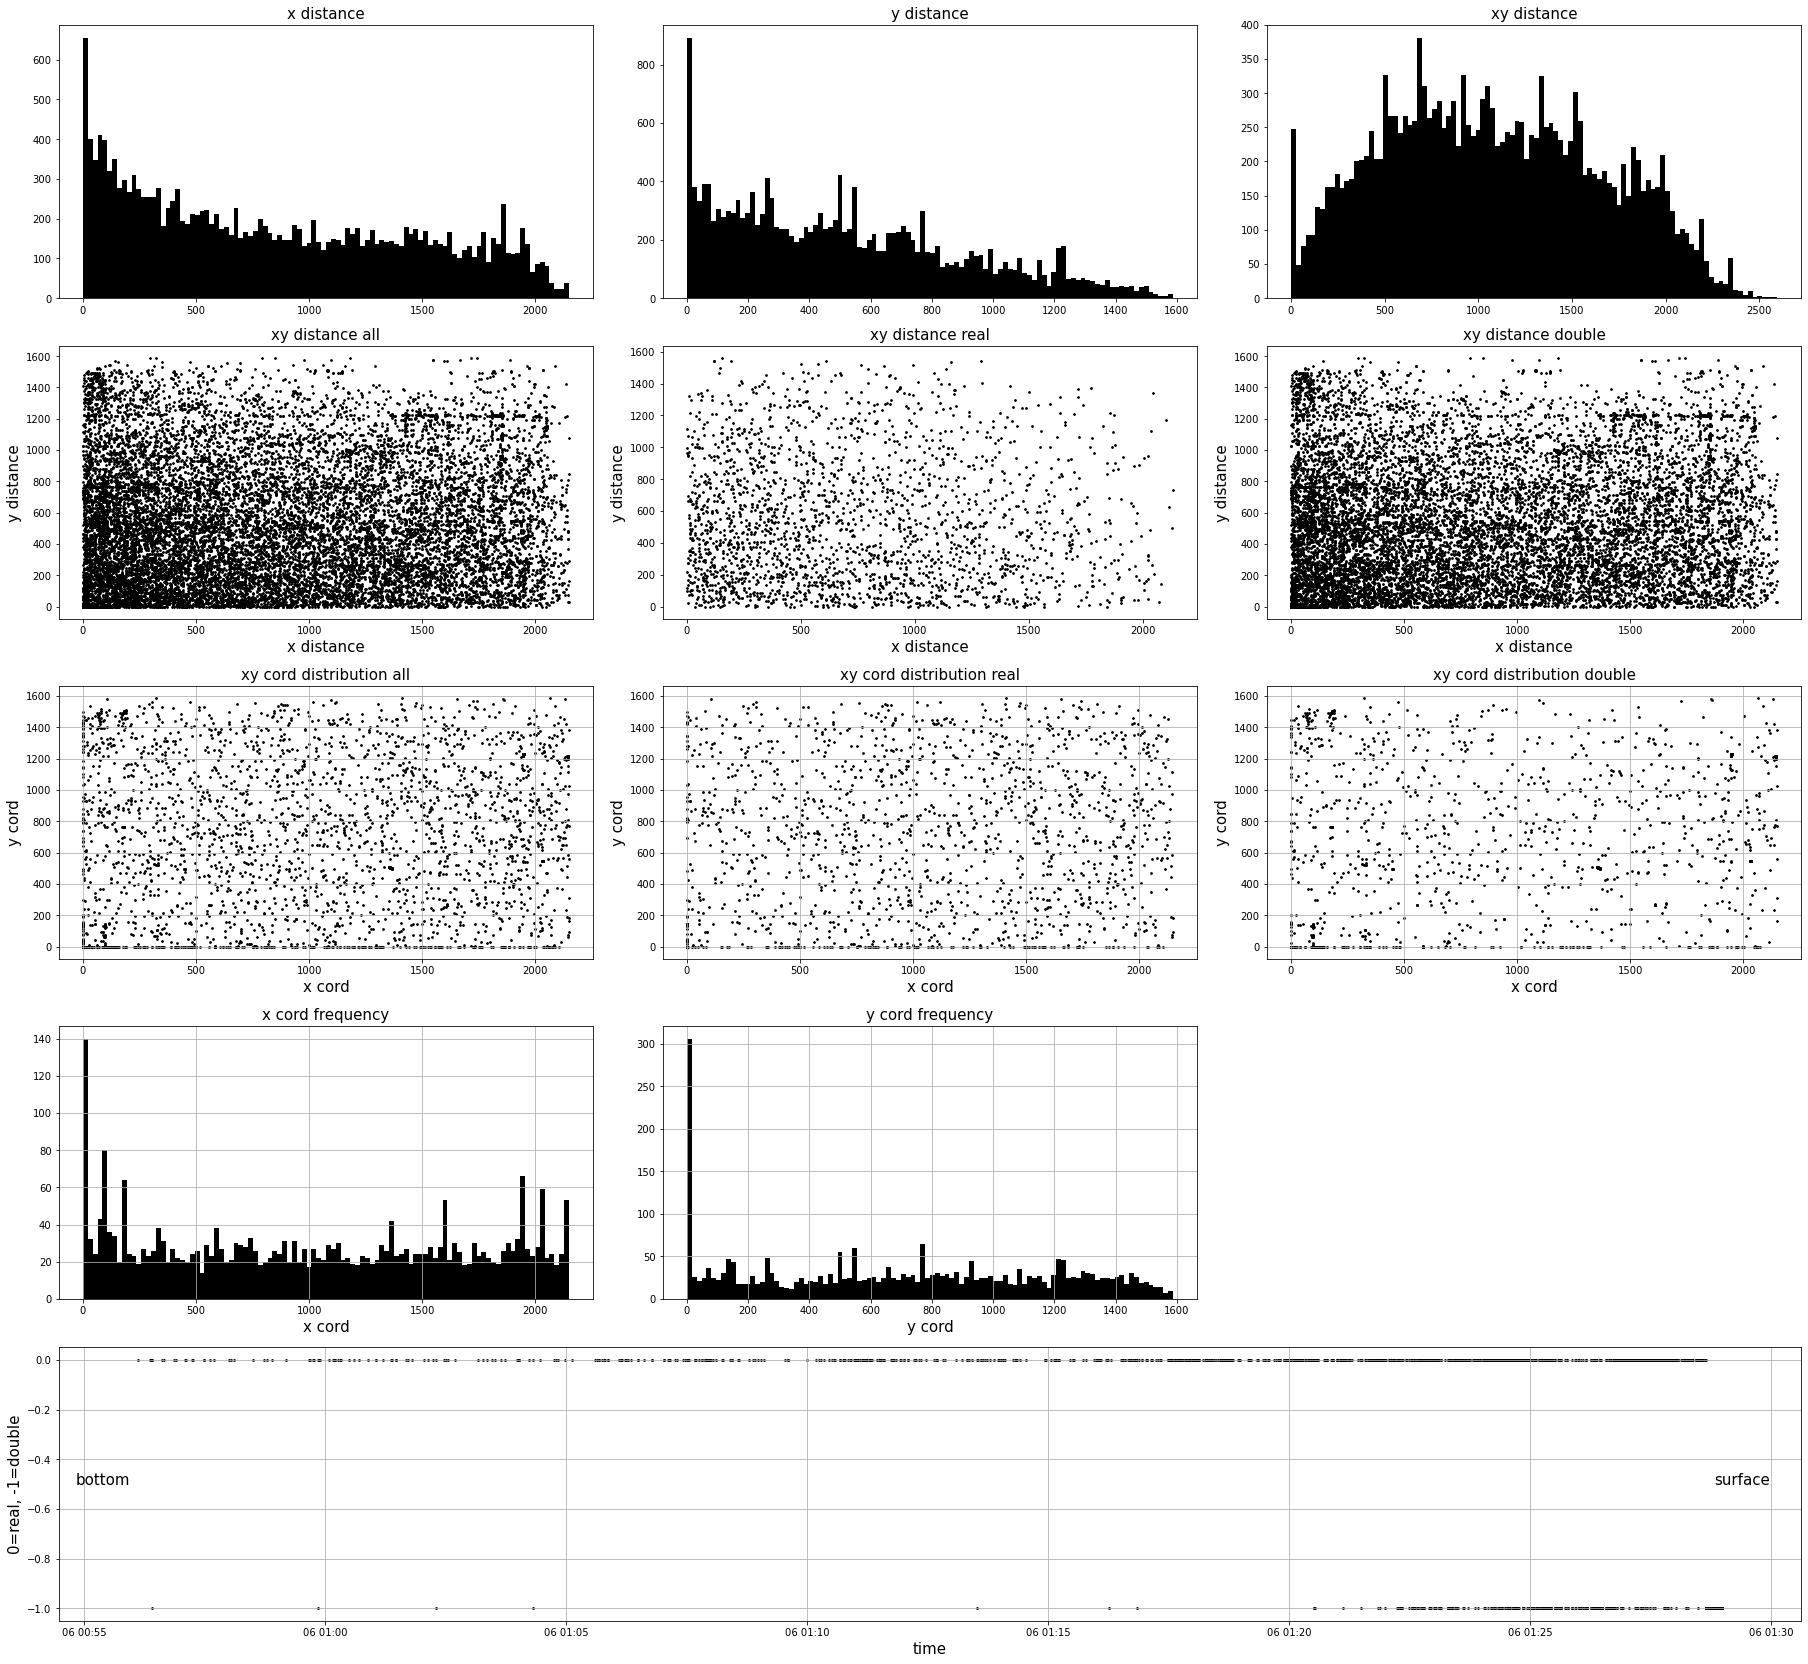

PS106.2-68-4


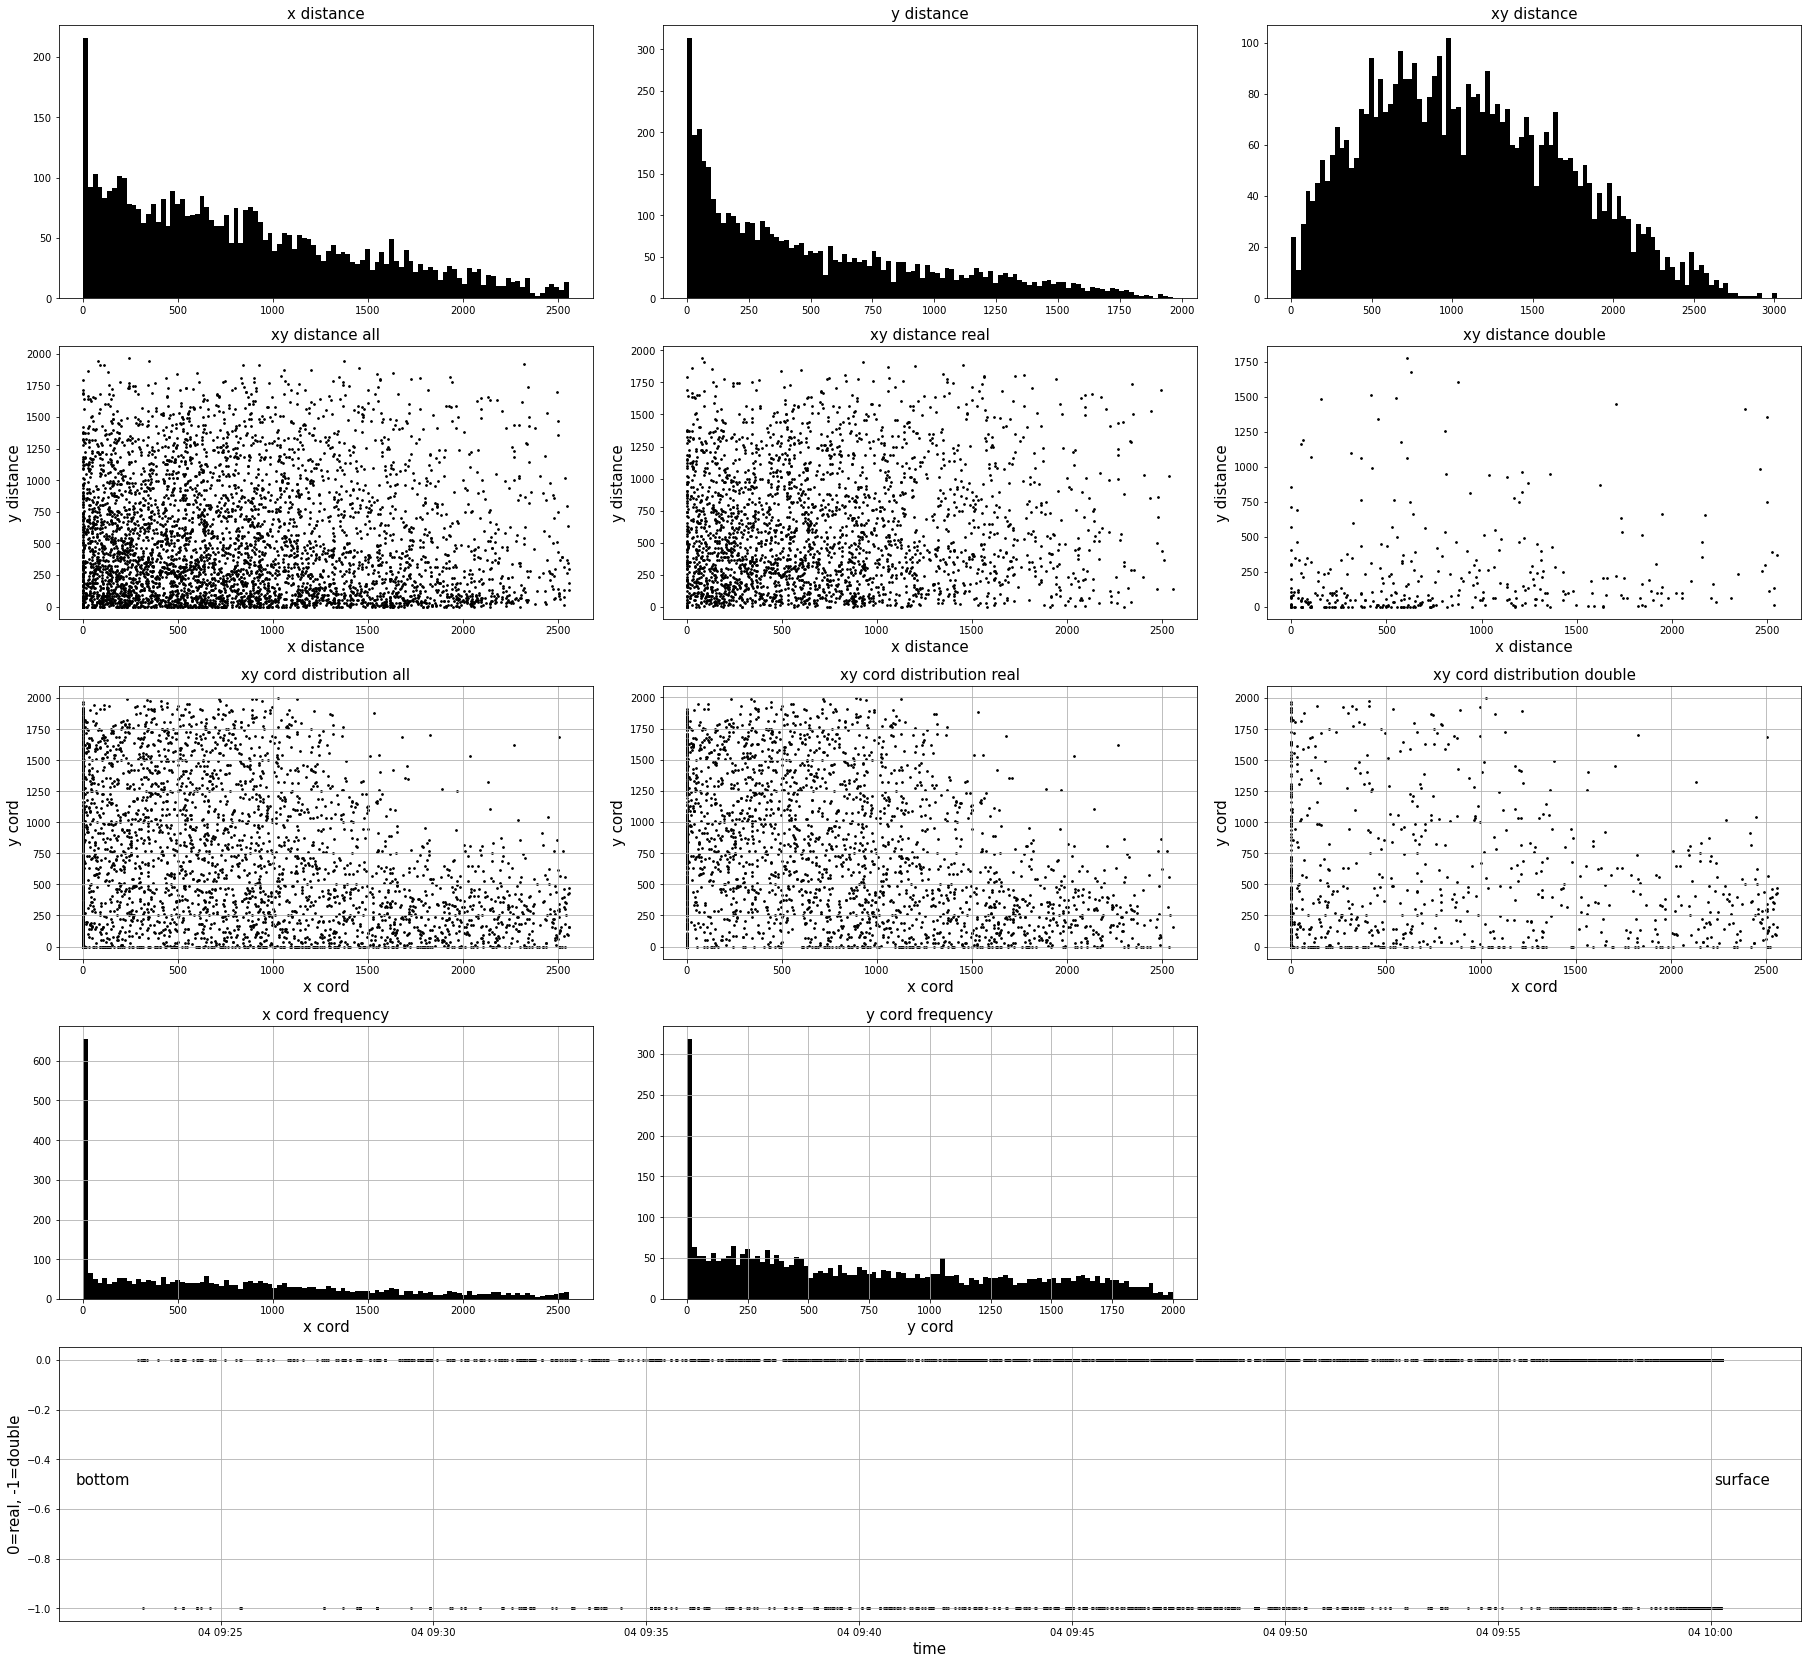

PS122-1-7-57


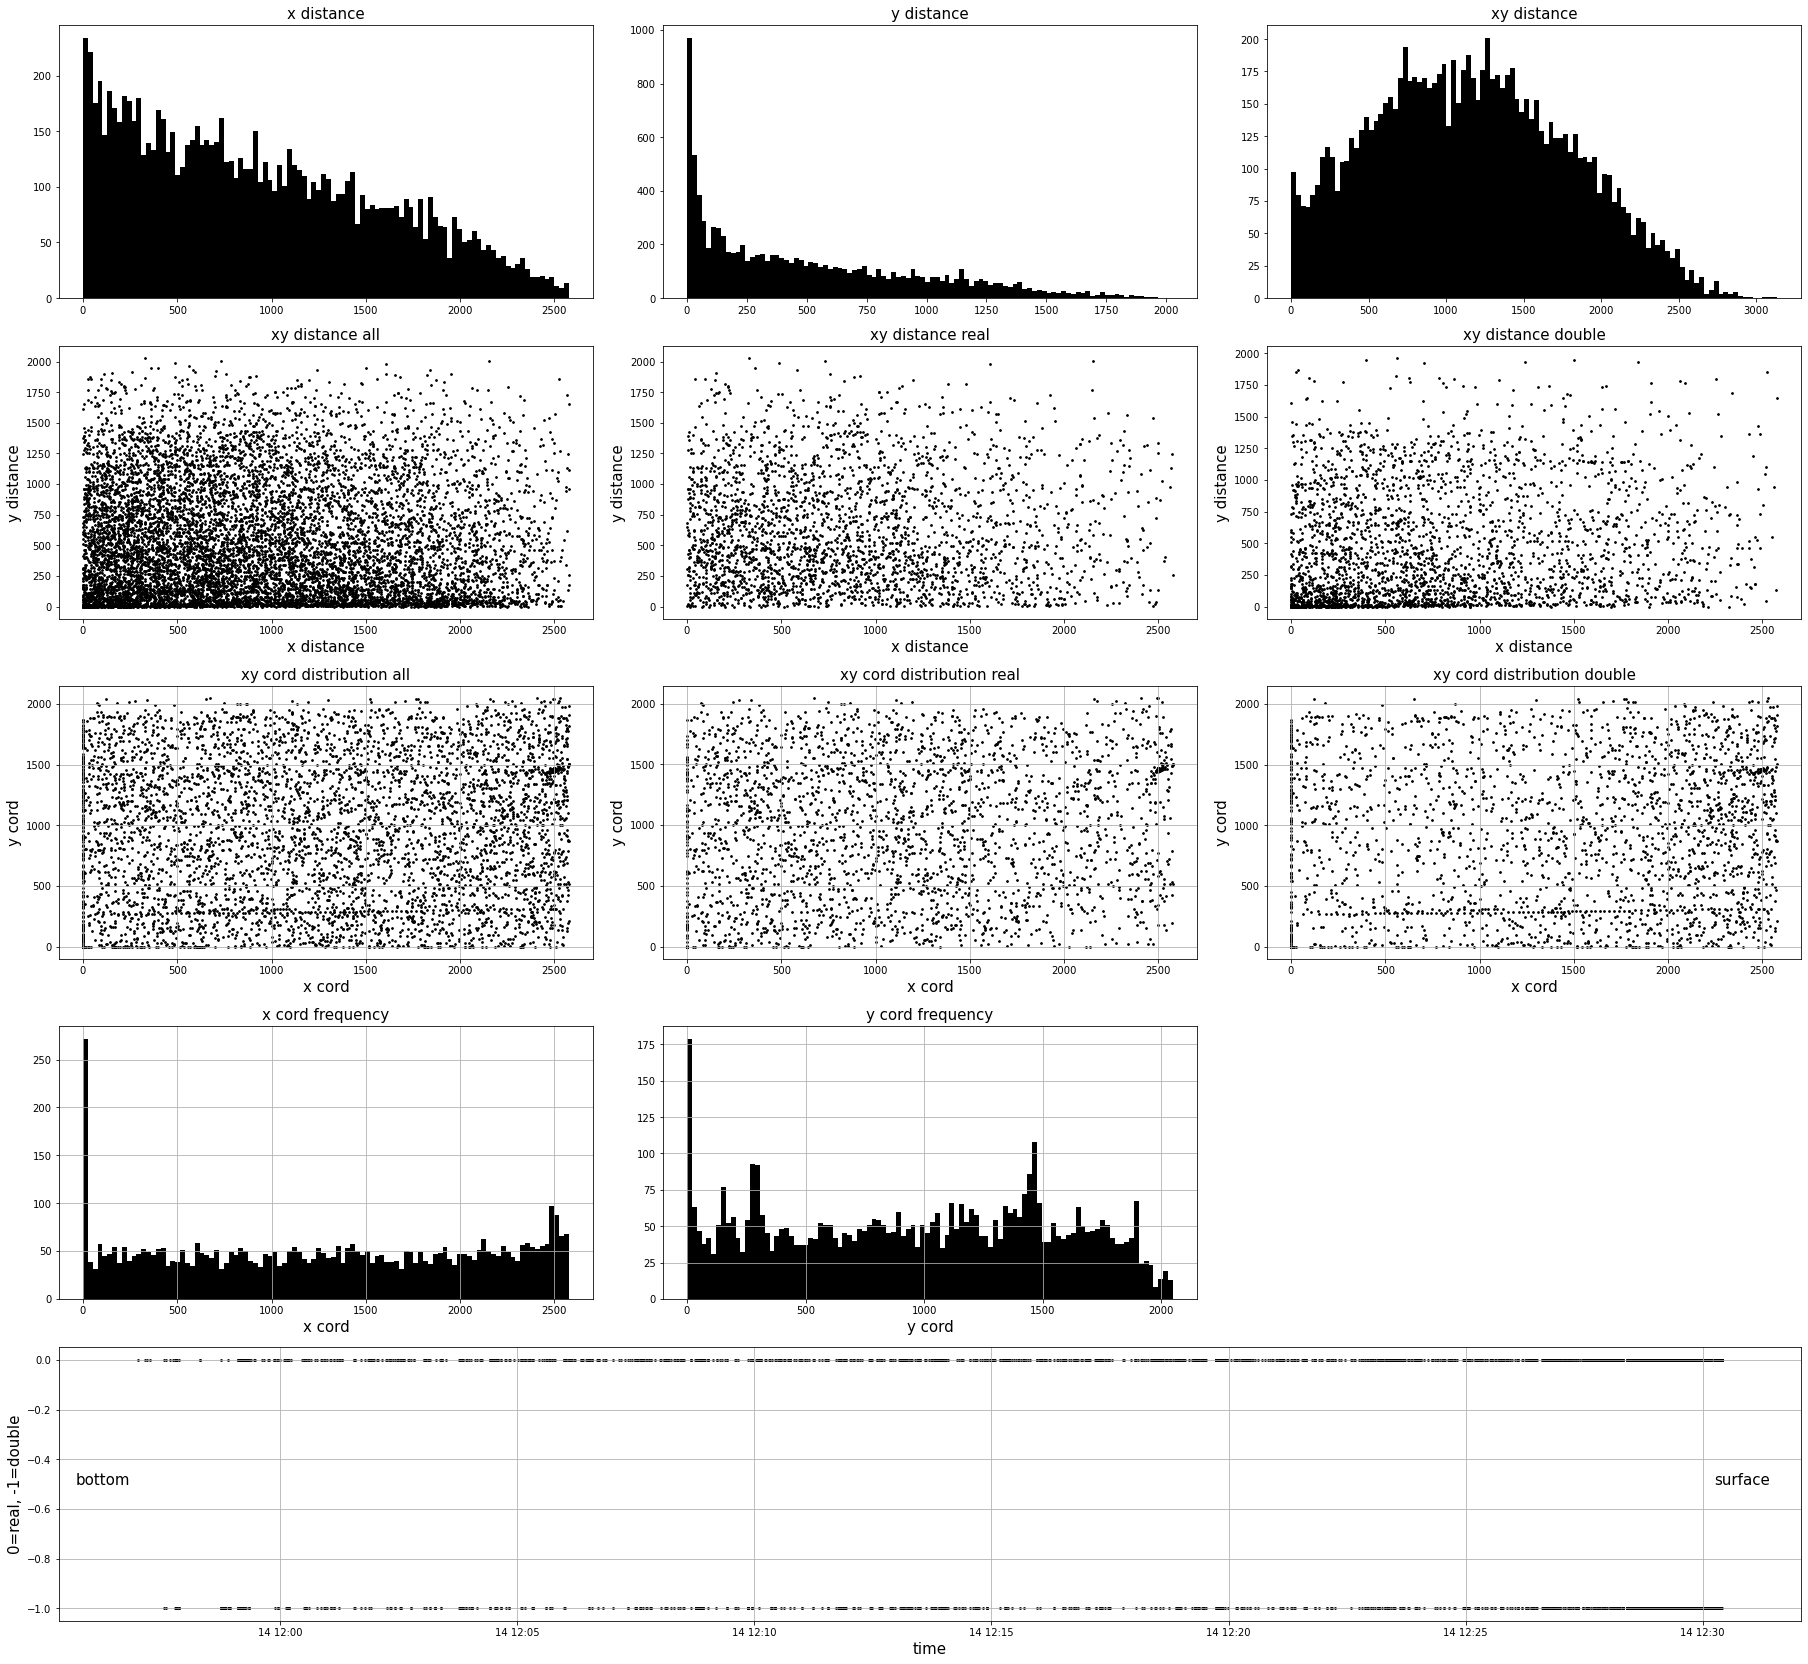

PS107-14


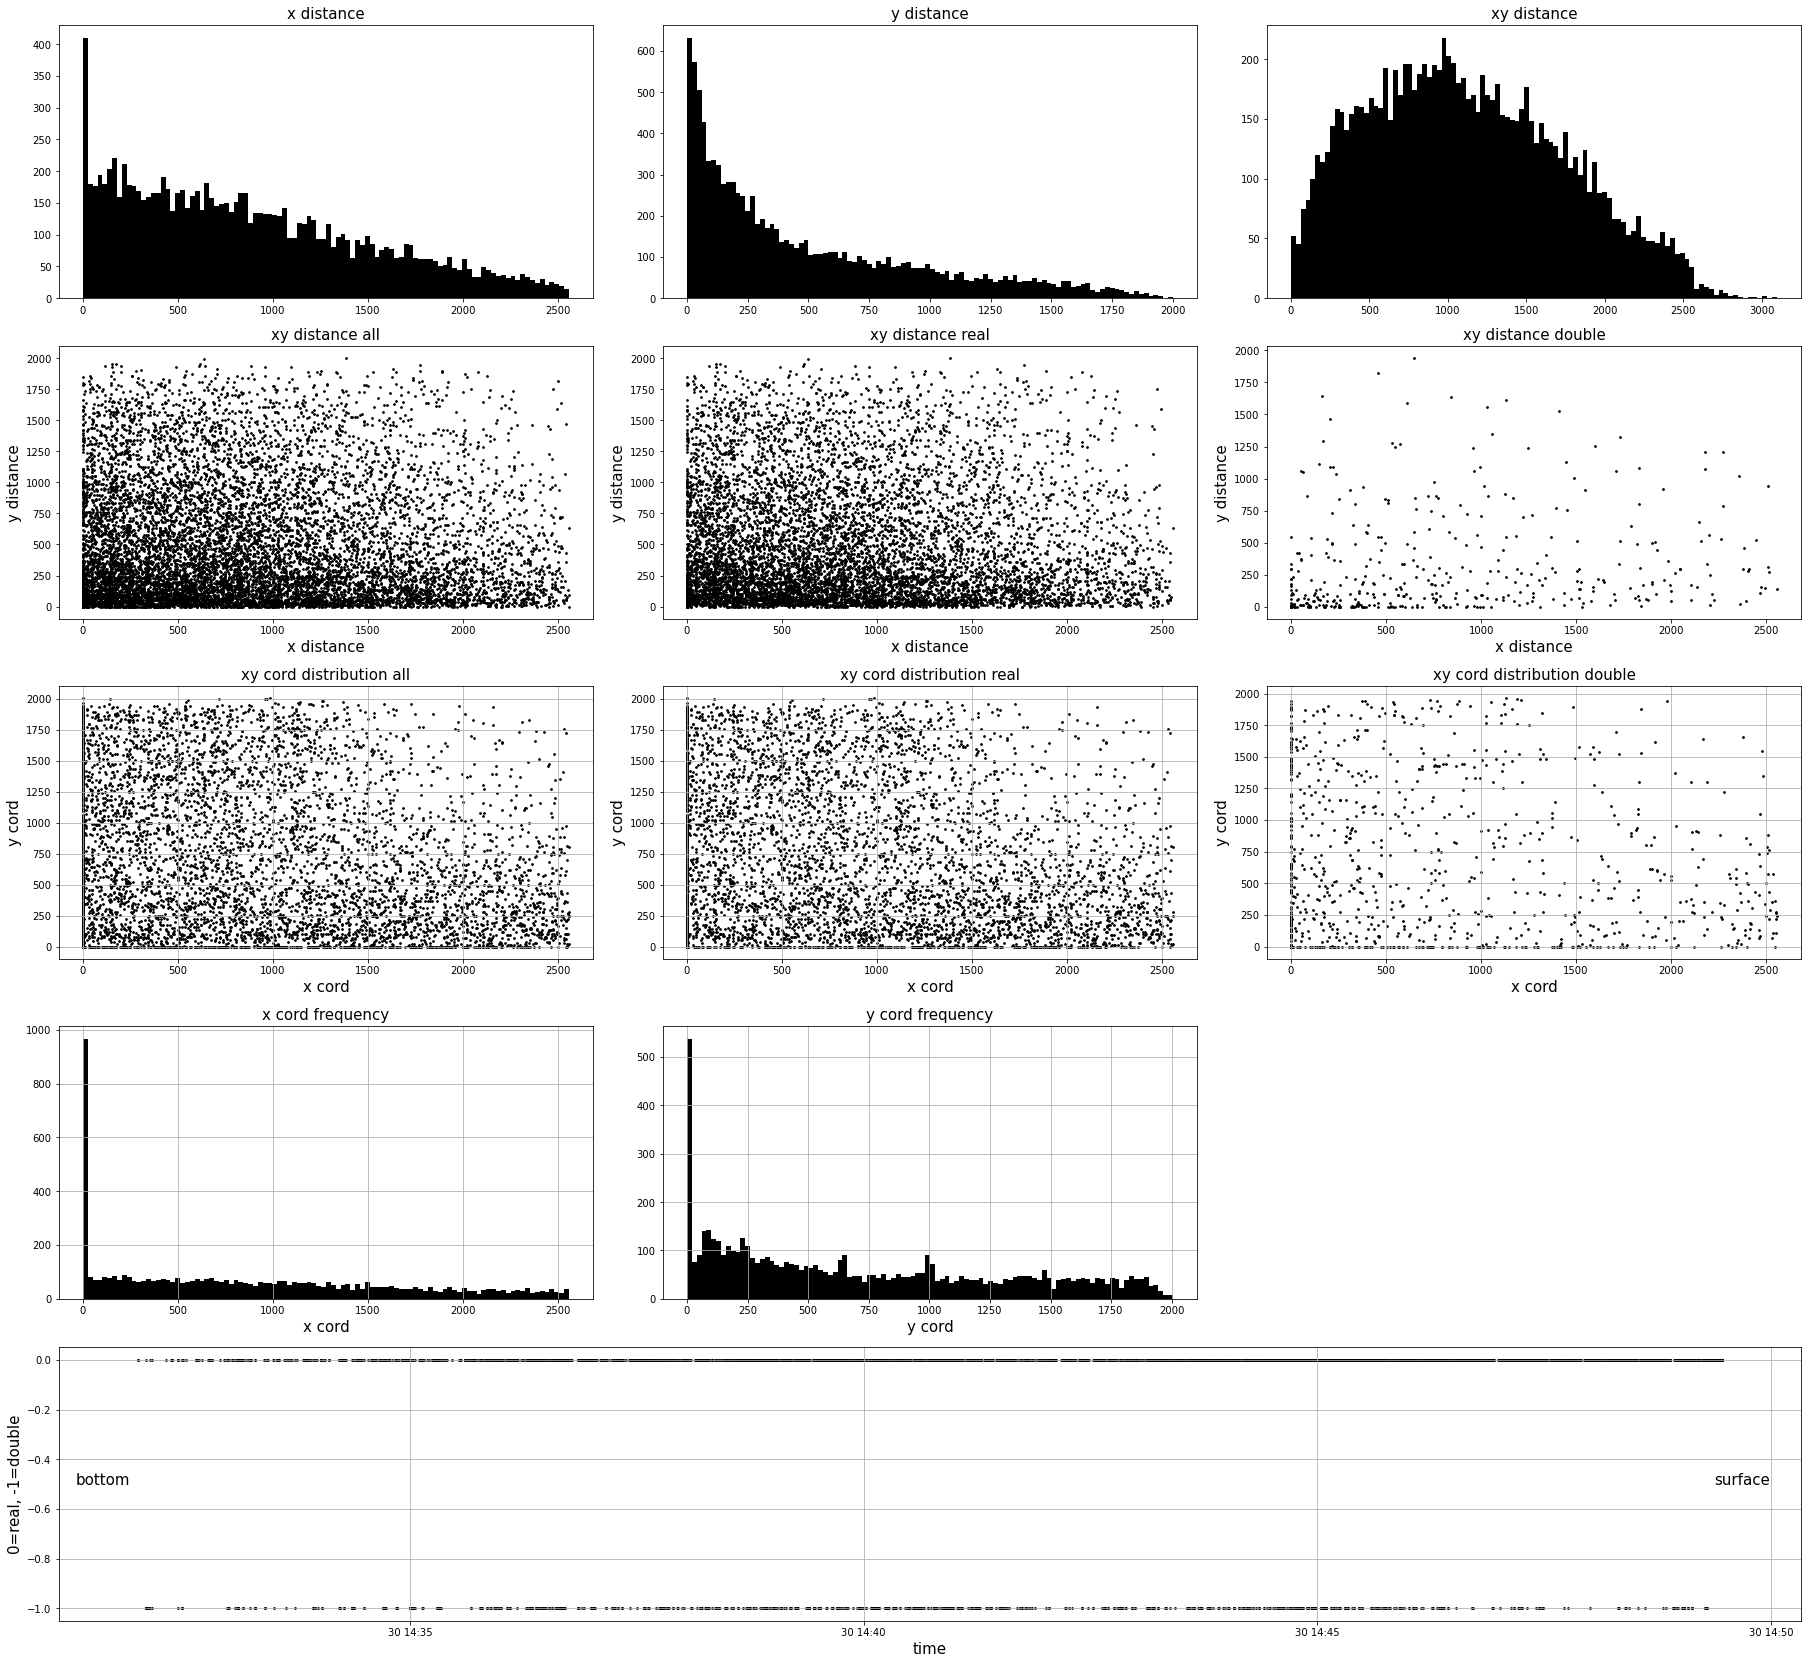

PS94-66-2


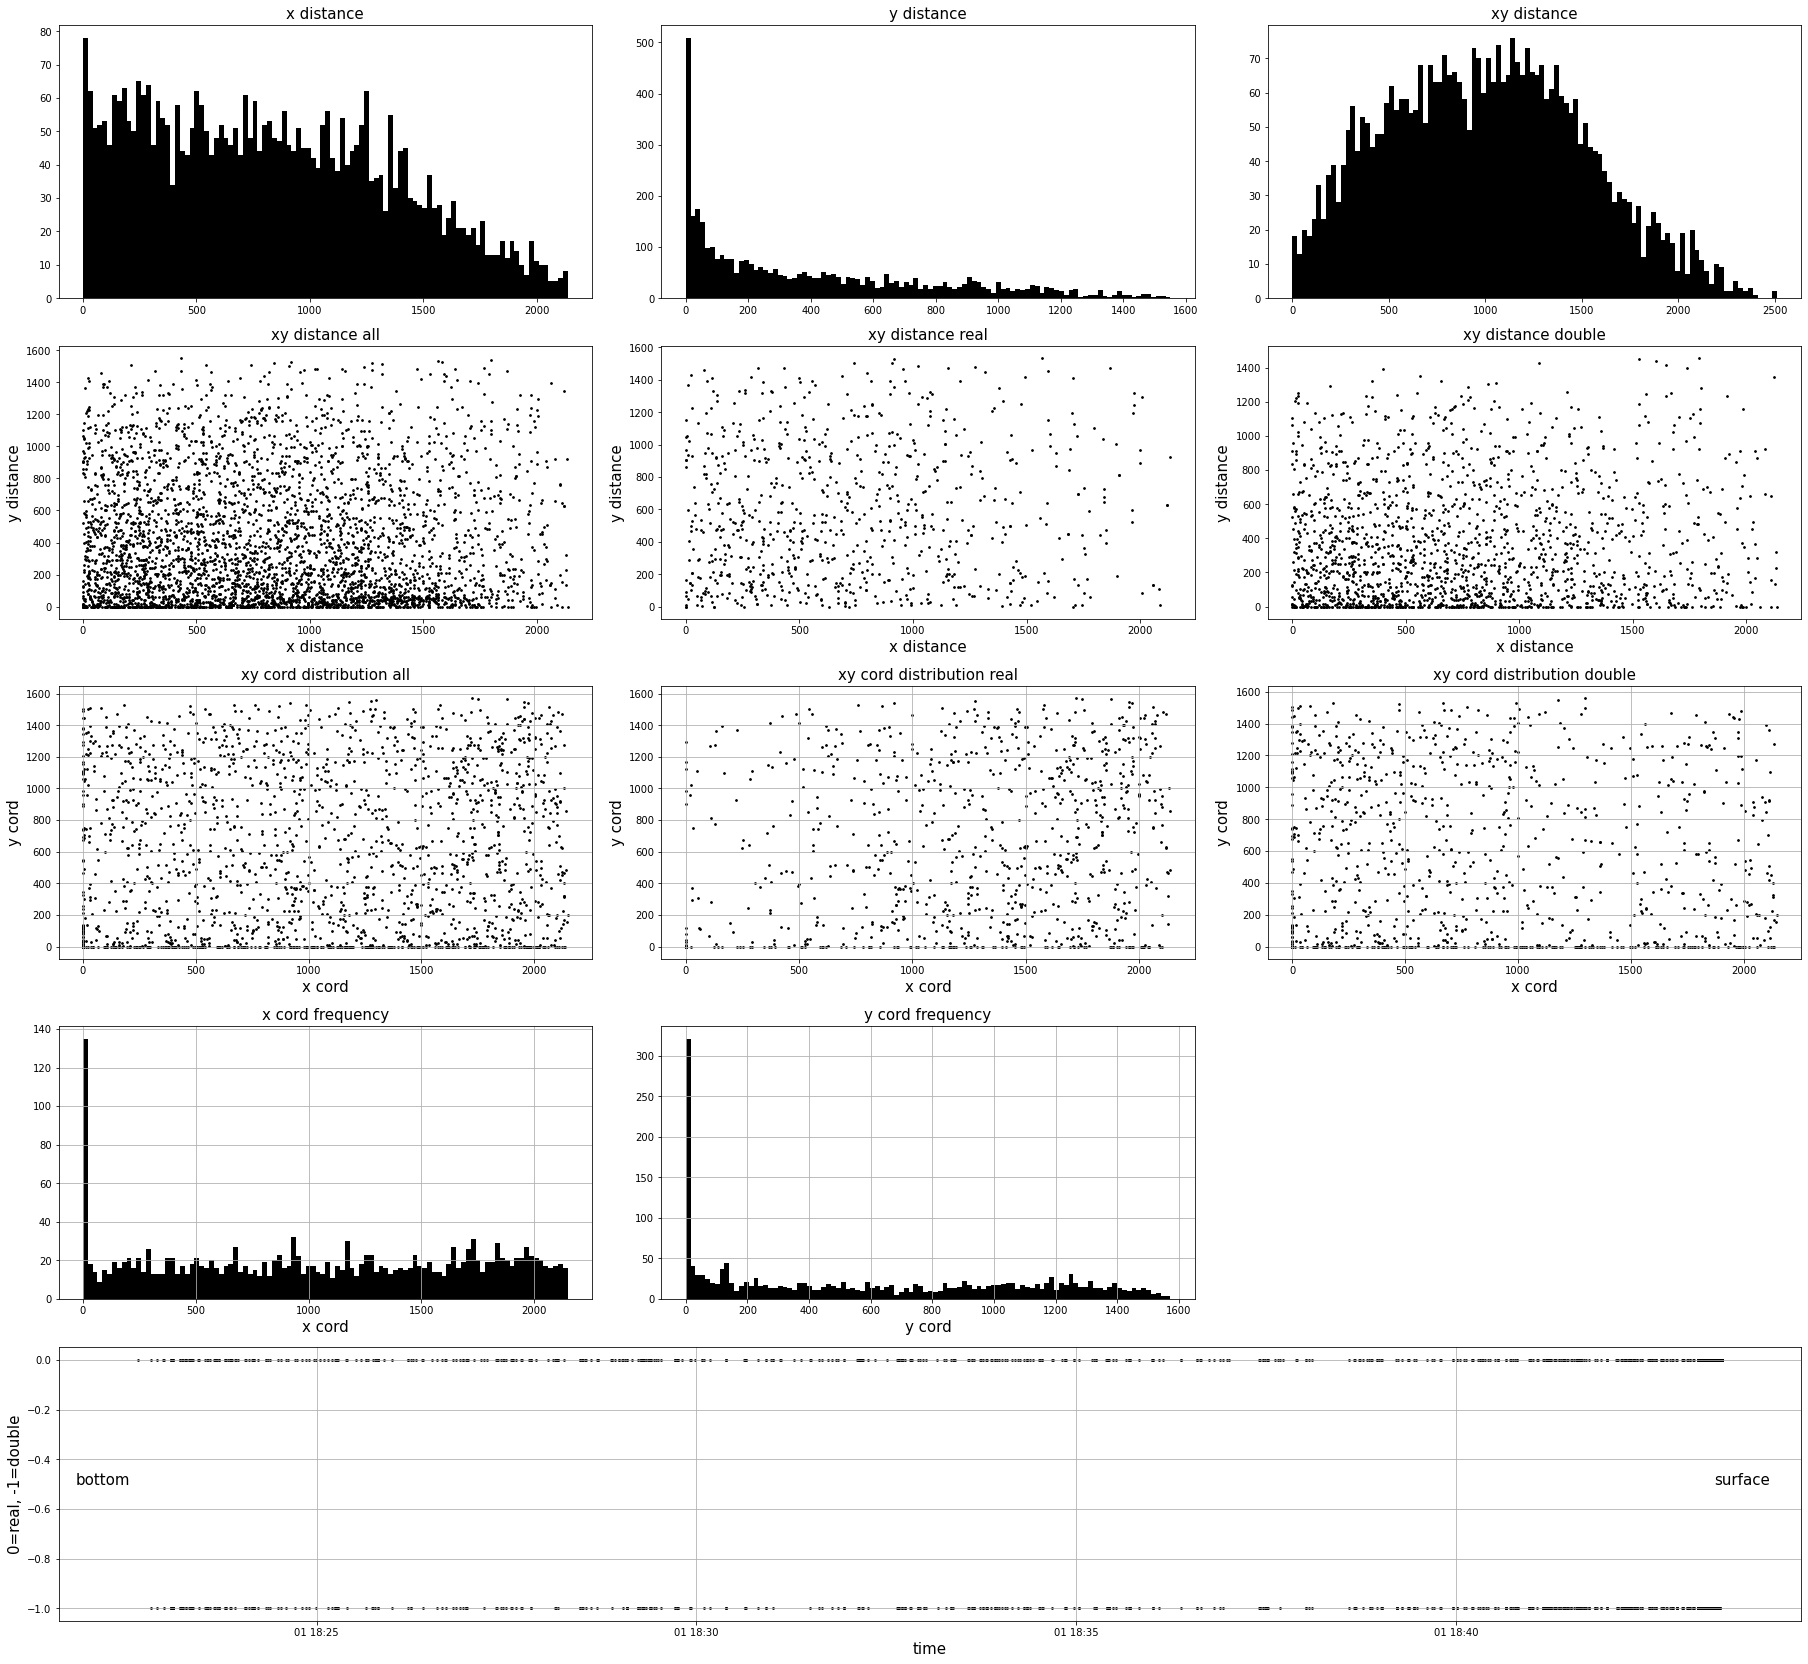

PS122-1-8-73a


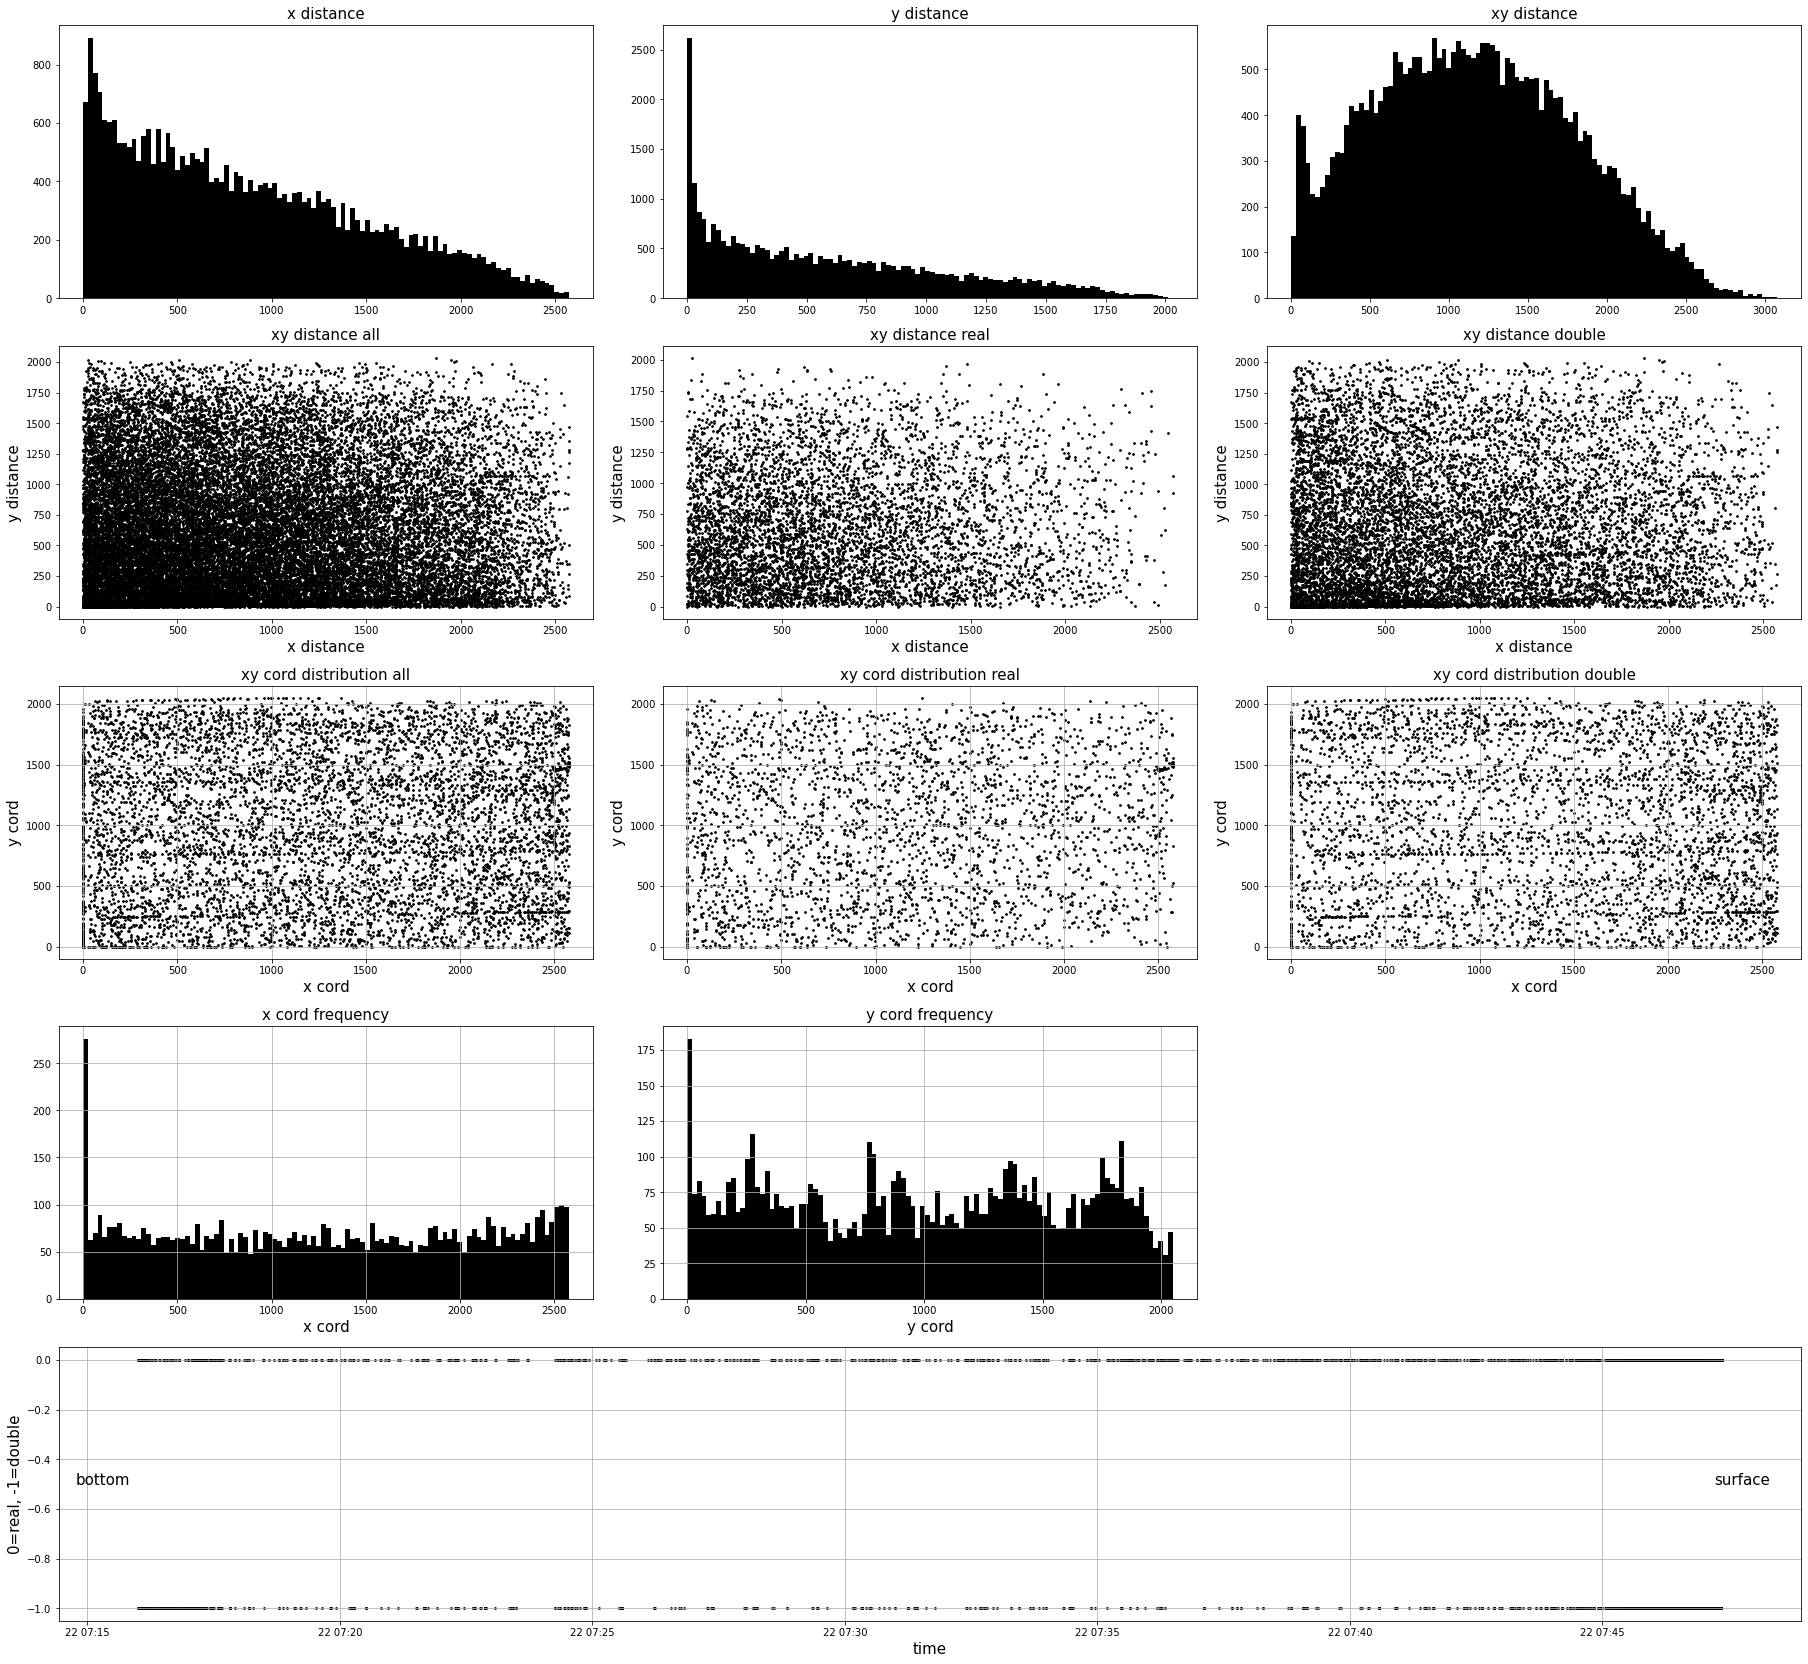

PS106.2-66-1


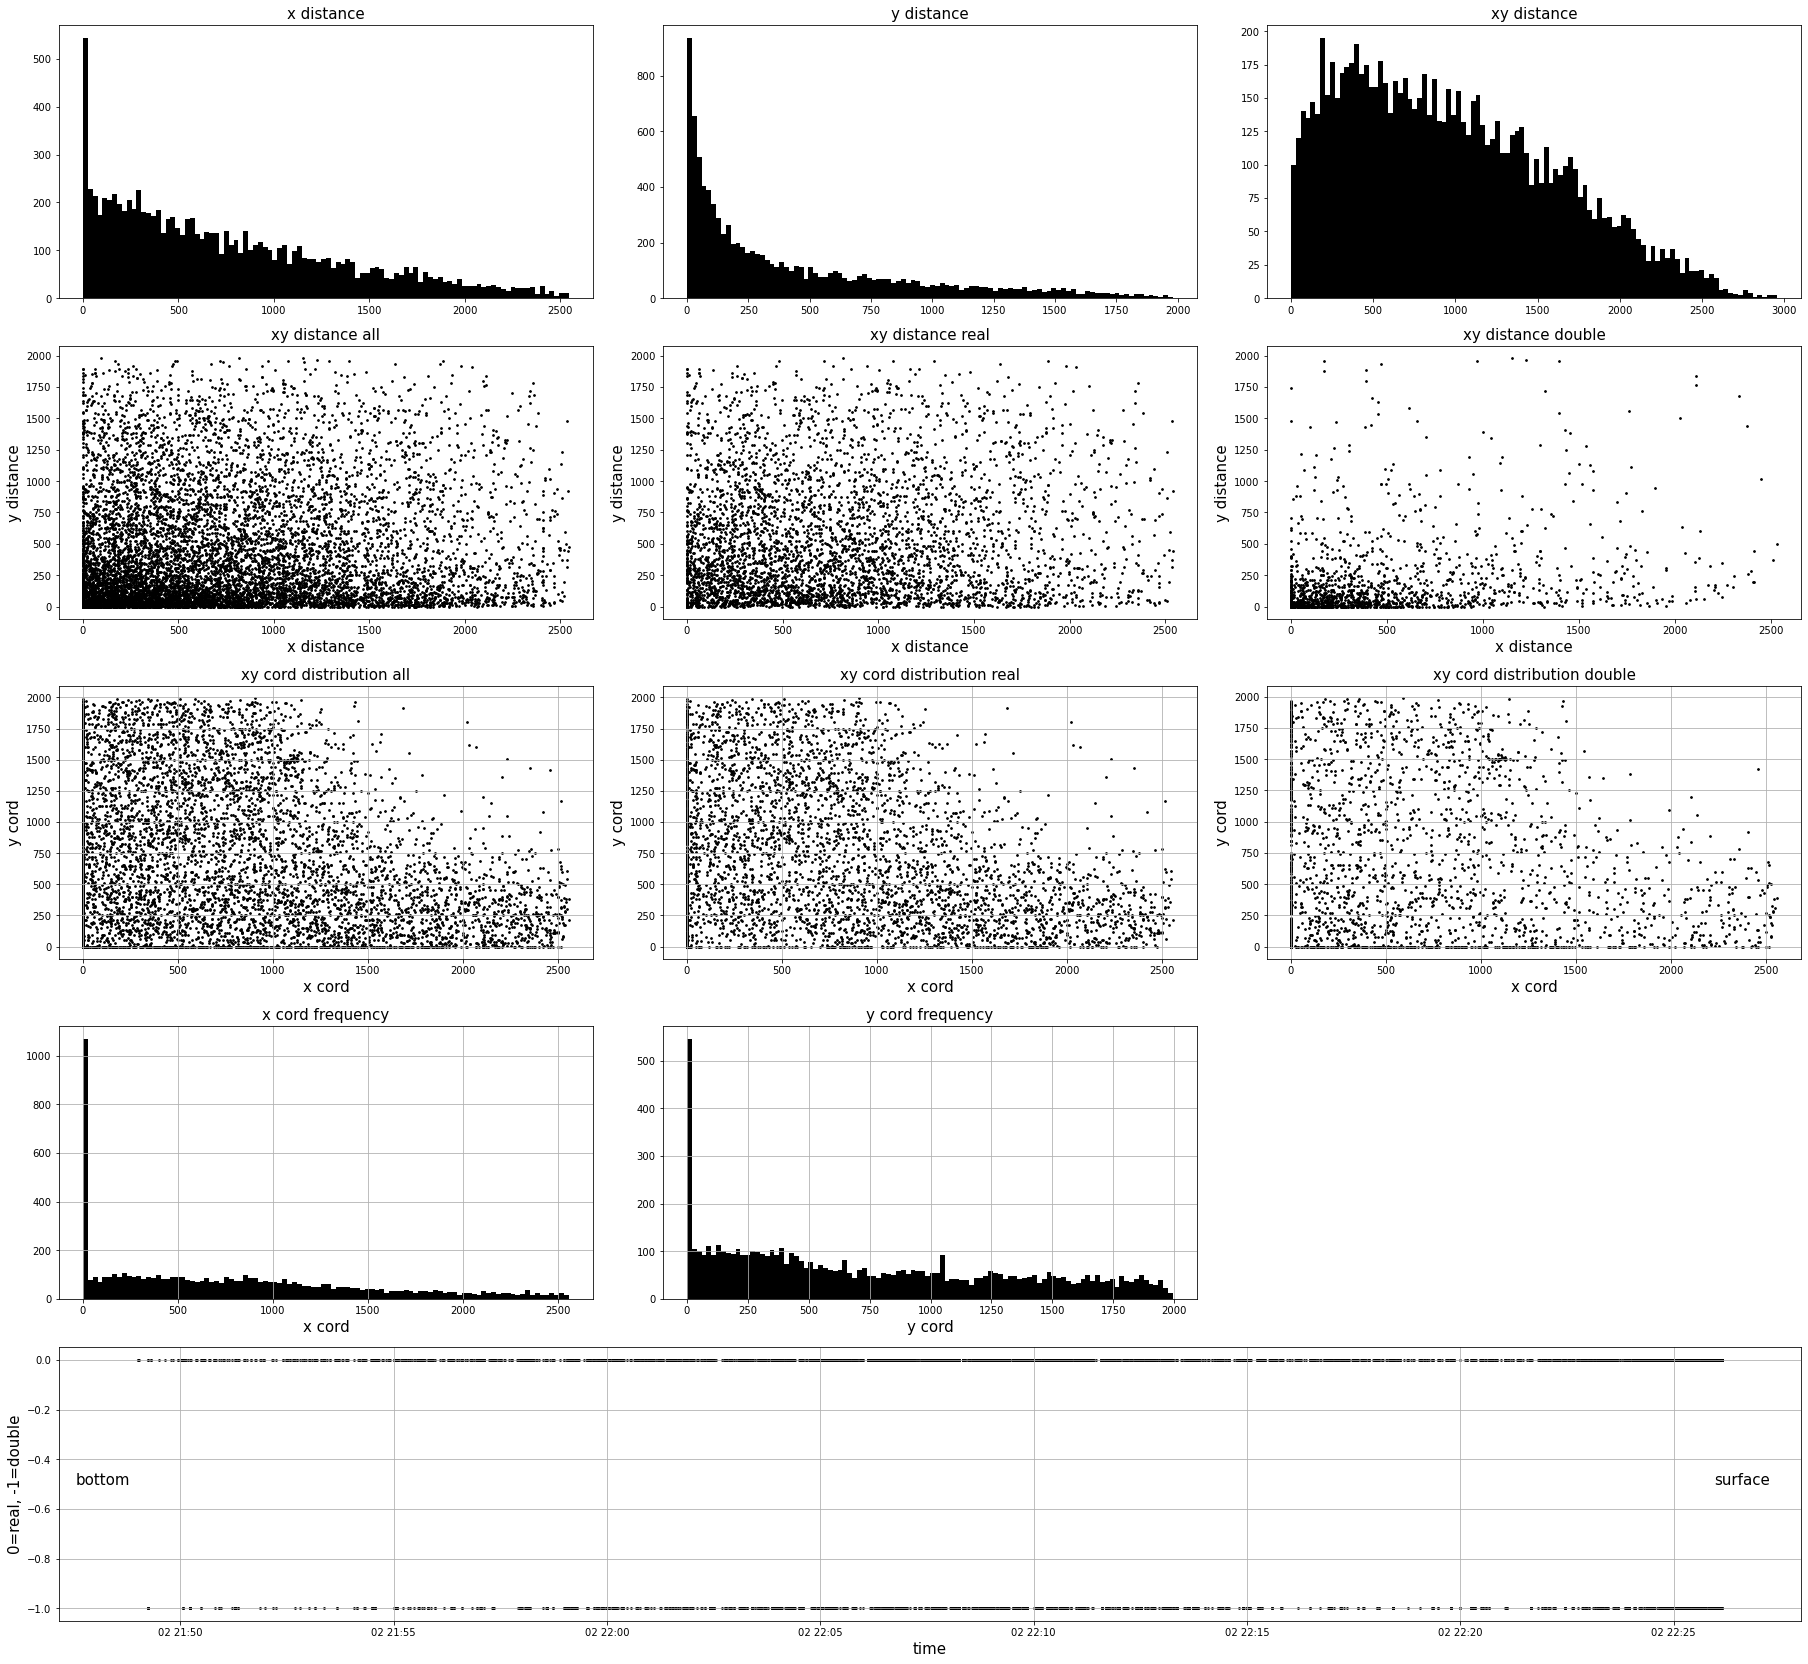

PS93.2-048_9


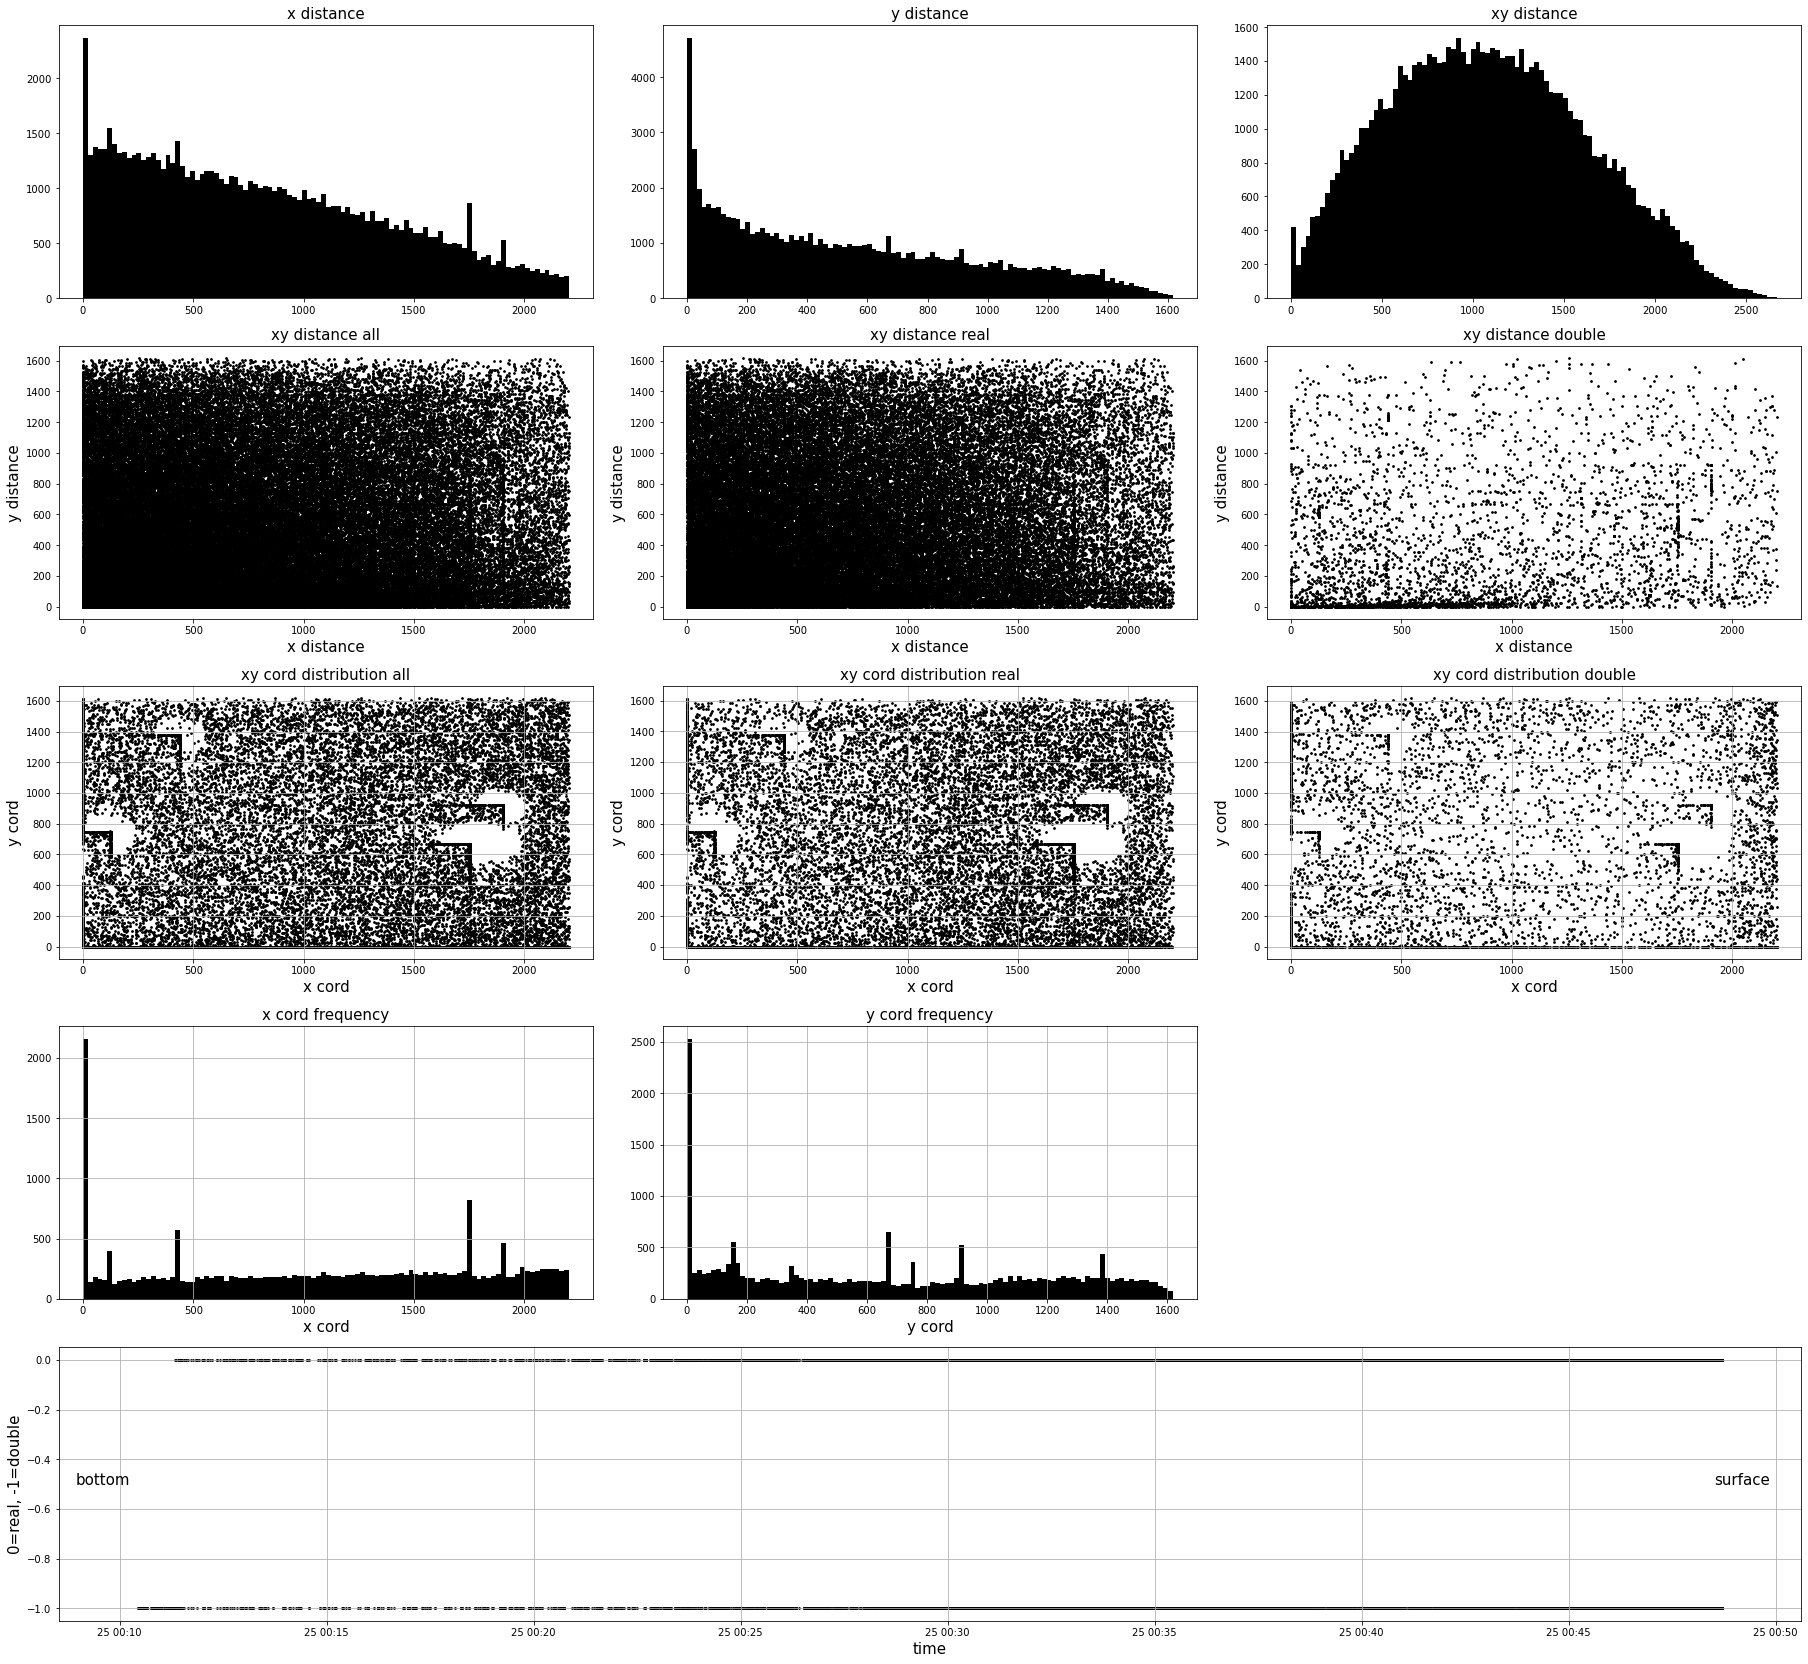

PS99_0053-5


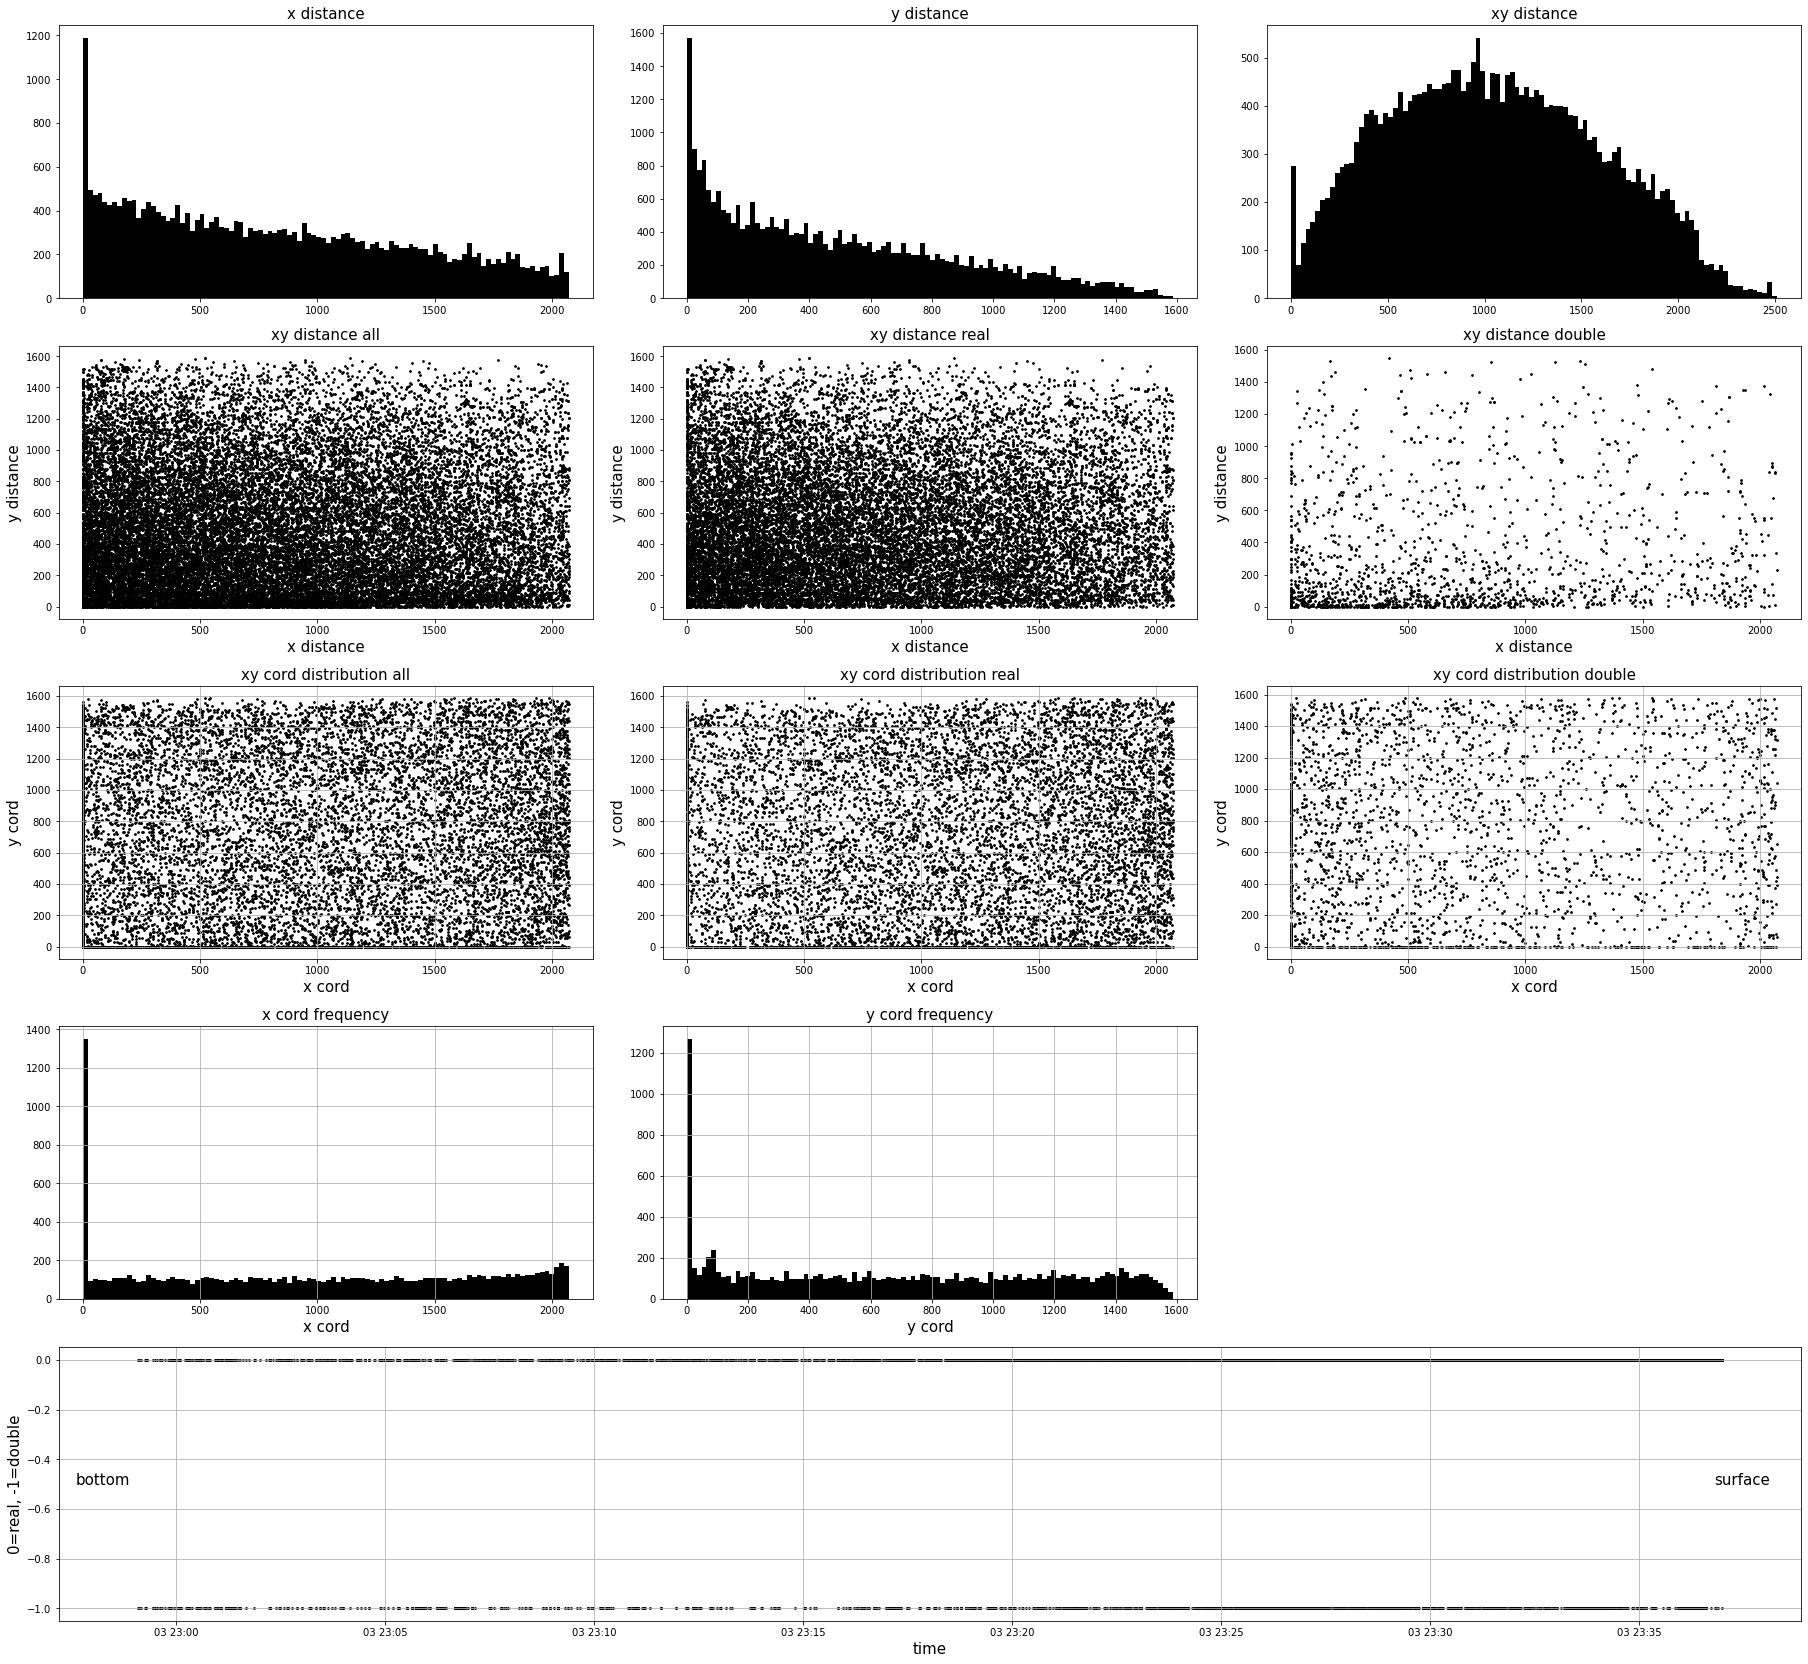

PS106.2-47


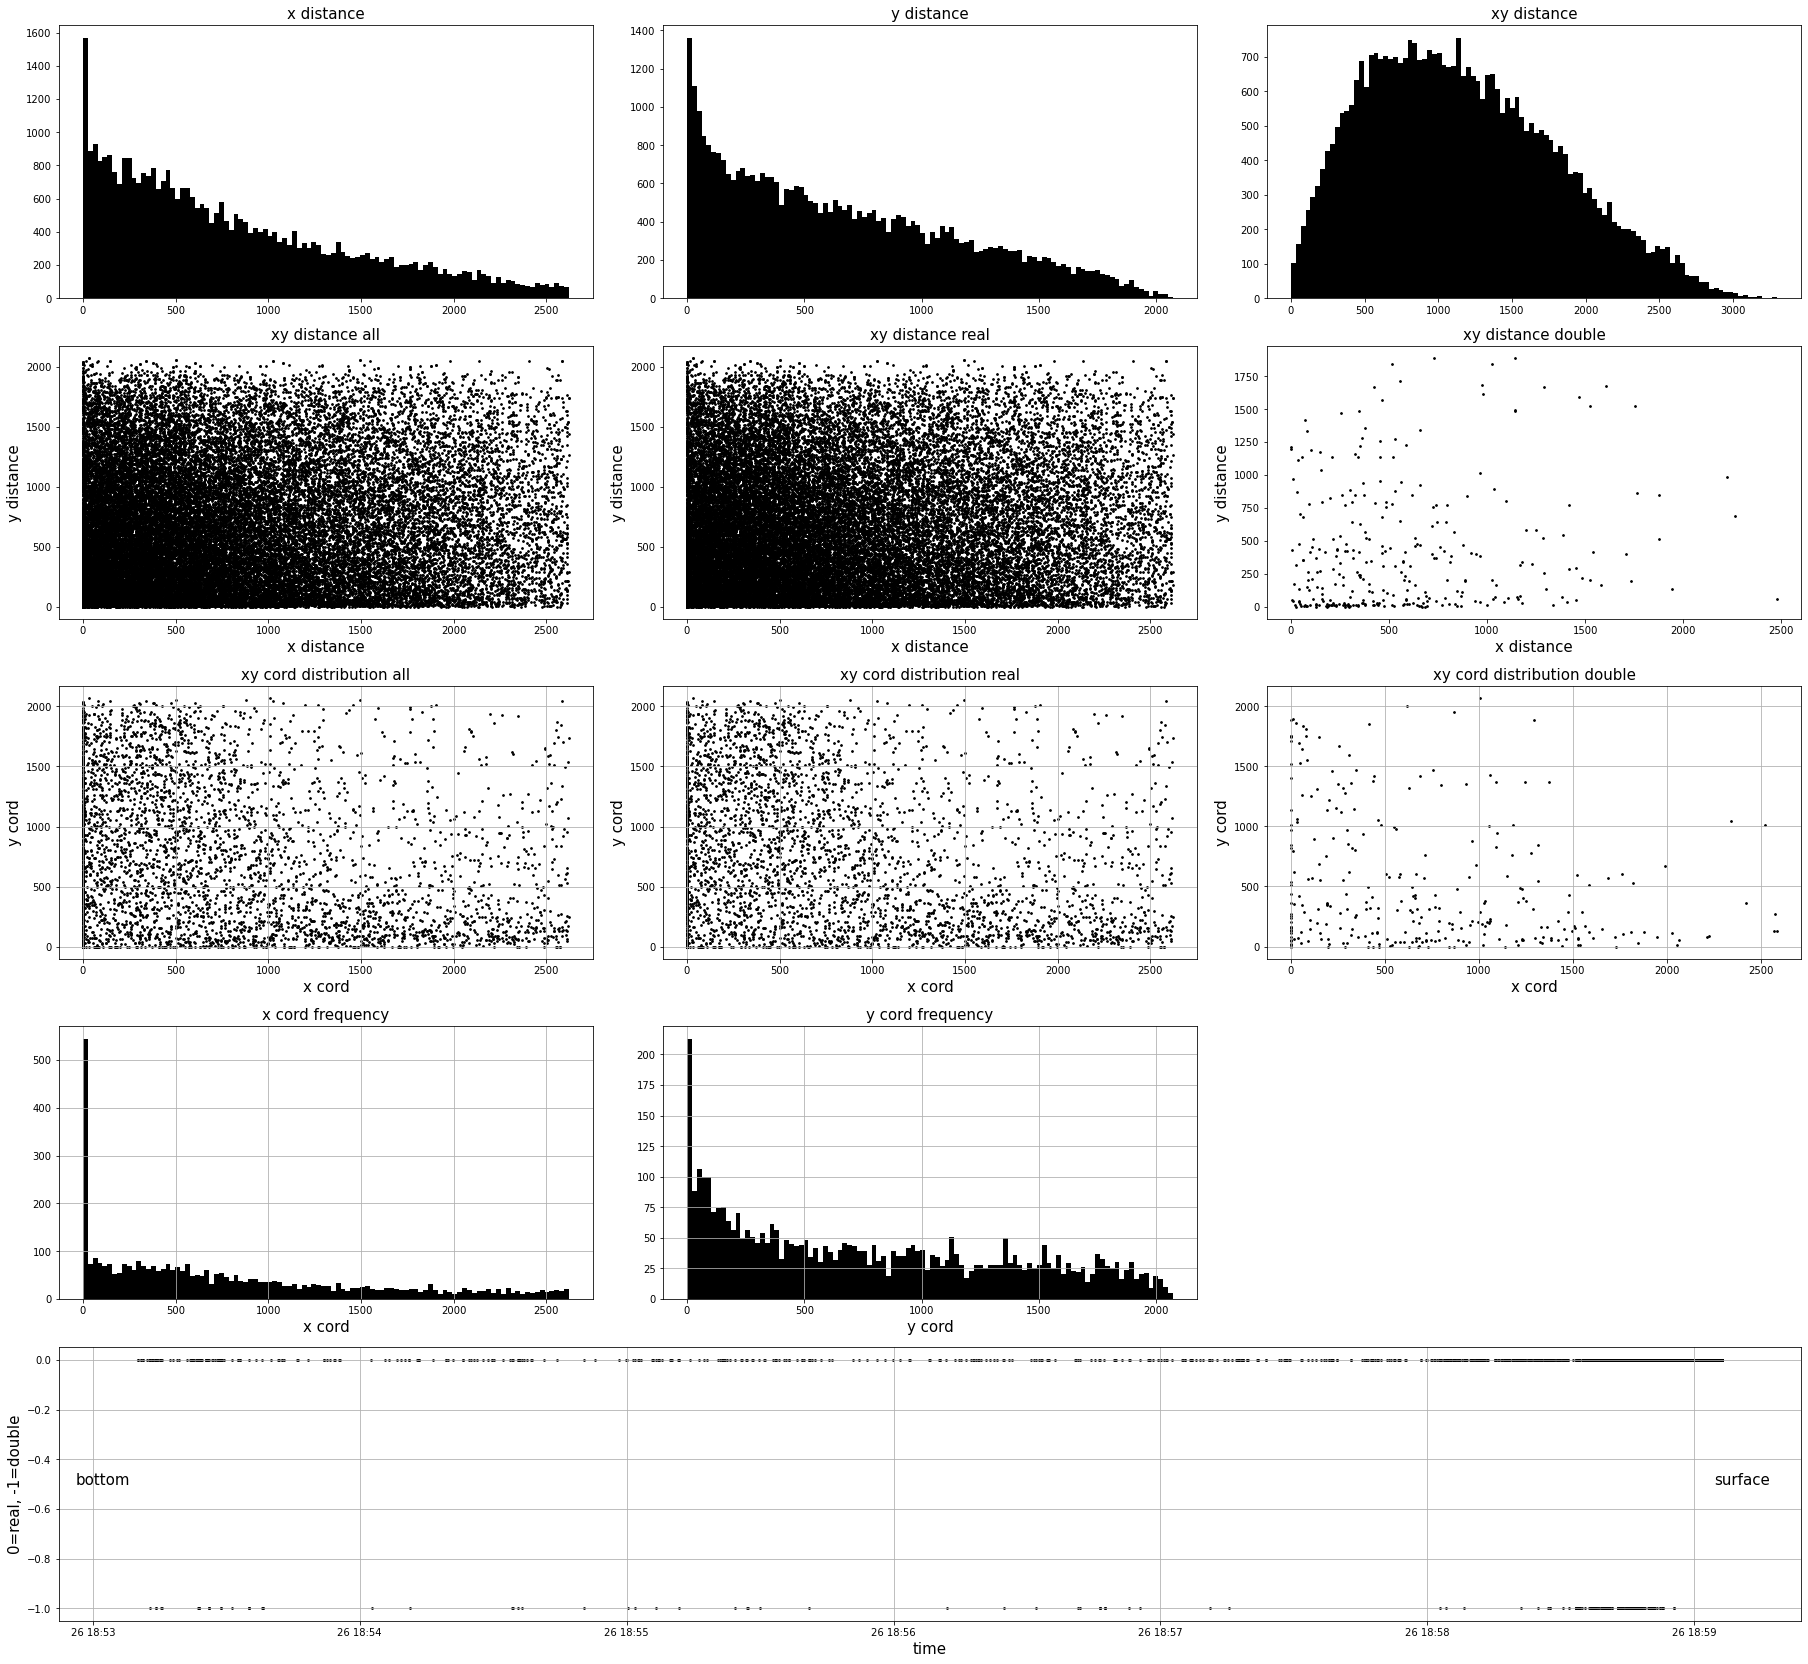

PS106.2-50-3


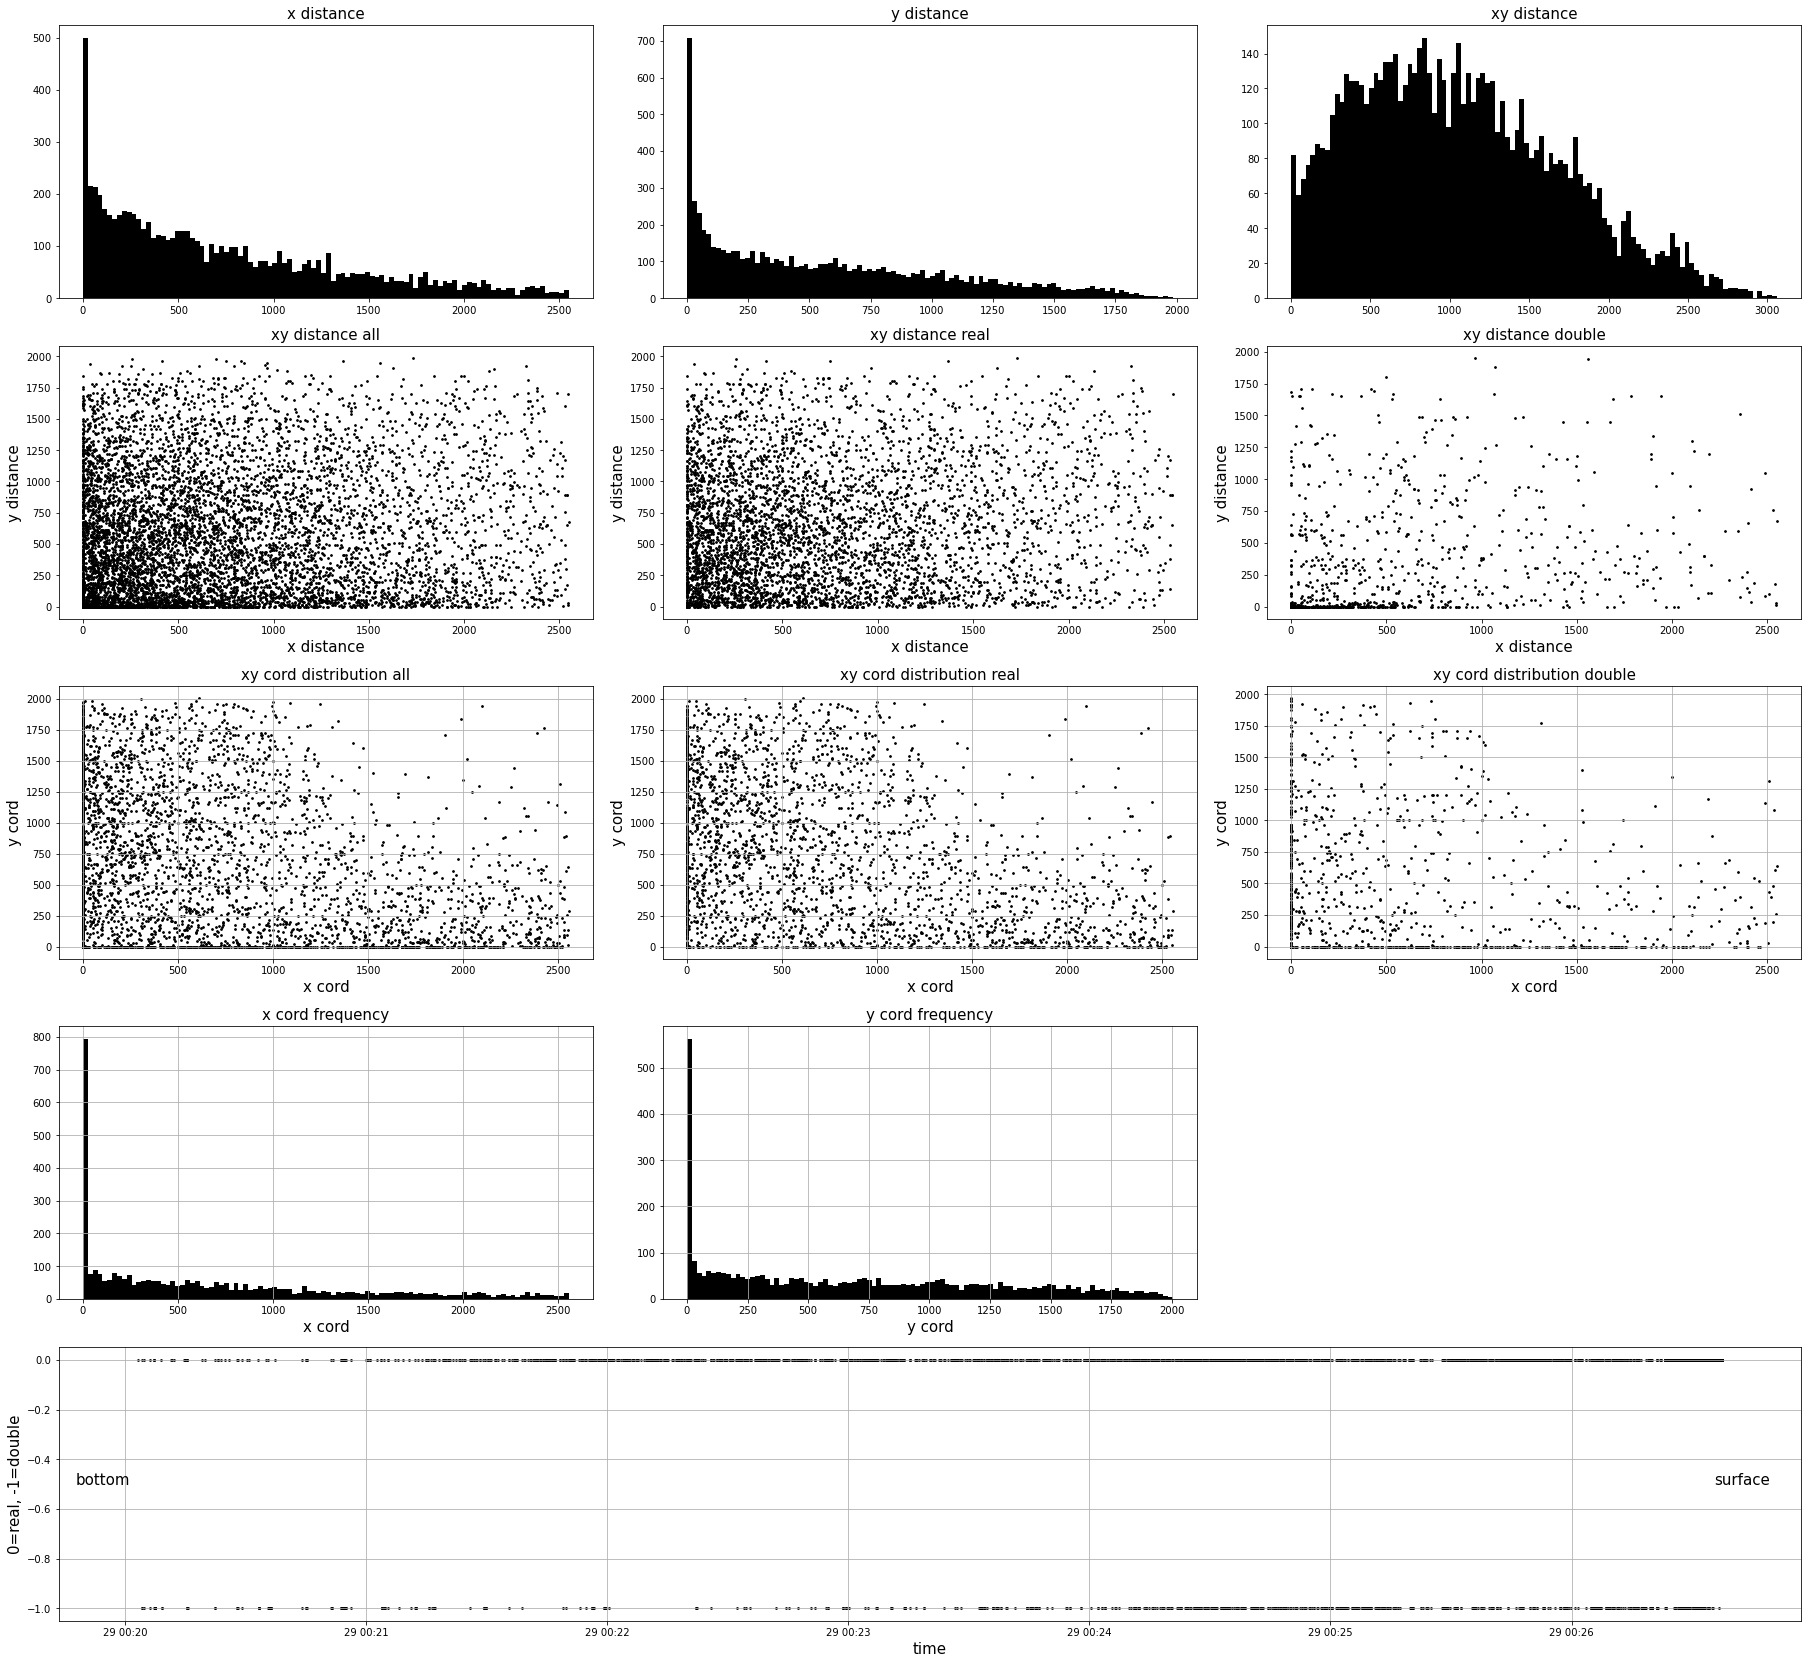

PS107-18


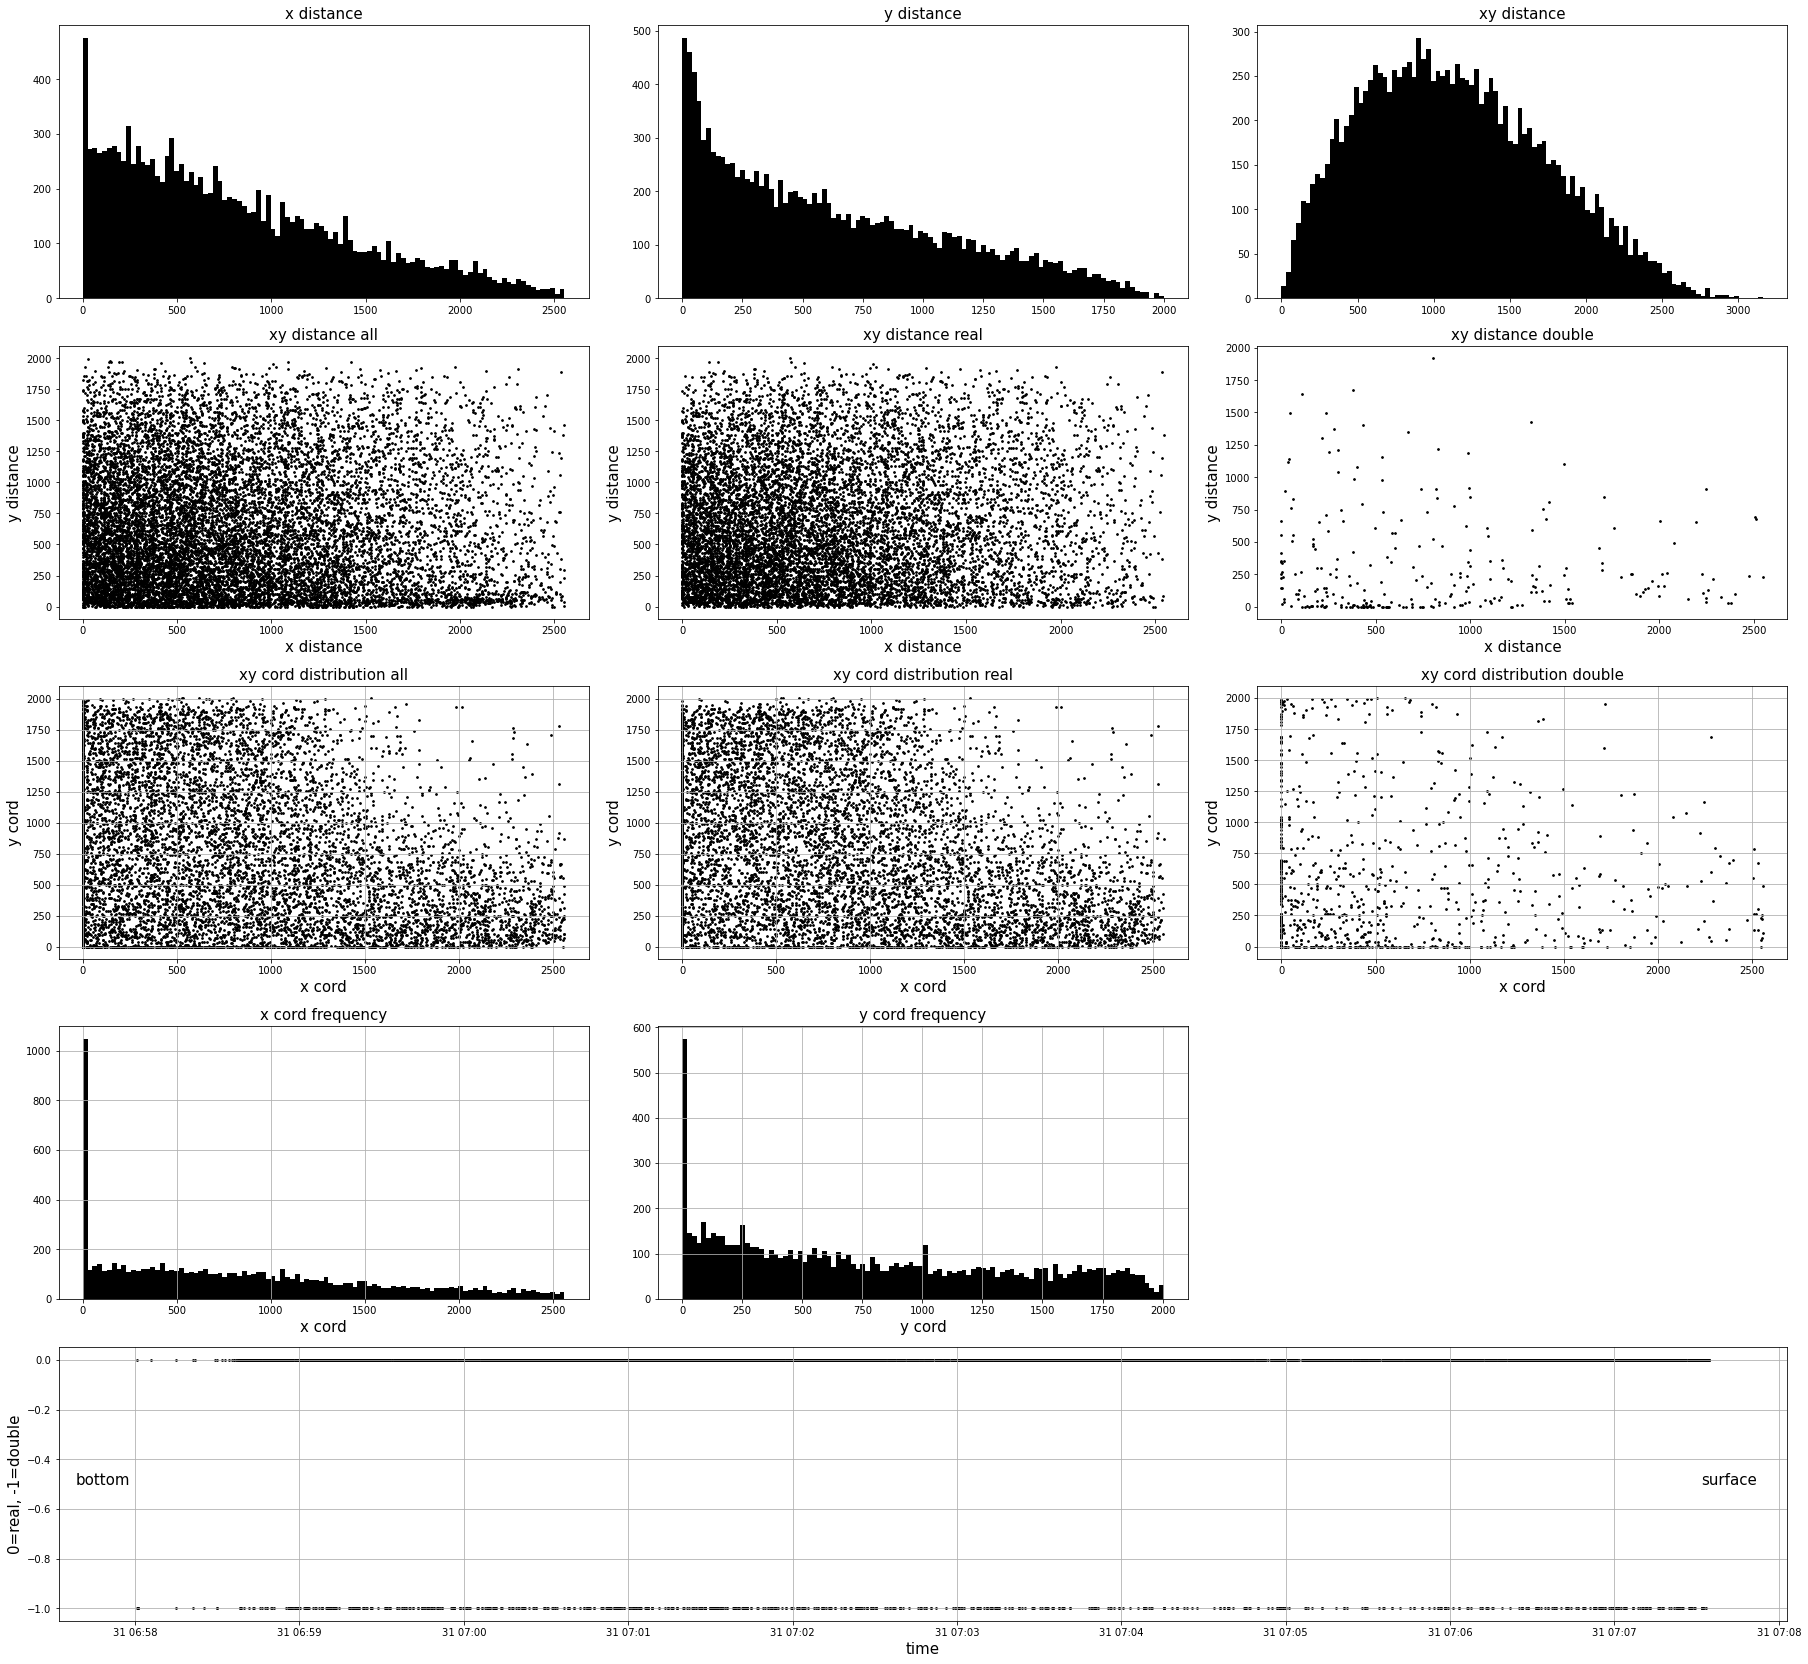

None
PS107-10


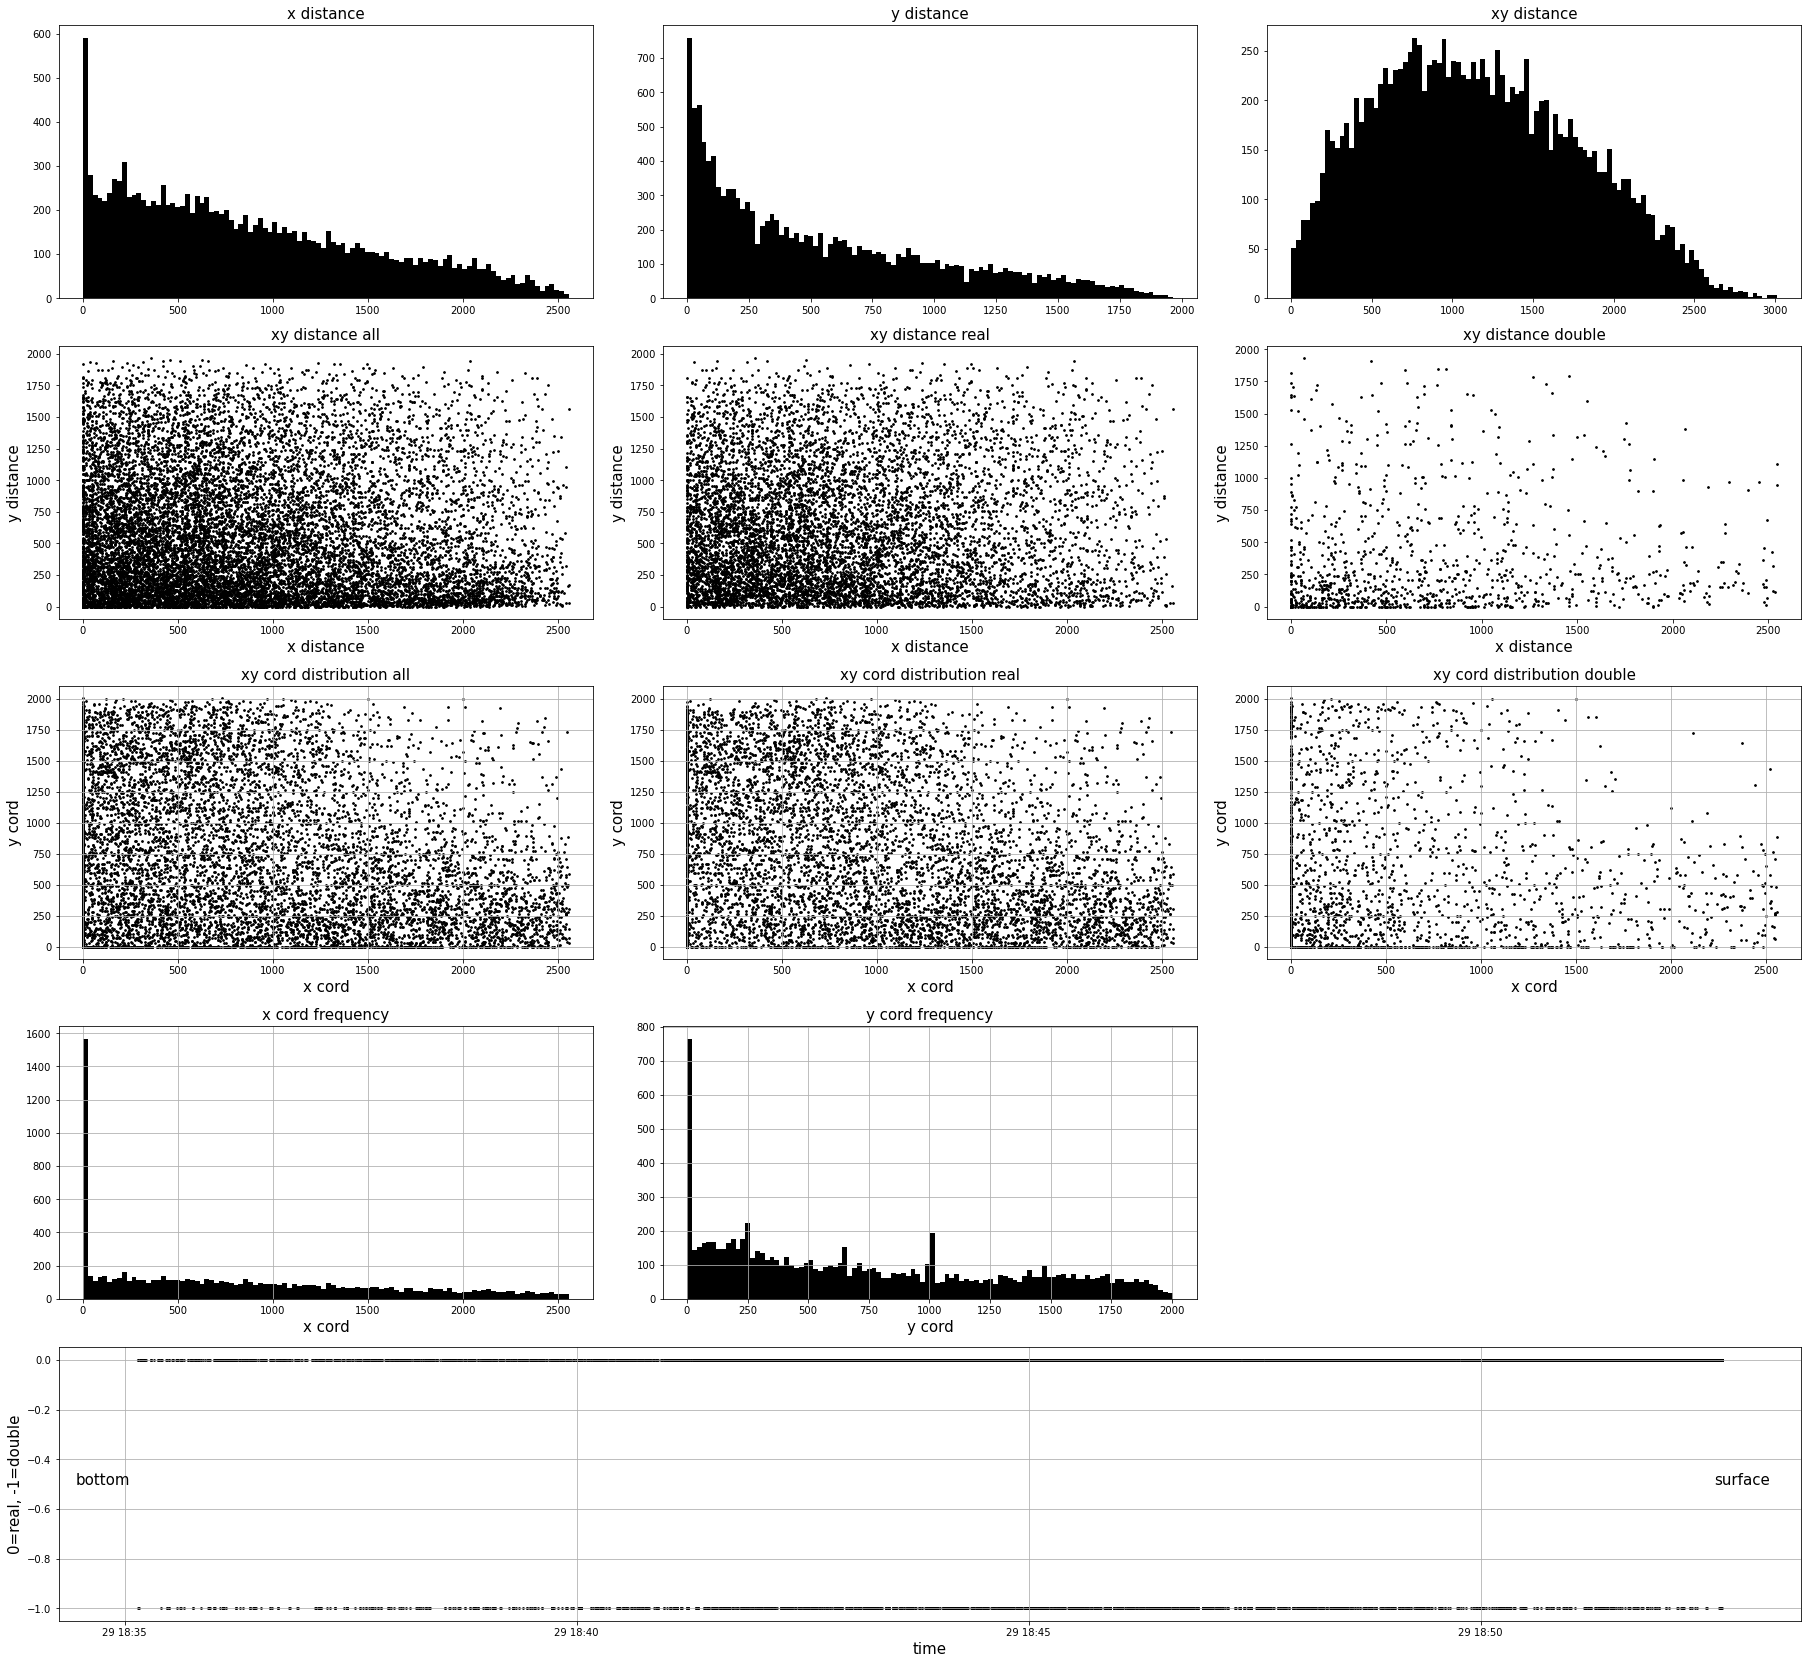

PS94-50-7


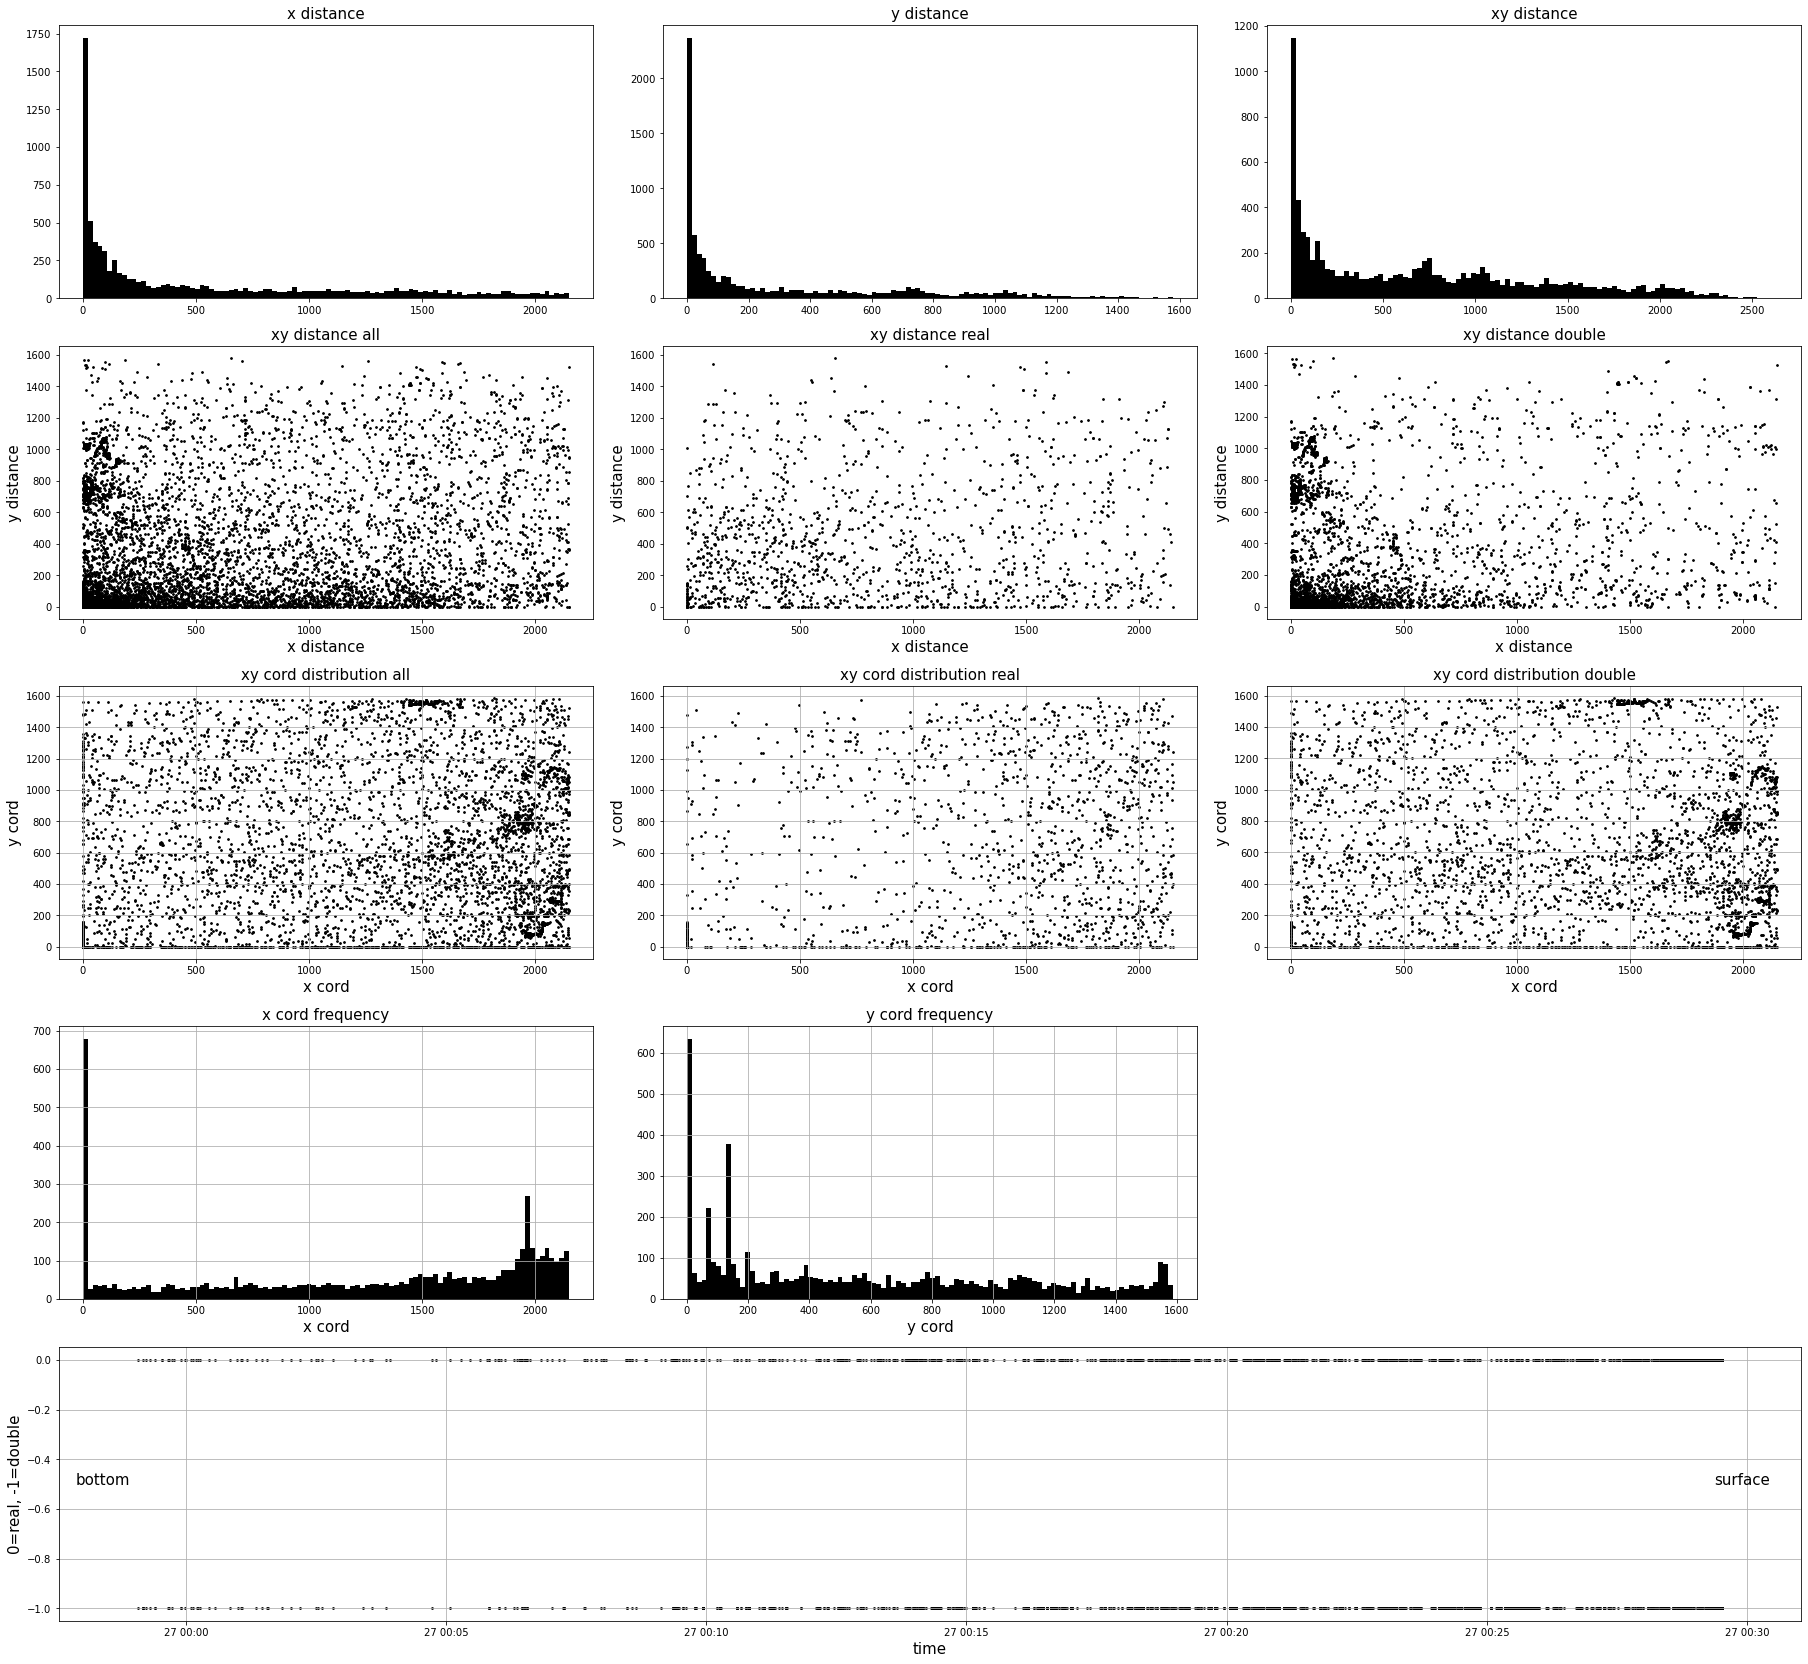

PS122_010


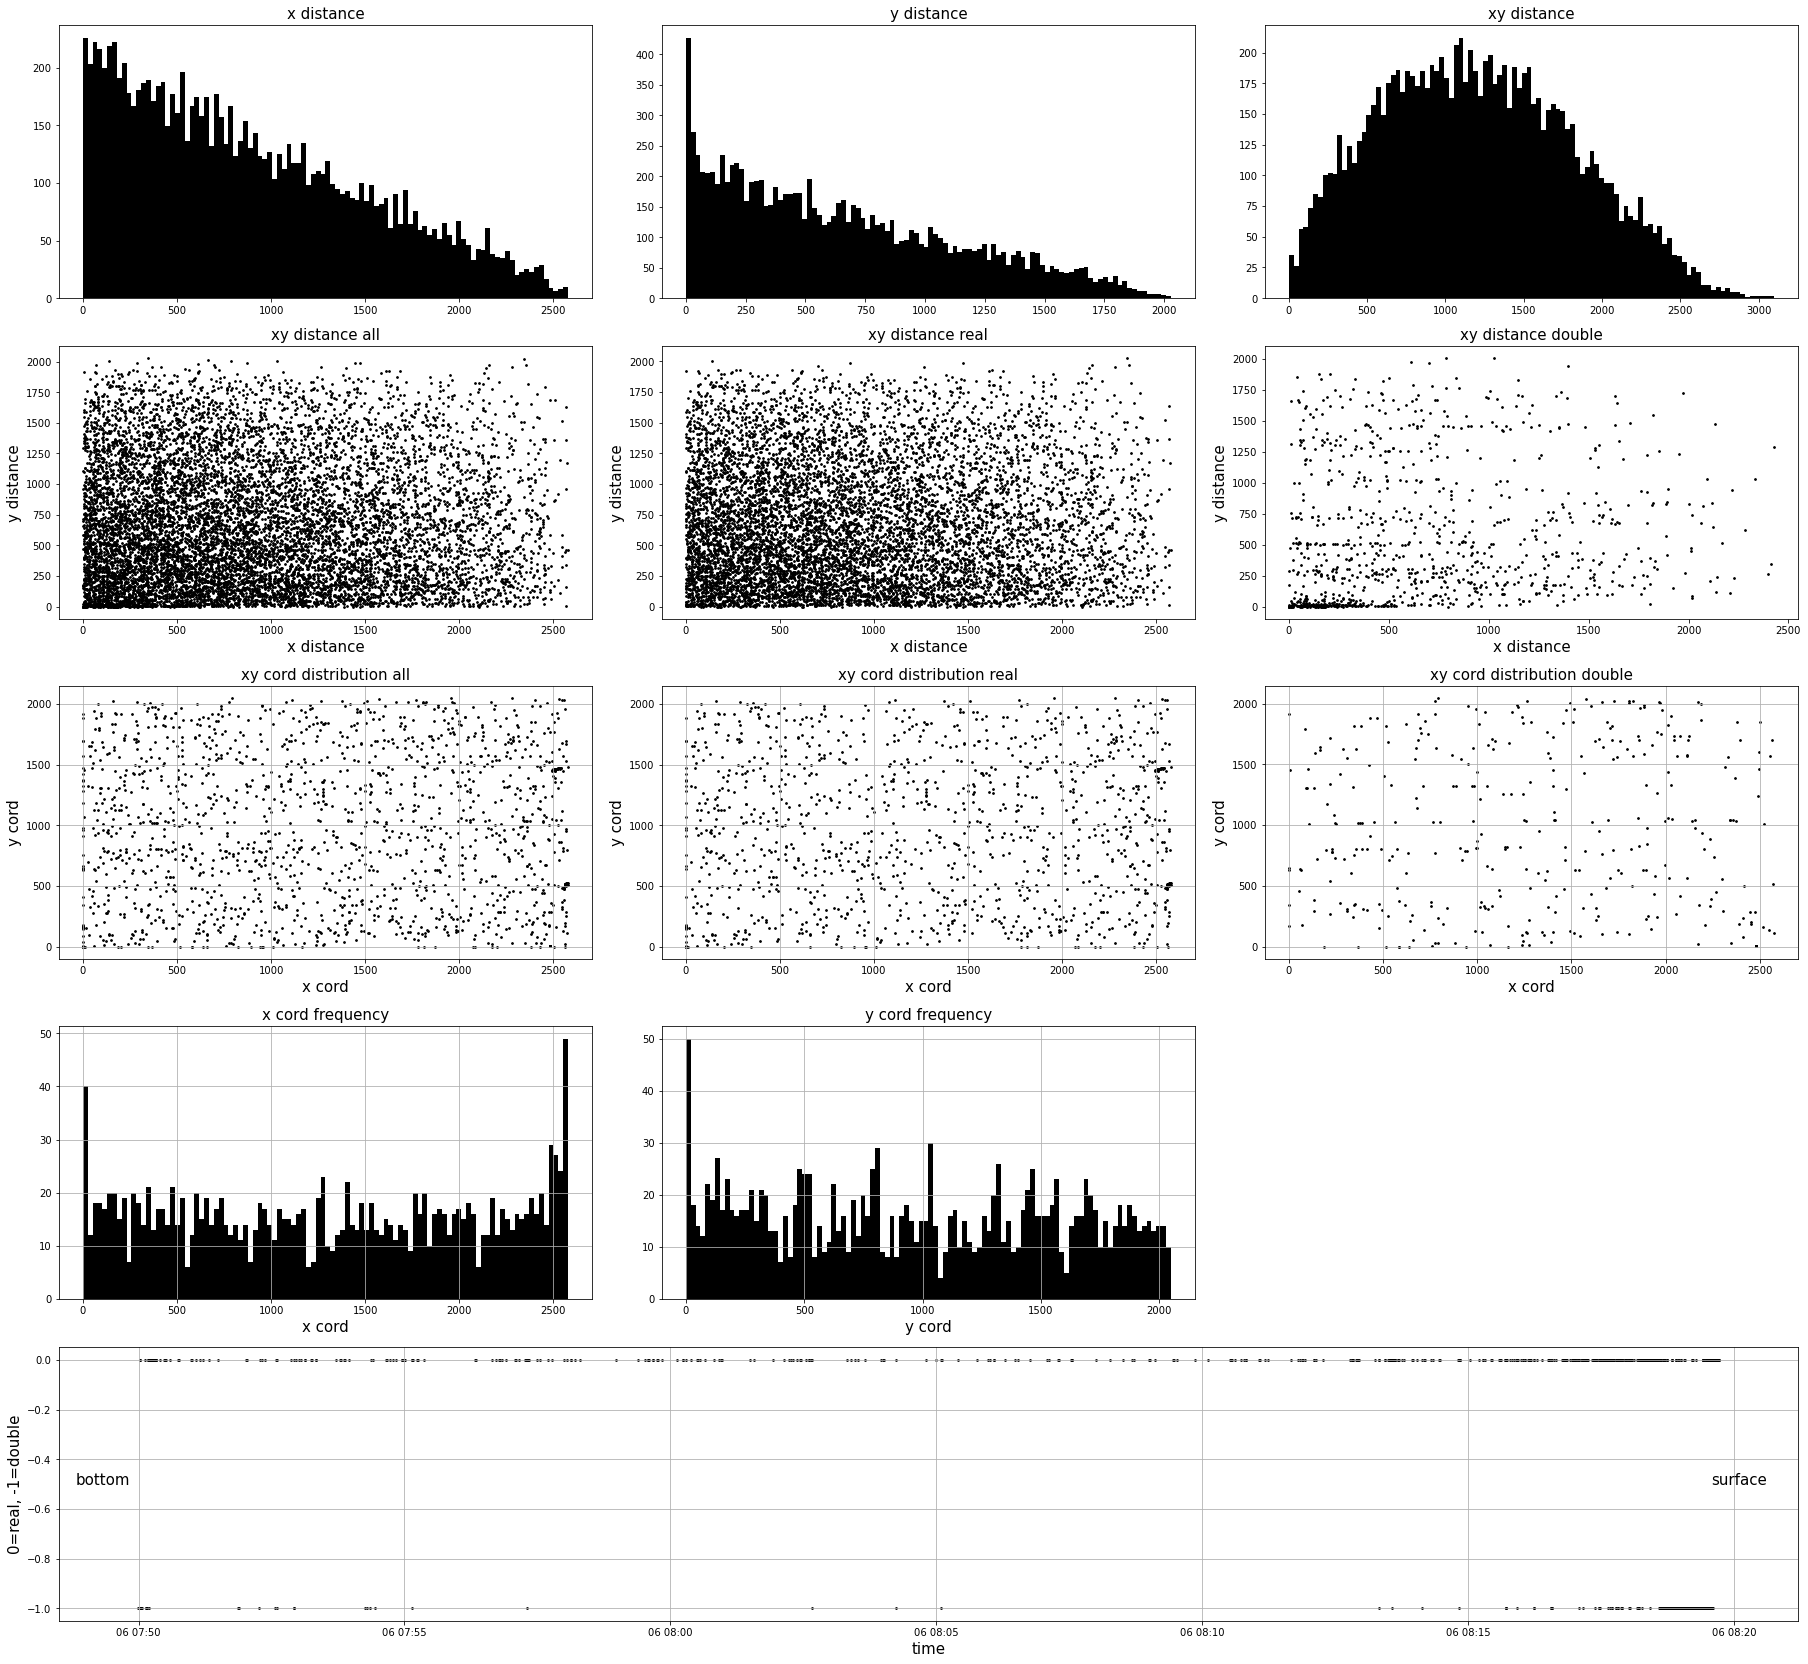

PS122-1-9-62


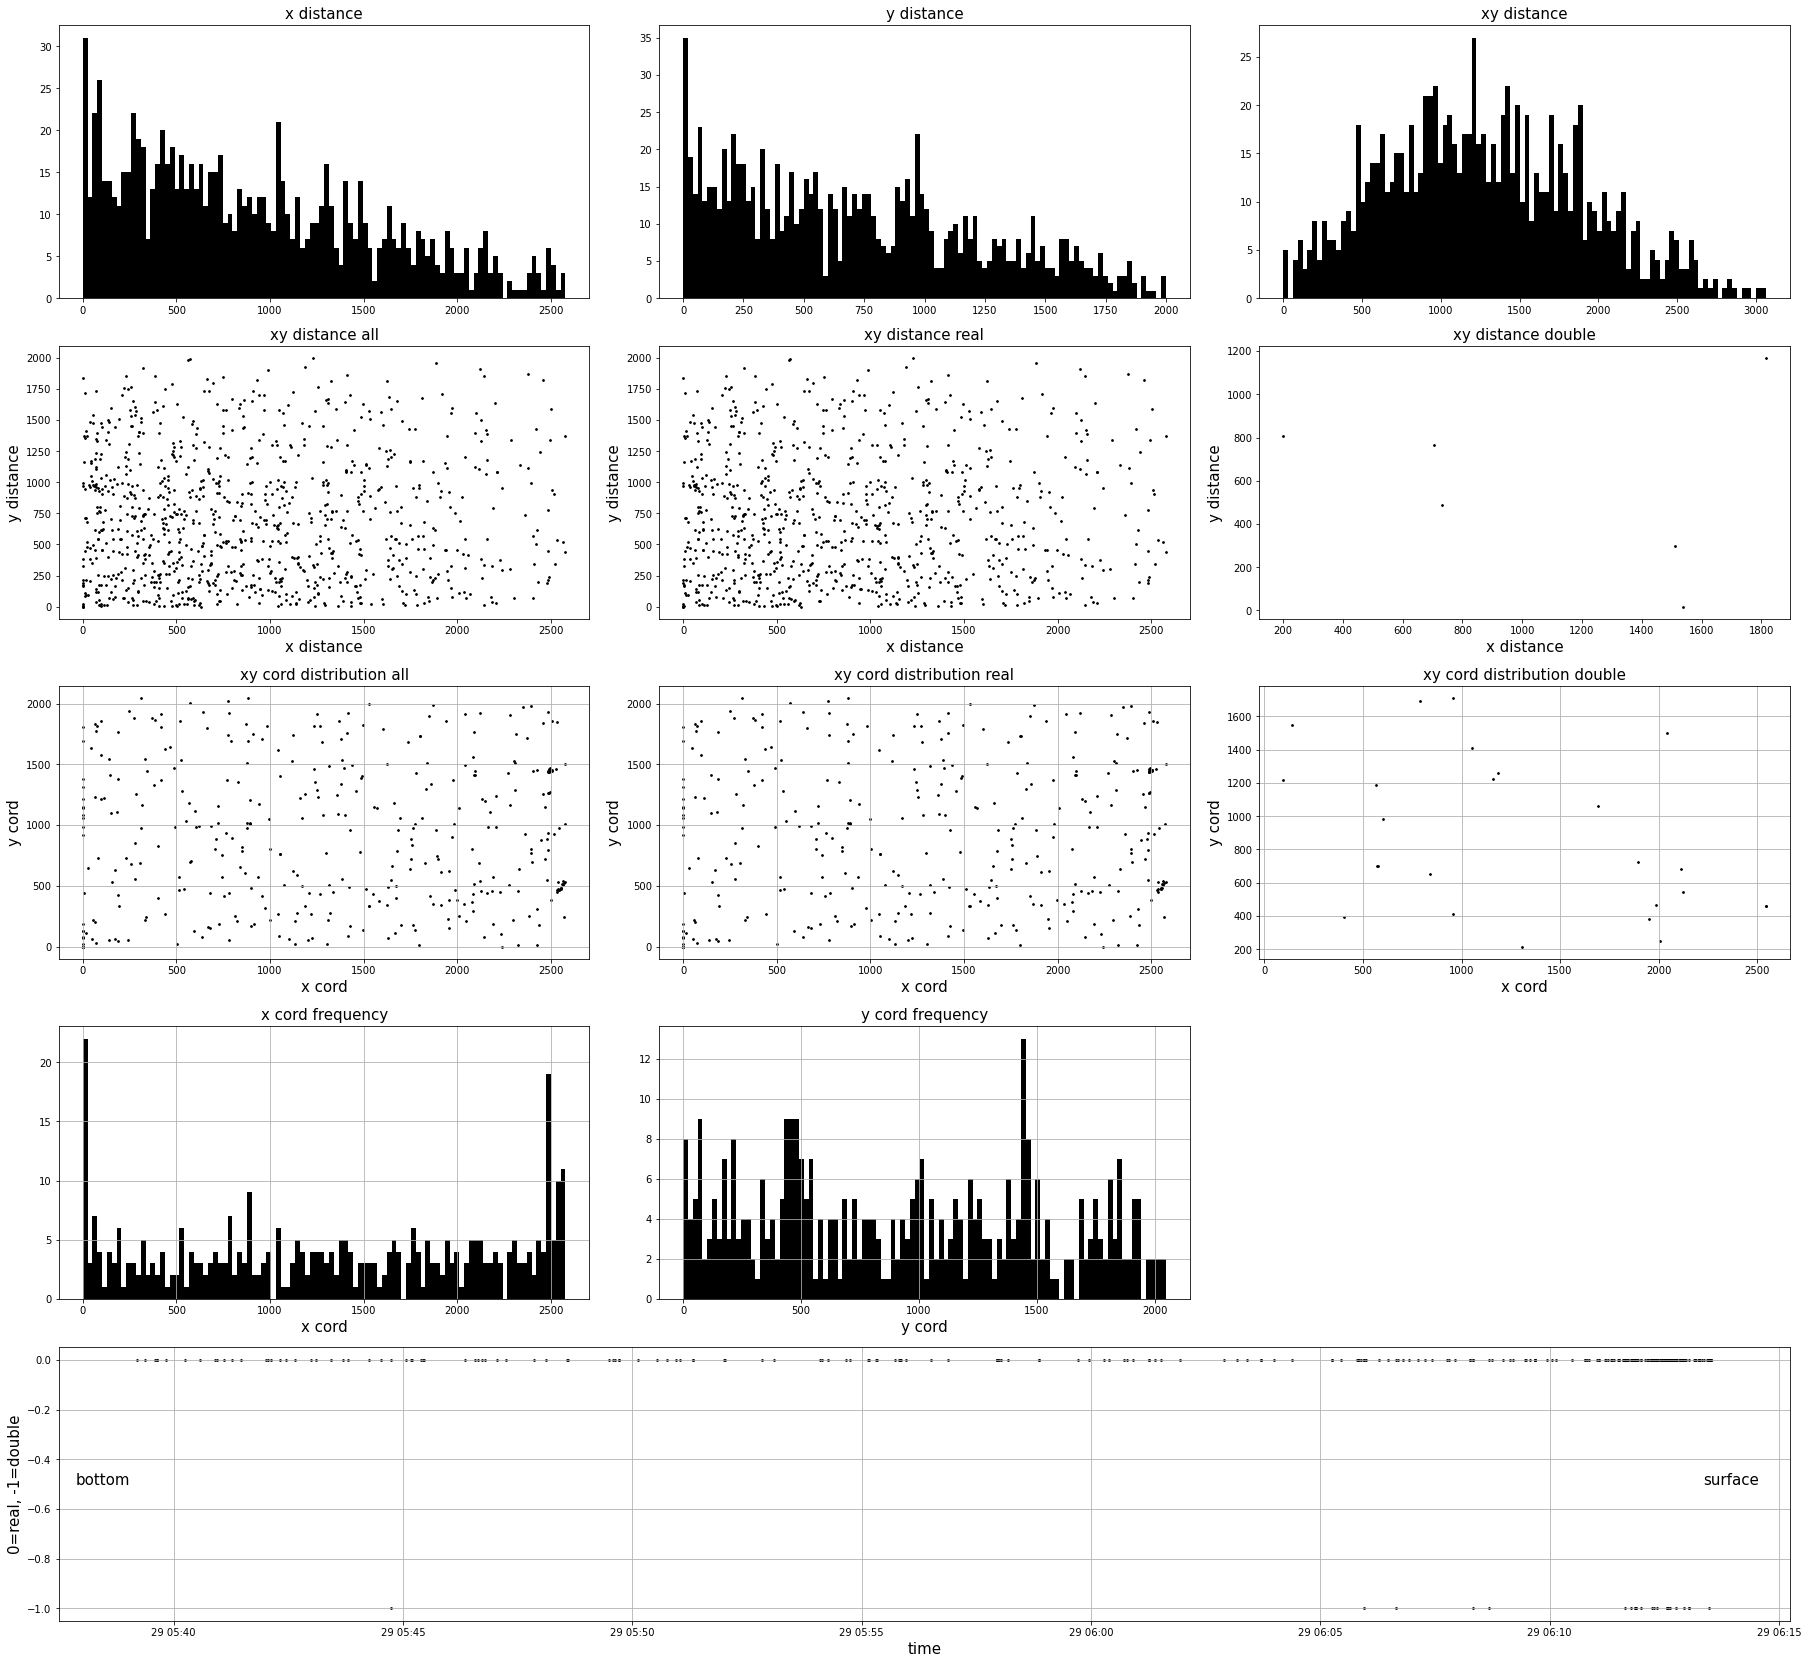

PS107-12


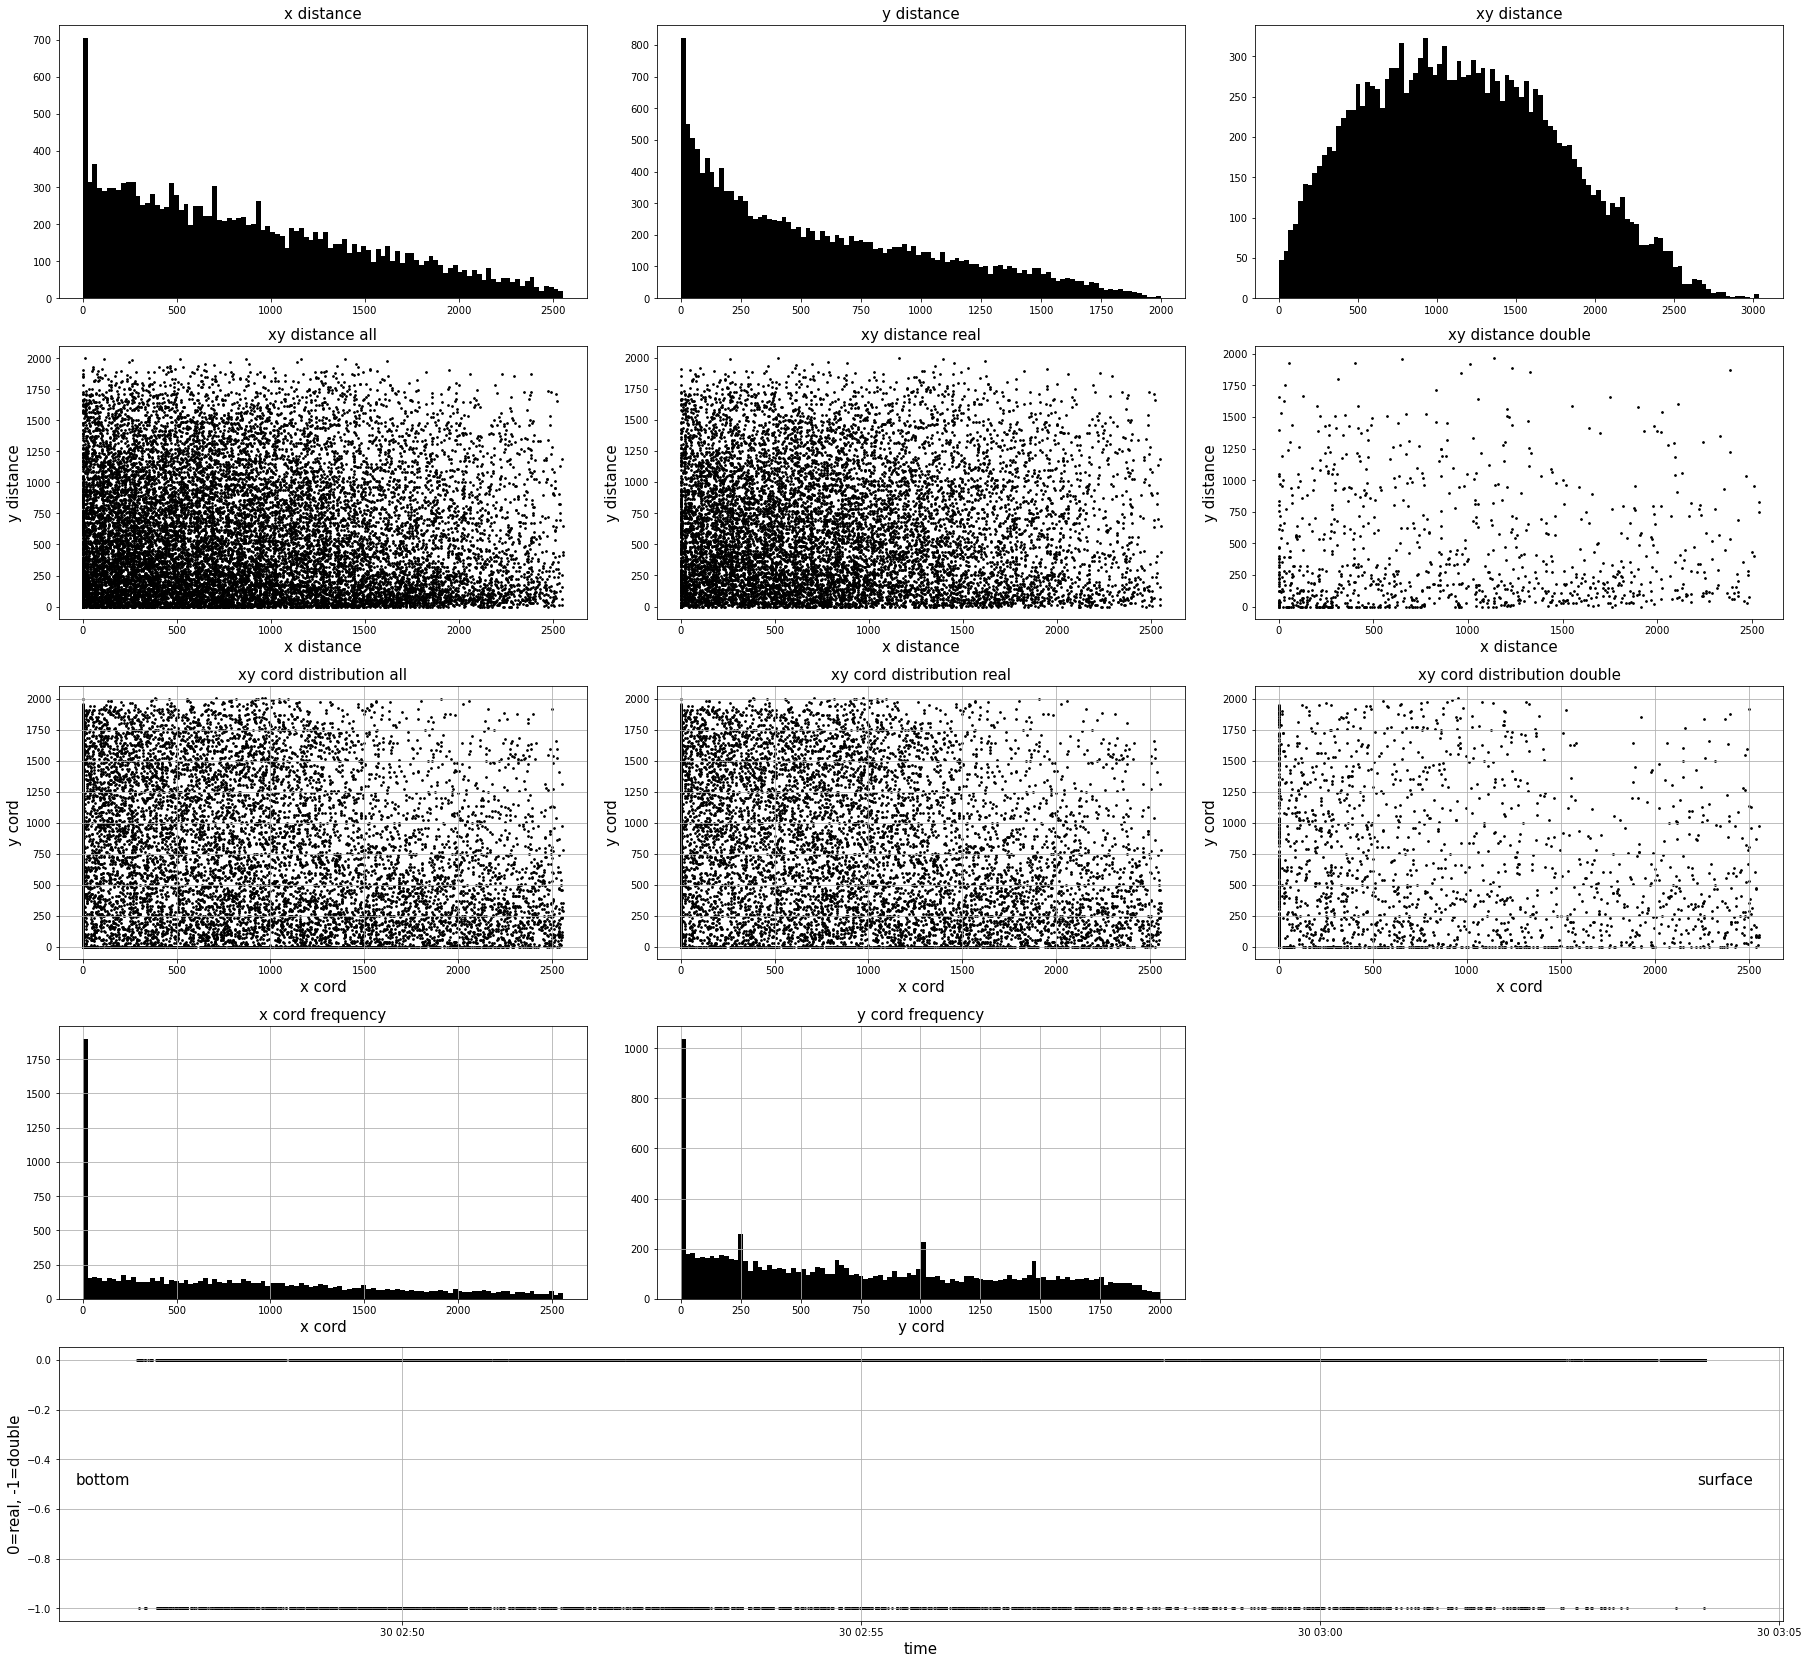

In [7]:
# check time and real, double distribution
for s in station:
    print(s)
    each_zoomie_df = zoomie_df[zoomie_df['object_station']==s]
    if each_zoomie_df.empty == True:
        pass
    else:
        
        # all image
        each_zoomie_df = each_zoomie_df.sort_values(by='img_file_name')
        x_cord_all = each_zoomie_df['img_file_name'].apply(lambda x: int(x.split(' ')[-2])).to_list()
        y_cord_all = each_zoomie_df['img_file_name'].apply(lambda x: int(x.split(' ')[-1].split('.')[0])).to_list()
        
        # real image
        real_df = each_zoomie_df[(each_zoomie_df['object_zoomie_state']=='real') & (each_zoomie_df['object_zoomie_deleted']==0)]
        x_cord_real = real_df['img_file_name'].apply(lambda x: int(x.split(' ')[-2])).to_list()
        y_cord_real = real_df['img_file_name'].apply(lambda x: int(x.split(' ')[-1].split('.')[0])).to_list()
        
        # doble image
        double_df = each_zoomie_df[(each_zoomie_df['object_zoomie_state']=='double') | (each_zoomie_df['object_zoomie_deleted']==1)]
        x_cord_double = double_df['img_file_name'].apply(lambda x: int(x.split(' ')[-2])).to_list()
        y_cord_double = double_df['img_file_name'].apply(lambda x: int(x.split(' ')[-1].split('.')[0])).to_list()
            
        
        # XY coordinate difference calculation
        real_mask = ((each_zoomie_df['object_zoomie_state']=='real') & (each_zoomie_df['object_zoomie_deleted']==0))
        time_info = each_zoomie_df['img_file_name'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1] + '  ' + x.split(' ')[3]).to_list()
        time_drop_duplicate = each_zoomie_df['img_file_name'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1] + '  ' + x.split(' ')[3]).drop_duplicates().to_list()
        
        # datetime format
        x_range = [] 
        for i in time_info:
            x_range.append(datetime.datetime.strptime(i, '%Y%m%d %H%M%S  %f'))
        real_mask = [0 if x == True else -1 for x in real_mask]
        
        
        ####
        # testing
        each_zoomie_df['x'] = pd.to_numeric(each_zoomie_df['img_file_name'].apply(lambda x: int(x.split(' ')[-2])))
        each_zoomie_df['y'] = pd.to_numeric(each_zoomie_df['img_file_name'].apply(lambda x: int(x.split(' ')[-1].split('.')[0])))
        
        real_df = pd.DataFrame()
        double_df = pd.DataFrame()
        dist_list = []
        y_dist_all = []
        x_dist_all = []
        
        y_dist_real = []
        x_dist_real = []
        
        y_dist_double = []
        x_dist_double = []        
        
        #pixel_list = []
        for t in range(0, len(time_drop_duplicate)-1):
            pic_df_before = each_zoomie_df[each_zoomie_df['img_file_name'].str.contains(time_drop_duplicate[t])]
            pic_df_after = each_zoomie_df[each_zoomie_df['img_file_name'].str.contains(time_drop_duplicate[t+1])]
            for b_row in pic_df_before.itertuples():
                for a_row in pic_df_after.itertuples():
                    dist = calDist(getattr(b_row, 'x'), getattr(b_row, 'y'), getattr(a_row, 'x'), getattr(a_row, 'y'))
                    dist_list.append(dist)
                    
                    y_dist = abs(getattr(a_row, 'y') - getattr(b_row, 'y'))
                    y_dist_all.append(y_dist)
                    
                    x_dist = abs(getattr(a_row, 'x') - getattr(b_row, 'x'))
                    x_dist_all.append(x_dist)
                    
                    if (getattr(a_row, 'object_zoomie_state')=='real')& (getattr(a_row, 'object_zoomie_deleted')==0) & (getattr(b_row, 'object_zoomie_state')=='real')& (getattr(b_row, 'object_zoomie_deleted')==0):
                        x_dist_real.append(x_dist)
                        y_dist_real.append(y_dist)
                    elif ((getattr(a_row, 'object_zoomie_state')=='double') | (getattr(a_row, 'object_zoomie_deleted')==1)) & ((getattr(b_row, 'object_zoomie_state')=='double') | (getattr(b_row, 'object_zoomie_deleted')==1)):
                        x_dist_double.append(x_dist)
                        y_dist_double.append(y_dist)                      
                        
                    
                    #p_dist = abs(getattr(a_row, 'object_area_px') - getattr(b_row, 'object_area_px'))
                    #pixel_list.append(p_dist)
                    
        
        # plotting
        fig = plt.figure(constrained_layout=True, figsize =(25, 23))
        gs = fig.add_gridspec(5, 3)
        
        # plotting 1
        ax1 = fig.add_subplot(gs[0,0])
        ax1.hist(x_dist_all, bins=100, color='black')
        ax1.set_title('x distance', fontsize=15)                 
        
        # plotting 2
        ax2 = fig.add_subplot(gs[0,1])
        ax2.hist(y_dist_all, bins=100, color='black')
        ax2.set_title('y distance', fontsize=15)

        # plotting 3
        ax3 = fig.add_subplot(gs[0,2])
        ax3.hist(dist_list, bins=100, color='black')
        ax3.set_title('xy distance', fontsize=15)
        
        # plotting 4
        ax4 = fig.add_subplot(gs[1,0])
        ax4.scatter(x_dist_all, y_dist_all, s=3, color='black')
        ax4.set_xlabel('x distance', fontsize=15)
        ax4.set_ylabel('y distance', fontsize=15)
        ax4.set_title('xy distance all', fontsize=15)
        
        # plotting 5
        ax5 = fig.add_subplot(gs[1,1])
        ax5.scatter(x_dist_real, y_dist_real, s=3, color='black')
        ax5.set_xlabel('x distance', fontsize=15)
        ax5.set_ylabel('y distance', fontsize=15)
        ax5.set_title('xy distance real', fontsize=15)
        
        # plotting 6
        ax6 = fig.add_subplot(gs[1,2])
        ax6.scatter(x_dist_double, y_dist_double, s=3, color='black')
        ax6.set_xlabel('x distance', fontsize=15)
        ax6.set_ylabel('y distance', fontsize=15)
        ax6.set_title('xy distance double', fontsize=15)
        
        
        # plotting 7
        ax7 = fig.add_subplot(gs[2,0]) # for all
        ax7.scatter(x_cord_all, y_cord_all, color='black', s=3)
        ax7.set_xlabel('x cord', fontsize=15)
        ax7.set_ylabel('y cord', fontsize=15)
        ax7.set_title('xy cord distribution all', fontsize=15)
        ax7.grid()
        
        # plotting 8
        ax8 = fig.add_subplot(gs[2,1]) # for all
        ax8.scatter(x_cord_real, y_cord_real, color='black', s=3)
        ax8.set_xlabel('x cord', fontsize=15)
        ax8.set_ylabel('y cord', fontsize=15)
        ax8.set_title('xy cord distribution real', fontsize=15)
        ax8.grid()
        
        
        # plotting 9
        ax9 = fig.add_subplot(gs[2,2]) # for all
        ax9.scatter(x_cord_double, y_cord_double, color='black', s=3)
        ax9.set_xlabel('x cord', fontsize=15)
        ax9.set_ylabel('y cord', fontsize=15)
        ax9.set_title('xy cord distribution double', fontsize=15)
        ax9.grid()
        
        
        # plotting 10
        ax10 = fig.add_subplot(gs[3,0]) # for all
        ax10.hist(x_cord_all, color='black', bins=100)
        ax10.set_xlabel('x cord', fontsize=15)
        ax10.set_title('x cord frequency', fontsize=15)
        ax10.grid()
        

        # plotting 11
        ax11 = fig.add_subplot(gs[3,1]) # for all
        ax11.hist(y_cord_all, color='black', bins=100)
        ax11.set_xlabel('y cord', fontsize=15)
        ax11.set_title('y cord frequency', fontsize=15)
        ax11.grid()
        
        
        # plotting 13
        ax13 = fig.add_subplot(gs[4,:])
        ax13.scatter(x_range, real_mask, color='black', s=3)        
        ax13.set_xlabel('time', fontsize=15)
        ax13.set_ylabel('0=real, -1=double', fontsize=15)
        ax13.grid()
        ax13.annotate('bottom', xy = (0.01, 0.5), xycoords="axes fraction", fontsize=15)
        ax13.annotate('surface', xy = (0.95, 0.5), xycoords="axes fraction", fontsize=15)
        
        plt.show()
        plt.close()
        
        '''
        fig = plt.figure(figsize=(8, 5))
        pixel_200000 = [x for x in pixel_list if x<=200000]
        plt.hist(pixel_200000, bins = 100, color='black')
        plt.set_title('pixel difference')
        plt.set_xlim(0, 200000)
        '''


In [ ]:
# check time and real, double distribution
for s in station:
    print(s)
    each_zoomie_df = zoomie_df[zoomie_df['object_station']==s]
    if each_zoomie_df.empty == True:
        pass
    else:
        each_zoomie_df = each_zoomie_df.sort_values(by='img_file_name')
        real_mask = ((each_zoomie_df['object_zoomie_state']=='real') & (each_zoomie_df['object_zoomie_deleted']==0))
        time_info = each_zoomie_df['img_file_name'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1] + '  ' + x.split(' ')[3]).to_list()
        time_drop_duplicate = each_zoomie_df['img_file_name'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1] + '  ' + x.split(' ')[3]).drop_duplicates().to_list()
        
        
        # datetime format
        x_range = [] 
        for i in time_info:
            x_range.append(datetime.datetime.strptime(i, '%Y%m%d %H%M%S  %f'))
        real_mask = [0 if x == True else -1 for x in real_mask]
        
        
        ########
        # testing
        each_zoomie_df['x'] = pd.to_numeric(each_zoomie_df['img_file_name'].apply(lambda x: int(x.split(' ')[-2])))
        each_zoomie_df['y'] = pd.to_numeric(each_zoomie_df['img_file_name'].apply(lambda x: int(x.split(' ')[-1].split('.')[0])))
        
        dist_list = []
        for t in range(0, len(time_drop_duplicate)-1):
            pic_df_before = each_zoomie_df[each_zoomie_df['img_file_name'].str.contains(time_drop_duplicate[t])]
            pic_df_after = each_zoomie_df[each_zoomie_df['img_file_name'].str.contains(time_drop_duplicate[t+1])]
            for b_idx, b_row in pic_df_before.iterrows():
                dist_each = [] # calculate before dataframe and after dataframe
                for a_idx, a_row in pic_df_after.iterrows():
                    dist = calDist(b_row['x'], b_row['y'], a_row['x'], a_row['y'])
                    x_dif = abs(b_row['x']-a_row['x'])
                    y_dif = abs(b_row['y']-a_row['y'])
                    pixel_dif = abs(b_row['object_area_px']-a_row['object_area_px'])
                    
                    #print('before', b_row['x'], b_row['y'], b_row['object_area_px'])
                    #print('after', a_row['x'], a_row['y'], a_row['object_area_px'])
                    #print('dist', dist)
                    
                    dist_list.append(dist)
                    dist_each.append(dist)
                    
                dist_num = [100, 300, 500, 800, 1000, 1300, 1500, 1800, 2300, 2500, 3000]
                x_dif_num = [800, 900, 1000, 1200, 1400, 1600, 1800, 2000]
                for d in x_dif_num:
                    if (x_dif < d)& (pixel_dif<6000): # condition 1. any(x <= d for x in dist_each) 2. (x_dif > y_dif) 3. & (pixel_dif<6000)
                        each_zoomie_df.loc[b_idx, 'new_estimate_%s' %(d,)] = 'double' # add column 'new double' for suspiscous double image
                    else:
                        each_zoomie_df.loc[b_idx, 'new_estimate_%s' %(d,)] = 'real' # add column 'new real' for suspiscous real image
        
        # estimation
        dist_num = [100, 300, 500, 800, 1000, 1300, 1500, 1800, 2300, 2500, 3000]
        x_dif_num = [800, 900, 1000, 1200, 1400, 1600, 1800, 2000]
        est_y = []
        for d in x_dif_num:
            
            est = each_zoomie_df['new_estimate_%s' %(d,)].to_list()
            est_mask = [-0.2 if x == 'real' else -0.8 for x in est]
            percent = (est_mask.count(-0.8) / len(est_mask))*100
            est_y.append(percent)
        
        manual_percent = (real_mask.count(-1) / len(real_mask))*100

        
        
        ##########
        # plotting
        #print('manual', (real_mask.count(-1) / len(real_mask))*100,'%')
        #print('automatic', (est_mask.count(-0.8) / len(est_mask))*100,'%')
        
        fig = plt.figure(constrained_layout=True, figsize =(18, 10))
        gs = fig.add_gridspec(2, 2)
        
        ax1 = fig.add_subplot(gs[0,0])
        ax1.plot(x_dif_num, est_y, color='red')
        ax1.axhline(y=manual_percent, color='black', linestyle='-')
        ax1.set_ylim(0, 100)
        ax1.set_ylabel('double image percent (%)', fontsize=15)
        ax1.set_xlabel('set distance criteria', fontsize=15) 
        
        ax2 = fig.add_subplot(gs[1,:])
        ax2.scatter(x_range, real_mask, color='black', s=3)
        ax2.scatter(x_range, est_mask, color='red', s=3)
        
        ax2.set_xlabel('time', fontsize = 15)
        ax2.set_ylabel('0;real, -1;double, -0.2;est_real, -0.8;est_double ', fontsize = 15)
        ax2.grid()
        ax2.annotate('bottom', xy = (0.01, 0.5), xycoords="axes fraction", fontsize = 15)
        ax2.annotate('surface', xy = (0.95, 0.5), xycoords="axes fraction", fontsize = 15)
        
        
        os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
        fig_name = str('xdif1500_'+'pix6000'+s+'.png')
        plt.savefig(fig_name, facecolor='w')
        plt.close()
        
        #plt.show()
        #plt.close()


# particle VS zooplankton

In [10]:
file_path = os.path.expanduser('~/Git/OCEANpy/data')
loki_df = export_sql('loki', ['ps107'], 'awi_server')
ctd_df = export_sql('ctd', 'ctd_meta', 'local')
isc_stb = export_sql('isc', 'isc_meta', 'local')
isc_file_list = glob.glob(file_path+os.sep+'isc'+os.sep+'*.xlsx')
isc_each_df = isc_stb[isc_stb['cruise_station_haul'].str.contains('PS107') & isc_stb['profile_number'].notnull()] # select based on the cruise
print(list(loki_df))
print(list(ctd_df))


['vessel', 'cruise', 'station', 'region', 'latitude', 'longitude', 'bottom_depth', 'date_time', 'loki_depth', 'temperatue', 'salinity', 'oxygen', 'fluorescence', 'manual_classification', 'developmental_stage', 'area_pixel', 'area_sqrmm', 'spec_length', 'spec_width', 'image_filename', 'animal', 'copepod', 'phylum', 'class', 'spec_order', 'family', 'genus', 'species']
['Event', 'Date/Time', 'Latitude', 'Longitude', 'Elevation [m]', 'Depth water [m]', 'Press [dbar]', 'Temp [°C]', 'Cond [mS/cm]', 'Sal', 'Tpot [°C]', 'Sigma-theta [kg/m**3]', 'O2 [µmol/l]', 'O2 sat [%]', 'Attenuation [arbitrary units]', 'Fluorometer [arbitrary units]', 'NOBS [#]']


In [88]:
for index, value in isc_each_df.iterrows():
    # select one station from one isc station and get cruise name, station number and profilenumber of ISC
    cruise, station, profile_num = value['cruise_station_haul'].split('_')[0], int(float(value['cruise_station_haul'].split('_')[1])), int(float(value['profile_number']))
    
    # Based on the cruise and profilenumber of ISC import data from excel file
    isc_excel = str('IR'+str(profile_num).zfill(2)+'_DownCast_'+cruise+'.xlsx')
    for i in isc_file_list:
        if i.split(os.sep)[-1] == isc_excel:
            particle_range = [150, 500, 1000, 100000]
            
            # from here specific station.
            isc_ctd_df, vol_spec_df, aggr_con_df, size_spec_df = isc_xlsx(i, 10, particle_range)
            vol, abd, isc_ctd, ctd_dict = isc_summary(isc_ctd_df, vol_spec_df, aggr_con_df, particle_range)
            loki_station_df = loki_df[loki_df['station'].str.contains(cruise+'_'+str(station).zfill(3)) & loki_df['animal']==True] # select corresponding loki station
            if loki_station_df.empty:
                continue
            else:
                print(value['cruise_station_haul'])
                ctd_station_df = ctd_df[ctd_df['Event'].str.contains(cruise+'_'+str(station))] # select corresponding ctd station
                Sal = tuple(pd.to_numeric(ctd_station_df['Sal']))
                Depth = tuple(pd.to_numeric(ctd_station_df['Depth water [m]']))
                Temp = tuple(pd.to_numeric(ctd_station_df['Temp [°C]']))
                Fluo = tuple(pd.to_numeric(ctd_station_df['Fluorometer [arbitrary units]']))
                
                copepoda_df = loki_station_df[loki_station_df['copepod']==True] # df only for copepoda
                copepoda_depth = copepoda_df['loki_depth'].to_list()
                
                oncaeidae_df = loki_station_df[loki_station_df['family']=='Oncaeidae'] # df only for copepoda
                oncaeidae_depth = oncaeidae_df['loki_depth'].to_list()
                
                calanidae_df = loki_station_df[loki_station_df['family']=='Calanidae'] # df only for copepoda
                calanidae_depth = calanidae_df['loki_depth'].to_list()
                
                metridinidae_df = loki_station_df[loki_station_df['family']=='Metridinidae'] # df only for copepoda
                metridinidae_depth = metridinidae_df['loki_depth'].to_list()
                
                loki_family_dict = dict(loki_station_df['family'].value_counts())
                
                
                fig = plt.figure(constrained_layout=True, figsize =(20, 18))
                gs = fig.add_gridspec(3, 4)
                
                #fig, axs = plt.subplots(6,3, figsize = (10, 25))
                #axs = axs.ravel()

                # 1st plot for temperature and salanity and Fluorescence / data from CTD
                ### CTD ###
                ax1 = fig.add_subplot(gs[0,0])
                ax1.plot(Sal, Depth, color ='blue', linewidth= 1)
                ax1.set_ylabel(ctd_dict['depth'], color ='black', fontsize=15)
                ax1.set_xlabel(ctd_dict['sal'], color = 'blue', fontsize=15)
                ax1.set_xlim(30, 36)
                ax1.set_ylim(0,500)
                ax1.annotate('CTD', xy=(0.05, 0.05), xycoords='axes fraction', fontsize=10)

                sec_axs = ax1.twiny()
                sec_axs.plot(Temp, Depth, color='red', linewidth= 1)
                sec_axs.set_xlabel(ctd_dict['temp'], color = 'red', fontsize=15)
                sec_axs.set_xlim(-3, 9)
                
                thr_axs = ax1.twiny()
                thr_axs.spines['bottom'].set_position(('outward', 40))  # make new outmost axis                  
                thr_axs.xaxis.set_ticks_position('bottom')
                thr_axs.xaxis.set_label_position('bottom')
                thr_axs.plot(Fluo, Depth, color='green', linewidth= 1)
                thr_axs.set_xlabel(ctd_dict['fluo'], color = 'green', fontsize=15)
                thr_axs.set_xlim(-0.5, 6)
                thr_axs.invert_yaxis()
                
                # 2nd plot TS diagram                
                mint= -2 # contour for density
                maxt= 6
                mins= 30
                maxs= 36
                
                tempL=np.linspace(mint-1,maxt+1,156)
                salL=np.linspace(mins-1,maxs+1,156)
                
                Tg, Sg = np.meshgrid(tempL,salL)
                sigma_theta = gsw.sigma0(Sg, Tg)
                cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),156) # density contour data generated
                
                ax2 = fig.add_subplot(gs[0,1])
                sc = ax2.scatter(Sal, Temp, c=Depth, cmap = 'jet_r', s=10)
                cs = ax2.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1)
                cl=plt.clabel(cs,fontsize=13,inline=True,fmt='%.1f')
                
                ax2.set_xlim(30, 36)
                ax2.set_ylim(-2, 6)
                ax2.set_title('TS diagram', fontsize=15)
                ax2.set_xlabel('Salinity [PSU]', fontsize=15)
                ax2.set_ylabel('Temperature [dC]', fontsize=15)

                cbar = plt.colorbar(sc)
                cbar.ax.set_ylabel('Depth [m]', rotation=270, labelpad=15, fontsize=15)

                # 3rd plot copepoda
                ax3 = fig.add_subplot(gs[1,:3])
                ax3.bar(loki_family_dict.keys(), loki_family_dict.values(), color='black') # family abundance check
                ax3.tick_params(rotation=90)
                
                # 4th plot all copepoda profile with particle abd and vol
                ax4 = fig.add_subplot(gs[1,3])
                ax4.plot(abd['abd_tol'], isc_ctd['depth'], color='red', linewidth= 1)
                ax4.set_xlabel('total particle abundance [count]', color = 'red', fontsize=15)
                ax4.set_ylim(0,500)

                sec_axs = ax4.twiny()
                sec_axs.hist(copepoda_depth, orientation='horizontal', bins = int(max(copepoda_depth)/10), edgecolor='black', alpha=0.1, color='black')
                sec_axs.set_xlim(0,300)
                sec_axs.set_xlabel('copepoda [count]', color = 'black', fontsize=15)
                sec_axs.invert_yaxis()
                
                
                # each sp. level
                ax5 = fig.add_subplot(gs[2,0])
                ax5.plot(abd['abd_tol'], isc_ctd['depth'], color='red', linewidth= 1)
                ax5.set_xlabel('total particle abundance [count]', color = 'red', fontsize=15)
                ax5.set_ylim(0,500)

                sec_axs = ax5.twiny()
                sec_axs.hist(oncaeidae_depth, orientation='horizontal', bins = int(max(copepoda_depth)/10), edgecolor='black', alpha=0.1, color='black')
                sec_axs.set_xlim(0,300)
                sec_axs.set_xlabel('oncaeidae [count]', color = 'black', fontsize=15)
                sec_axs.invert_yaxis()
                
                
                ax6 = fig.add_subplot(gs[2,1])
                ax6.plot(abd['abd_tol'], isc_ctd['depth'], color='red', linewidth= 1)
                ax6.set_xlabel('total particle abundance [count]', color = 'red', fontsize=15)
                ax6.set_ylim(0,500)

                sec_axs = ax6.twiny()
                sec_axs.hist(calanidae_depth, orientation='horizontal', bins = int(max(copepoda_depth)/10), edgecolor='black', alpha=0.1, color='black')
                sec_axs.set_xlim(0,300)
                sec_axs.set_xlabel('calanidae [count]', color = 'black', fontsize=15)
                sec_axs.invert_yaxis()
                
                
                ax7 = fig.add_subplot(gs[2,2])
                ax7.plot(abd['abd_tol'], isc_ctd['depth'], color='red', linewidth= 1)
                ax7.set_xlabel('total particle abundance [count]', color = 'red', fontsize=15)
                ax7.set_ylim(0,500)

                sec_axs = ax7.twiny()
                sec_axs.hist(metridinidae_depth, orientation='horizontal', bins = int(max(copepoda_depth)/10), edgecolor='black', alpha=0.1, color='black')
                sec_axs.set_xlim(0,300)
                sec_axs.set_xlabel('metridinidae [count]', color = 'black', fontsize=15)
                sec_axs.invert_yaxis()

                os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
                fig_name = str('ISC_LOKI_'+value['cruise_station_haul']+'.png')
                plt.savefig(fig_name, facecolor='w')
                plt.close()

PS107_10_3
PS107_12_2
PS107_14_7
PS107_16_2


# create TS diagram

In [ ]:
ctd_df = export_sql('ctd', 'ctd_meta')
#station_list = ['PS107_18']
#ctd_df = ctd_df.loc[ctd_df['Event'].str.contains('|'.join(station_list))]
ctd_df = ctd_df.loc[pd.to_numeric(ctd_df['Depth water [m]']) <=1000]
depth = tuple(pd.to_numeric(ctd_df['Depth water [m]']))
sal = tuple(pd.to_numeric(ctd_df['Sal']))
temp = tuple(pd.to_numeric(ctd_df['Temp [°C]']))
TSD_dict = {'temp': temp, 'sal': sal, 'depth':depth}
TS_diagram(TSD_dict)


# create contour plot

In [ ]:
ctd_df = export_sql('ctd', 'ctd_meta'); print(list(ctd_df))
station_list = ['PS107_10', 'PS107_12', 'PS107_14', 'PS107_16', 'PS107_18']
cols_to_use = ['Latitude', 'Longitude', 'Depth water [m]', 'Press [dbar]']
ctd_df_filter = ctd_df.loc[ctd_df['Event'].str.contains('|'.join(station_list))] # select by station
#ctd_df_filter = ctd_df_filter[cols_to_use] # select only necessary columns
ctd_df_filter = ctd_df.loc[(pd.to_numeric(ctd_df['Latitude']) >=78.9) & (pd.to_numeric(ctd_df['Latitude']) <=79.1)] # select by lat and lon
ctd_df_filter = ctd_df_filter.loc[(pd.to_numeric(ctd_df_filter['Depth water [m]']) <=1000)]
ctd_df_filter = ctd_df_filter.dropna() # drop rows having empty value (empty values will affect contouring method)

ctd_df_filter['d_n'] = ctd_df_filter.apply(lambda row: day_night(float(row['Latitude']), float(row['Longitude']), datetime.strptime(row['Date/Time'], '%Y-%m-%dT%H:%M')), axis=1 )
ctd_df_filter = ctd_df_filter.loc[ctd_df_filter['d_n'] == 'day']

depth = [i*(-1) for i in list(pd.to_numeric(ctd_df_filter['Depth water [m]']).values)]
lat = list(pd.to_numeric(ctd_df_filter['Latitude']).values)
lon = list(pd.to_numeric(ctd_df_filter['Longitude']).values)
z = list(pd.to_numeric(ctd_df_filter['Press [dbar]']).values)

ctd_array = np.array((lat, lon, z, depth)).transpose() # create array

topo = bathy_data (75, 83, -30, 20)
contour_ver(topo, 'lat', 79, (-5, 10), ctd_array)
#contour_ver(topo, 'lon', 79, (-5, 10), ctd_array)





# create station map

In [ ]:
isc_df = export_sql('isc', 'isc_meta')
cruise_list = ('PS107', 'PS114', 'PS121')
cruise_dict = {}
for cruise in cruise_list:
    cruise_df = isc_df[isc_df['cruise_station_haul'].str.contains(cruise)]
    cruise_dict[cruise] = (tuple(pd.to_numeric(cruise_df['lat'])) , tuple(pd.to_numeric(cruise_df['lon'])))

topo = bathy_data (75, 83, -30, 20) # -30, 30, 75, 85
station_map(cruise_dict, topo)

# get data from SQL

In [ ]:
action = 'export'
if action == 'export':
    edit = ['ps107'] # cruise name (in list, case insensitive) for AWI server and table name for local
    df = export_sql('loki', edit, 'awi_server')
    print(df)

elif action == 'import':
    filepath = os.path.expanduser('~/Git/OCEANpy/data/loki/LOKI_station.xlsx')
    df = pd.read_excel(filepath)
    # df = raw_ctd_to_df(filepath) # processing for raw ctd file
    import_sql('loki', 'loki_meta', df, 'replace')

# ISC data

In [ ]:
file_path = os.path.expanduser('~/Git/OCEANpy')
for excel_file in glob.glob(file_path+os.sep+'data'+os.sep+'isc'+os.sep+'IR*.xlsx'):
    particle_range = [150, 500, 1000, 100000]
    ctd_df, vol_spec_df, aggr_con_df, size_spec_df = isc_xlsx(excel_file, 10, particle_range)
    vertical_plot(ctd_df, vol_spec_df, aggr_con_df, excel_file.split(os.sep)[-1].replace('.xlsx', ''), particle_range)

# other code

In [ ]:
for index, value in isc_each_df.iterrows():
    # select one station from one isc station and get cruise name, station number and profilenumber of ISC
    cruise, station, profile_num = value['cruise_station_haul'].split('_')[0], int(float(value['cruise_station_haul'].split('_')[1])), int(float(value['profile_number']))
    
    # Based on the cruise and profilenumber of ISC import data from excel file
    isc_excel = str('IR'+str(profile_num).zfill(2)+'_DownCast_'+cruise+'.xlsx')
    for i in isc_file_list:
        if i.split(os.sep)[-1] == isc_excel:
            particle_range = [150, 500, 1000, 100000]
            
            # from here specific station.
            isc_ctd_df, vol_spec_df, aggr_con_df, size_spec_df = isc_xlsx(i, 10, particle_range)
            vol, abd, isc_ctd, ctd_dict = isc_summary(isc_ctd_df, vol_spec_df, aggr_con_df, particle_range)
            loki_station_df = loki_df[loki_df['station'].str.contains(cruise+'_'+str(station).zfill(3)) & loki_df['animal']==True] # select corresponding loki station
            if loki_station_df.empty:
                continue
            else:
                ctd_station_df = ctd_df[ctd_df['Event'].str.contains(cruise+'_'+str(station))] # select corresponding ctd station
                
                copepoda_df = loki_station_df[loki_station_df['copepod']==True] # df only for copepoda
                copepoda_depth = copepoda_df['loki_depth'].to_list()
                
                oncaeidae_df = loki_station_df[loki_station_df['family']=='Oncaeidae'] # df only for copepoda
                oncaeidae_depth = oncaeidae_df['loki_depth'].to_list()
                
                calanidae_df = loki_station_df[loki_station_df['family']=='Calanidae'] # df only for copepoda
                calanidae_depth = calanidae_df['loki_depth'].to_list()
                
                metridinidae_df = loki_station_df[loki_station_df['family']=='Metridinidae'] # df only for copepoda
                metridinidae_depth = metridinidae_df['loki_depth'].to_list()
                
                loki_family_dict = dict(loki_station_df['family'].value_counts())
                
                
                fig = plt.figure(constrained_layout=True, figsize =(10, 25))
                gs = fig.add_gridspec(6, 3)
                
                #fig, axs = plt.subplots(6,3, figsize = (10, 25))
                #axs = axs.ravel()

                # 1st plot for temperature and salanity / data from CTD, ISC CTD, LOKI CTD
                ### CTD ###
                ax1 = fig.add_subplot(gs[0,0])
                ax1.plot(tuple(pd.to_numeric(ctd_station_df['Temp [°C]'])), tuple(pd.to_numeric(ctd_station_df['Depth water [m]'])), color='red', linewidth= 1, alpha=0.7)
                ax1.set_ylabel(ctd_dict['depth'], color ='black')
                ax1.set_xlabel(ctd_dict['temp'], color = 'red')
                ax1.set_xlim(-3, 9)
                ax1.set_ylim(0,500)
                ax1.invert_yaxis()
                ax1.annotate('CTD', xy=(0.05, 0.05), xycoords='axes fraction', fontsize=10)

                sec_axs = ax1.twiny()
                sec_axs.plot(tuple(pd.to_numeric(ctd_station_df['Sal'])), tuple(pd.to_numeric(ctd_station_df['Depth water [m]'])), color ='blue', linewidth= 1, alpha=0.7)
                sec_axs.set_xlabel(ctd_dict['sal'], color = 'blue')
                sec_axs.set_xlim(30, 36)
                
                ### ISC CTD ###
                ax2 = fig.add_subplot(gs[0,1])
                ax2.plot(isc_ctd['temp'], isc_ctd['depth'], color='red', linewidth= 1, alpha=0.7)
                ax2.set_ylabel(ctd_dict['depth'], color ='black')
                ax2.set_xlabel(ctd_dict['temp'], color = 'red')
                ax2.set_xlim(-3, 9)
                ax2.set_ylim(0,500)
                ax2.invert_yaxis()
                ax2.annotate('ISC CTD', xy=(0.05, 0.05), xycoords="axes fraction", fontsize=10)

                sec_axs = ax2.twiny()
                sec_axs.plot(isc_ctd['sal'], isc_ctd['depth'], color ='blue', linewidth= 1, alpha=0.7)
                sec_axs.set_xlabel(ctd_dict['sal'], color = 'blue')
                sec_axs.set_xlim(30, 36)
                
                ### LOKI CTD ###
                ax3 = fig.add_subplot(gs[0,2])
                ax3.plot(loki_station_df['temperatue'], loki_station_df['loki_depth'], color='red', linewidth= 1, alpha=0.7)
                ax3.set_ylabel(ctd_dict['depth'], color ='black')
                ax3.set_xlabel(ctd_dict['temp'], color = 'red')
                ax3.set_xlim(-3, 9)
                ax3.set_ylim(0,500)
                ax3.invert_yaxis()
                ax3.annotate('LOKI CTD', xy=(0.05, 0.05), xycoords="axes fraction", fontsize=10)

                sec_axs = ax3.twiny()
                sec_axs.plot(loki_station_df['salinity'], loki_station_df['loki_depth'], color ='blue', linewidth= 1, alpha=0.7)
                sec_axs.set_xlabel(ctd_dict['sal'], color = 'blue')
                sec_axs.set_xlim(30, 36)
                
                # 2nd plot for turbidity and Fluorescence / data from CTD, ISC CTD, LOKI CTD
                ### CTD ###
                ax4 = fig.add_subplot(gs[1,0])
                ax4.plot(tuple(pd.to_numeric(ctd_station_df['Fluorometer [arbitrary units]'])), tuple(pd.to_numeric(ctd_station_df['Depth water [m]'])), color='red', linewidth= 1, alpha=0.7)
                ax4.set_ylabel(ctd_dict['depth'], color ='black')
                ax4.set_xlabel(ctd_dict['fluo'], color = 'red')
                ax4.set_xlim(-0.5, 6)
                ax4.set_ylim(0,500)
                ax4.invert_yaxis()
                ax4.annotate('CTD', xy=(0.05, 0.05), xycoords="axes fraction", fontsize=10)
                
                ### ISC CTD ###
                ax5 = fig.add_subplot(gs[1,1])
                ax5.plot(isc_ctd['fluo'], isc_ctd['depth'], color='red', linewidth= 1, alpha=0.7)
                ax5.set_ylabel(ctd_dict['depth'], color ='black')
                ax5.set_xlabel(ctd_dict['fluo'], color = 'red')
                ax5.set_xlim(-0.5, 6)
                ax5.set_ylim(0,500)
                ax5.invert_yaxis()
                ax5.annotate('ISC CTD', xy=(0.05, 0.05), xycoords="axes fraction", fontsize=10)

                sec_axs = ax5.twiny()
                sec_axs.plot(isc_ctd['turb'], isc_ctd['depth'], color ='blue', linewidth= 1, alpha=0.7)
                sec_axs.set_xlabel(ctd_dict['turb'], color = 'blue')
                sec_axs.set_xlim(-0.5, 6)
                
                ### LOKI CTD ###
                ax6 = fig.add_subplot(gs[1,2])
                ax6.plot(loki_station_df['fluorescence'], loki_station_df['loki_depth'], color='red', linewidth= 1, alpha=0.7)
                ax6.set_ylabel(ctd_dict['depth'], color ='black')
                ax6.set_xlabel(ctd_dict['fluo'], color = 'red')
                ax6.set_xlim(-0.5, 6)
                ax6.set_ylim(0,500)
                ax6.invert_yaxis()
                ax6.annotate('LOKI CTD', xy=(0.05, 0.05), xycoords="axes fraction", fontsize=10)

                
                # 3rd plot for Aggregate Volume
                ax7 = fig.add_subplot(gs[2,0])
                ax7.plot(vol['vol_sml'], isc_ctd['depth'], color='red', linewidth= 1, alpha=0.7)
                ax7.set_xlabel('vol 0.15-0.5 [mm]', color = 'red')
                ax7.set_ylim(0,500)
                ax7.invert_yaxis()

                sec_axs = ax7.twiny()
                sec_axs.plot(vol['vol_med'], isc_ctd['depth'], color ='blue', linewidth= 1, alpha=0.7)
                sec_axs.set_xlabel('vol 0.5-1 [mm]', color = 'blue')
                
                ax8 = fig.add_subplot(gs[2,1])
                ax8.plot(vol['vol_lrg'], isc_ctd['depth'], color='red', linewidth= 1, alpha=0.7)
                ax8.set_xlabel('vol 1 [mm] > ', color = 'red')
                ax8.set_ylim(0,500)
                ax8.invert_yaxis()

                sec_axs = ax8.twiny()
                sec_axs.plot(vol['vol_tol'], isc_ctd['depth'], color ='blue', linewidth= 1, alpha=0.7)
                sec_axs.set_xlabel('vol total (0.15 [mm] > )', color = 'blue')

                # 4th plot for Aggregate abundance
                ax9 = fig.add_subplot(gs[3,0])
                ax9.plot(abd['abd_sml'], isc_ctd['depth'], color='red', linewidth= 1, alpha=0.7)
                ax9.set_xlabel('abd 0.15-0.5 [mm]', color = 'red')
                ax9.set_ylim(0,500)
                ax9.invert_yaxis()

                sec_axs = ax9.twiny()
                sec_axs.plot(abd['abd_med'], isc_ctd['depth'], color ='blue', linewidth= 1, alpha=0.7)
                sec_axs.set_xlabel('abd 0.5-1 [mm]', color = 'blue')
                
                ax10 = fig.add_subplot(gs[3,1])
                ax10.plot(abd['abd_lrg'], isc_ctd['depth'], color='red', linewidth= 1, alpha=0.7)
                ax10.set_xlabel('abd 1 [mm] > ', color = 'red')
                ax10.set_ylim(0,500)
                ax10.invert_yaxis()

                sec_axs = ax10.twiny()
                sec_axs.plot(abd['abd_tol'], isc_ctd['depth'], color ='blue', linewidth= 1, alpha=0.7)
                sec_axs.set_xlabel('abd total (0.15 [mm] > )', color = 'blue')
                
                # 5th plot for zooplankton
                ax11 = fig.add_subplot(gs[4,:2])
                ax11.bar(loki_family_dict.keys(), loki_family_dict.values(), color='black') # family abundance check
                ax11.tick_params(rotation=90)
                
                ax12 = fig.add_subplot(gs[4,-1])
                ax12.hist(copepoda_depth, orientation='horizontal', bins = int(max(copepoda_depth)/10), color ='black')
                ax12.set_ylim(0,500)
                ax12.set_xlim(0,300)
                ax12.set_xlabel('copepoda [count]', color = 'black')
                ax12.invert_yaxis()
                
                ax13 = fig.add_subplot(gs[5,0])
                ax13.hist(oncaeidae_depth, orientation='horizontal', bins = int(max(oncaeidae_depth)/10), color ='black')
                ax13.set_ylim(0,500)
                ax13.set_xlim(0,300)
                ax13.set_xlabel('oncaeidae [count]', color = 'black')
                ax13.invert_yaxis()
                
                ax14 = fig.add_subplot(gs[5,1])
                ax14.hist(calanidae_depth, orientation='horizontal', bins = int(max(calanidae_depth)/10), color ='black')
                ax14.set_ylim(0,500)
                ax14.set_xlim(0,300)
                ax14.set_xlabel('calanidae [count]', color = 'black')
                ax14.invert_yaxis()
                
                ax15 = fig.add_subplot(gs[5,2])
                ax15.hist(metridinidae_depth, orientation='horizontal', bins = int(max(metridinidae_depth)/10), color ='black')
                ax15.set_ylim(0,500)
                ax15.set_xlim(0,300)
                ax15.set_xlabel('metridinidae [count]', color = 'black')
                ax15.invert_yaxis()
                
                # addtional plot modification
                #fig.tight_layout(pad=3, h_pad=1, w_pad=1) # adjust layout of subplots
                #plt.suptitle(title, y = 0.99) # main title
                
                os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
                fig_name = str('isc_loki_comp_'+cruise+'_'+str(station)+'.png')
                plt.savefig(fig_name, facecolor='w')
                plt.close()